In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import numpy as np
import cv2
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import load_model
import os



In [2]:


# Path to the directory containing images
image_dir = r"D:\Holland_Year_2\Block_B\2024-25b-fai2-adsai-PetarPaskalev232725\datalab_tasks\Task8\Kaggle"

# Loop through all image files in the directory
processed_images = []
for filename in os.listdir(image_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):  # Add other formats if needed
        image_path = os.path.join(image_dir, filename)
        
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Skipping {filename} - could not load image.")
            continue
        
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Resize the image if necessary
        target_size = (256, 256)  # Define desired size
        resized_image = cv2.resize(gray_image, target_size, interpolation=cv2.INTER_AREA)
        
        # Normalize pixel values
        normalized_image = resized_image / 255.0
        
        # Patchify the image
        patch_size = 128  # Example patch size
        step_size = 128   # Example step size
        patches = patchify(normalized_image, (patch_size, patch_size), step=step_size)
        
        # Store patches for later use or processing
        processed_images.append((filename, patches))

        # Optional: Print progress
        print(f"Processed {filename} - Patches shape: {patches.shape}")

# Check the number of processed images
print(f"Total processed images: {len(processed_images)}")


Processed test_image_1.png - Patches shape: (2, 2, 128, 128)
Processed test_image_10.png - Patches shape: (2, 2, 128, 128)
Processed test_image_11.png - Patches shape: (2, 2, 128, 128)
Processed test_image_12.png - Patches shape: (2, 2, 128, 128)
Processed test_image_13.png - Patches shape: (2, 2, 128, 128)
Processed test_image_14.png - Patches shape: (2, 2, 128, 128)
Processed test_image_15.png - Patches shape: (2, 2, 128, 128)
Processed test_image_16.png - Patches shape: (2, 2, 128, 128)
Processed test_image_17.png - Patches shape: (2, 2, 128, 128)
Processed test_image_18.png - Patches shape: (2, 2, 128, 128)
Processed test_image_2.png - Patches shape: (2, 2, 128, 128)
Processed test_image_3.png - Patches shape: (2, 2, 128, 128)
Processed test_image_4.png - Patches shape: (2, 2, 128, 128)
Processed test_image_5.png - Patches shape: (2, 2, 128, 128)
Processed test_image_6.png - Patches shape: (2, 2, 128, 128)
Processed test_image_7.png - Patches shape: (2, 2, 128, 128)
Processed test_

In [3]:


# **Load and preprocess all images in the dataset**
def load_images_from_directory(directory_path):
    """
    Load all images from a directory in grayscale mode.
    """
    images = []
    filenames = []
    for filename in os.listdir(directory_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):  # Supported formats
            image_path = os.path.join(directory_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                images.append(image)
                filenames.append(filename)
            else:
                print(f"Failed to load {filename}")
    return images, filenames

# **Detect edges to find the Petri dish**
def detect_edges(image, max_size=2800):
    """
    Detect edges and find the approximate square Petri dish.
    """
    blurred_image = cv2.GaussianBlur(image, (51, 51), 0)
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = cv2.magnitude(sobel_x, sobel_y)
    _, edges = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)
    edges = edges.astype(np.uint8)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)

    side_length = min(max(w, h), max_size)
    center_x, center_y = x + w // 2, y + h // 2
    half_side = side_length // 2
    new_x = max(center_x - half_side, 0)
    new_y = max(center_y - half_side, 0)
    new_w = new_h = min(side_length, min(image.shape[1] - new_x, image.shape[0] - new_y))
    return new_x, new_x + new_w, new_y, new_y + new_h

# **Crop the image based on detected edges**
def crop_image(image, edges, max_size=2800):
    """
    Crop the image based on detected edges and resize if necessary.
    """
    left, right, top, bottom = edges
    cropped = image[top:bottom, left:right]
    if cropped.shape[1] > max_size or cropped.shape[0] > max_size:
        cropped = cv2.resize(cropped, (min(cropped.shape[1], max_size), min(cropped.shape[0], max_size)))
    return cropped

# **Pad the image to make dimensions divisible by the patch size**
def padder(image, patch_size):
    """
    Add padding to make dimensions divisible by the patch size.
    """
    h, w = image.shape[:2]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w
    top_padding = int(height_padding / 2)
    bottom_padding = height_padding - top_padding
    left_padding = int(width_padding / 2)
    right_padding = width_padding - left_padding
    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=0)
    return padded_image

# **Patchify and normalize the image**
def preprocess_image(image, patch_size=256):
    """
    Preprocess the image: pad, patchify, and normalize.
    """
    patches = patchify(image, (patch_size, patch_size), step=patch_size)
    patches_reshaped = patches.reshape(-1, patch_size, patch_size, 1)  # Add channel dimension
    patches_normalized = patches_reshaped / 255.0
    return patches, patches_normalized

# **Run the preprocessing pipeline**
image_dir = r"D:\Holland_Year_2\Block_B\2024-25b-fai2-adsai-PetarPaskalev232725\datalab_tasks\Task8\Kaggle"

# Load all images from the directory
images, filenames = load_images_from_directory(image_dir)

# Preprocess each image
preprocessed_data = []
patch_size = 256
for image, filename in zip(images, filenames):
    edges = detect_edges(image)
    cropped_image = crop_image(image, edges)
    petri_dish_padded = padder(cropped_image, patch_size)
    patches, patches_normalized = preprocess_image(petri_dish_padded, patch_size)
    preprocessed_data.append((filename, patches_normalized))

    # Print progress
    print(f"Processed {filename}: Original shape {image.shape}, Padded shape {petri_dish_padded.shape}, Patches {patches.shape}")

# Verify results
print(f"Total images processed: {len(preprocessed_data)}")


Processed test_image_1.png: Original shape (3006, 4112), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_10.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_11.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_12.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_13.png: Original shape (2999, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_14.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_15.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_16.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256, 256)
Processed test_image_17.png: Original shape (3006, 4202), Padded shape (2816, 2816), Patches (11, 11, 256

In [4]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

8/8 [==============================] - 8s 166ms/step
Prediction completed for test_image_1.png
8/8 [==============================] - 0s 40ms/step
Prediction completed for test_image_10.png
8/8 [==============================] - 0s 39ms/step
Prediction completed for test_image_11.png
8/8 [==============================] - 0s 39ms/step
Prediction completed for test_image_12.png
8/8 [==============================] - 0s 40ms/step
Prediction completed for test_image_13.png
8/8 [==============================] - 0s 39ms/step
Prediction completed for test_image_14.png
8/8 [==============================] - 0s 40ms/step
Prediction completed for test_image_15.png
8/8 [==============================] - 0s 40ms/step
Prediction completed for test_image_16.png
8/8 [==============================] - 0s 40ms/step
Prediction completed for test_image_17.png
8/8 [==============================] - 0s 40ms/step
Prediction completed for test_image_18.png
8/8 [==============================] - 0s 40ms/ste

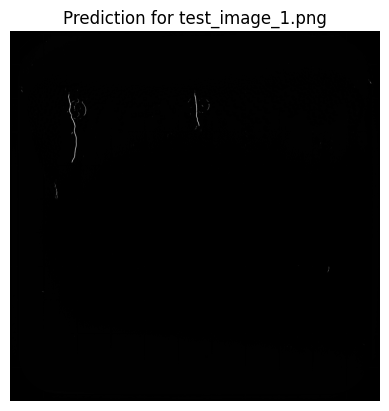

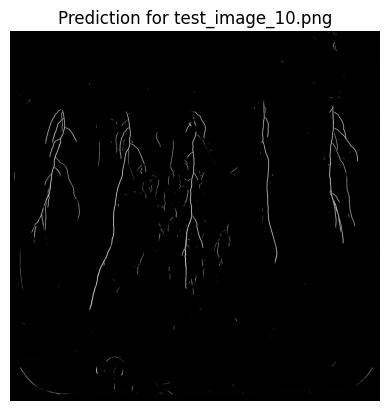

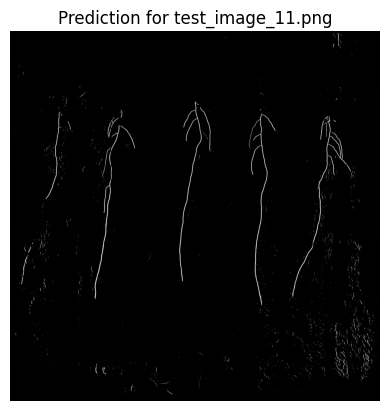

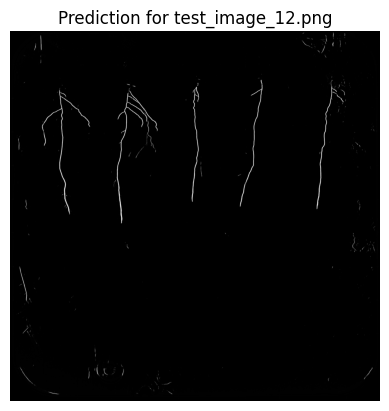

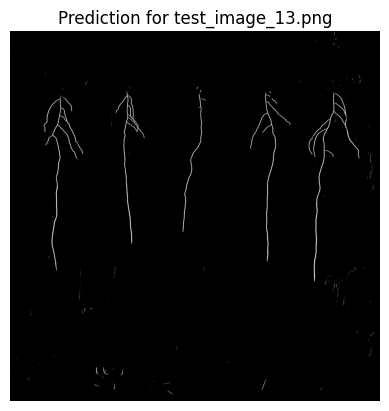

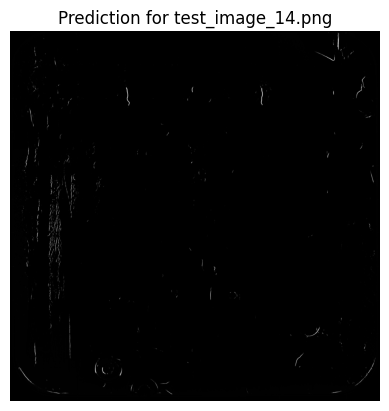

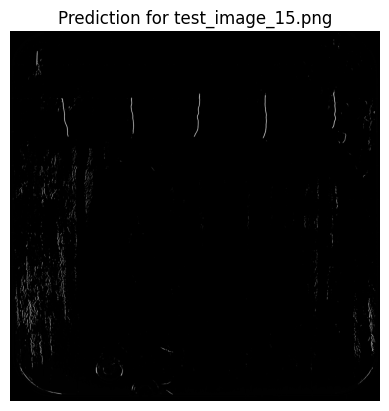

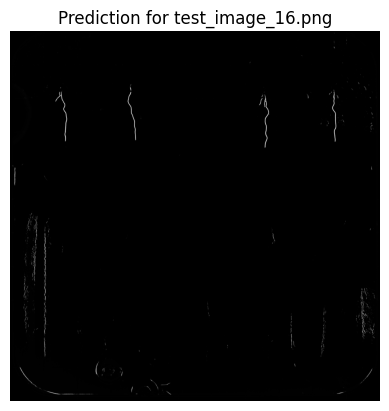

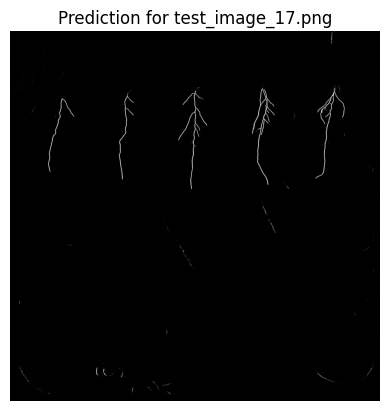

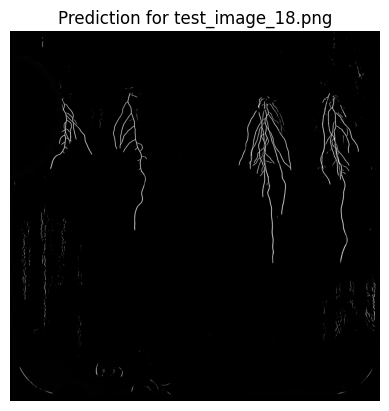

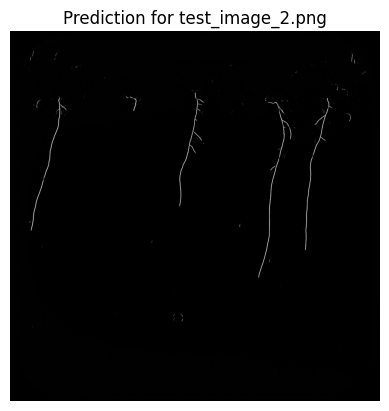

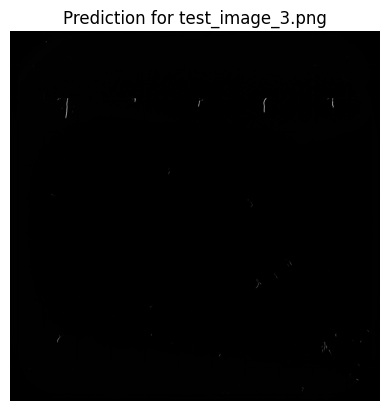

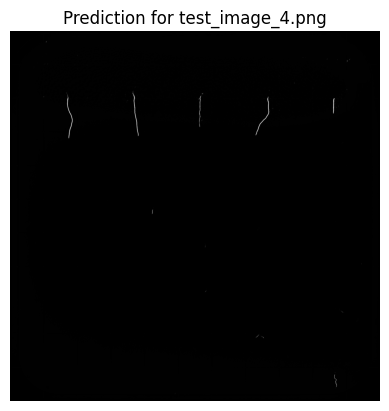

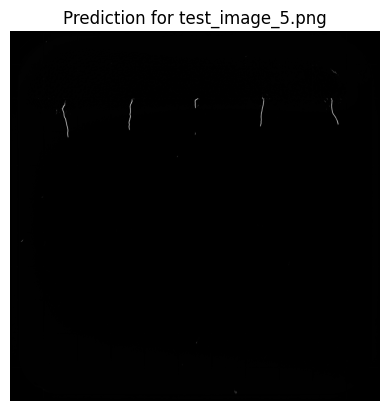

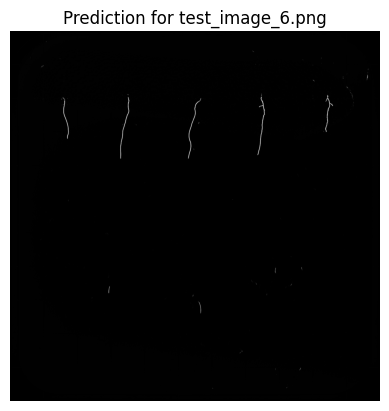

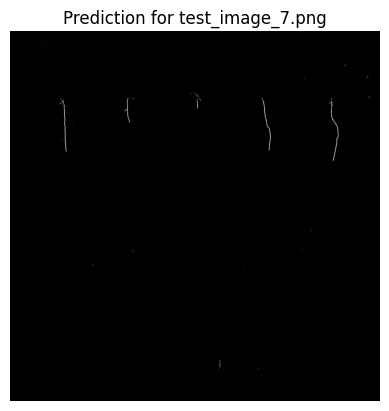

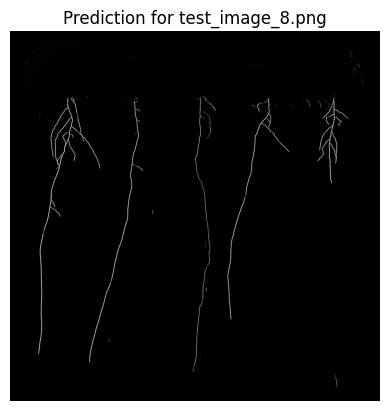

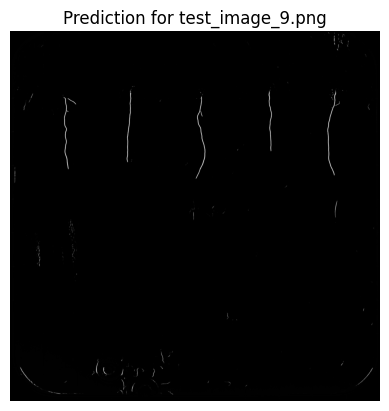

In [5]:


# **Load the model**
model_path = "PetarPaskalev_232725_unet_model_2_256px_80F1.h5"
model = load_model(model_path, custom_objects={"f1": f1})

# **Run predictions**
predictions = []
for filename, patches_normalized in preprocessed_data:
    # Predict on patches
    predicted_patches = model.predict(patches_normalized, batch_size=16)
    
    # Reshape predictions back to original patch grid
    num_patches = int(np.sqrt(predicted_patches.shape[0]))  # Assuming square grid
    predicted_patches = predicted_patches.reshape(num_patches, num_patches, patch_size, patch_size)
    
    # Reconstruct the full image using unpatchify
    petri_dish_padded_shape = (patch_size * num_patches, patch_size * num_patches)
    reconstructed_prediction = unpatchify(predicted_patches, petri_dish_padded_shape)
    
    # Store the prediction
    predictions.append((filename, reconstructed_prediction))
    print(f"Prediction completed for {filename}")

# **Visualize predictions**
for filename, predicted_mask in predictions:
    plt.figure(dpi=100)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title(f"Prediction for {filename}")
    plt.axis('off')
    plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Loop through predictions and convert each mask to binary
binary_predictions = []
for filename, predicted_mask in predictions:
    # Convert predicted mask to binary: thresholding at 0.5
    binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255
    
    # Store the binary mask
    binary_predictions.append((filename, binary_mask))

 

  


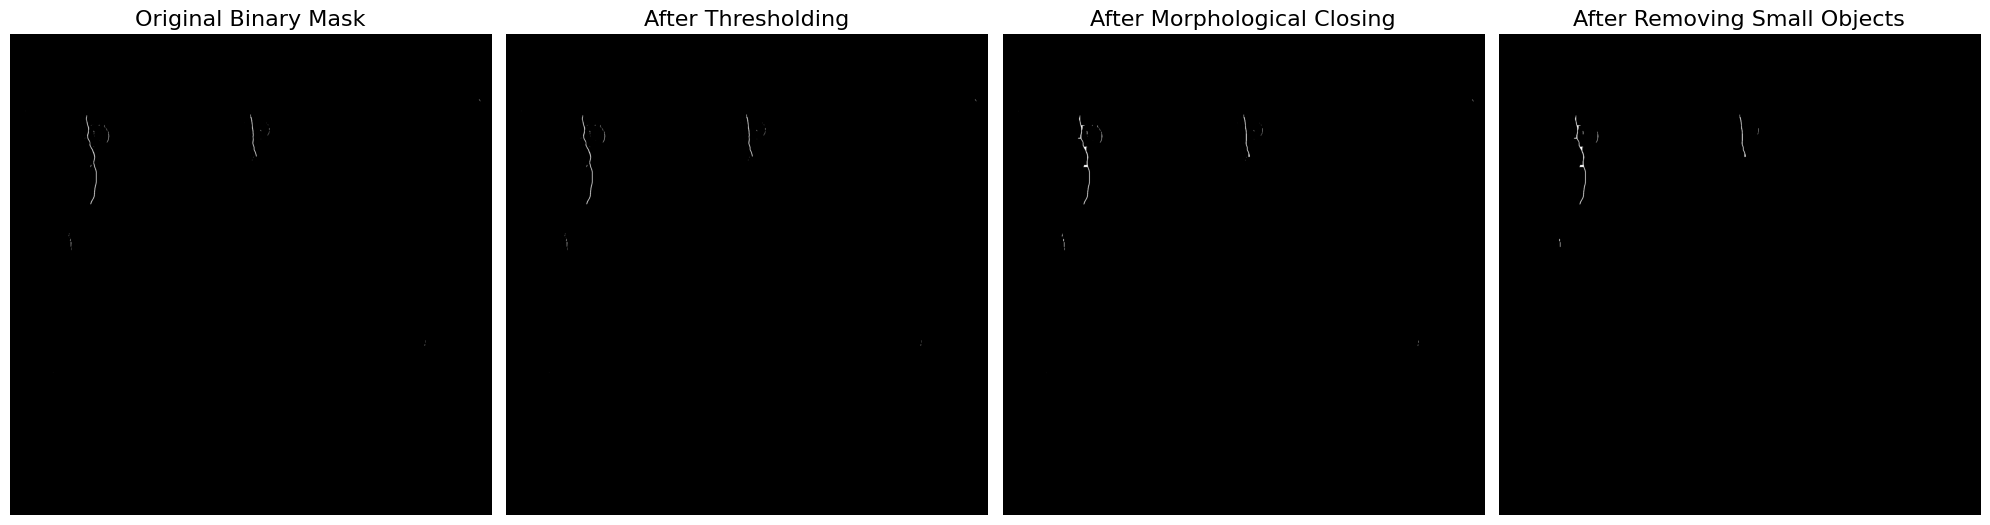

Processed test_image_1.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


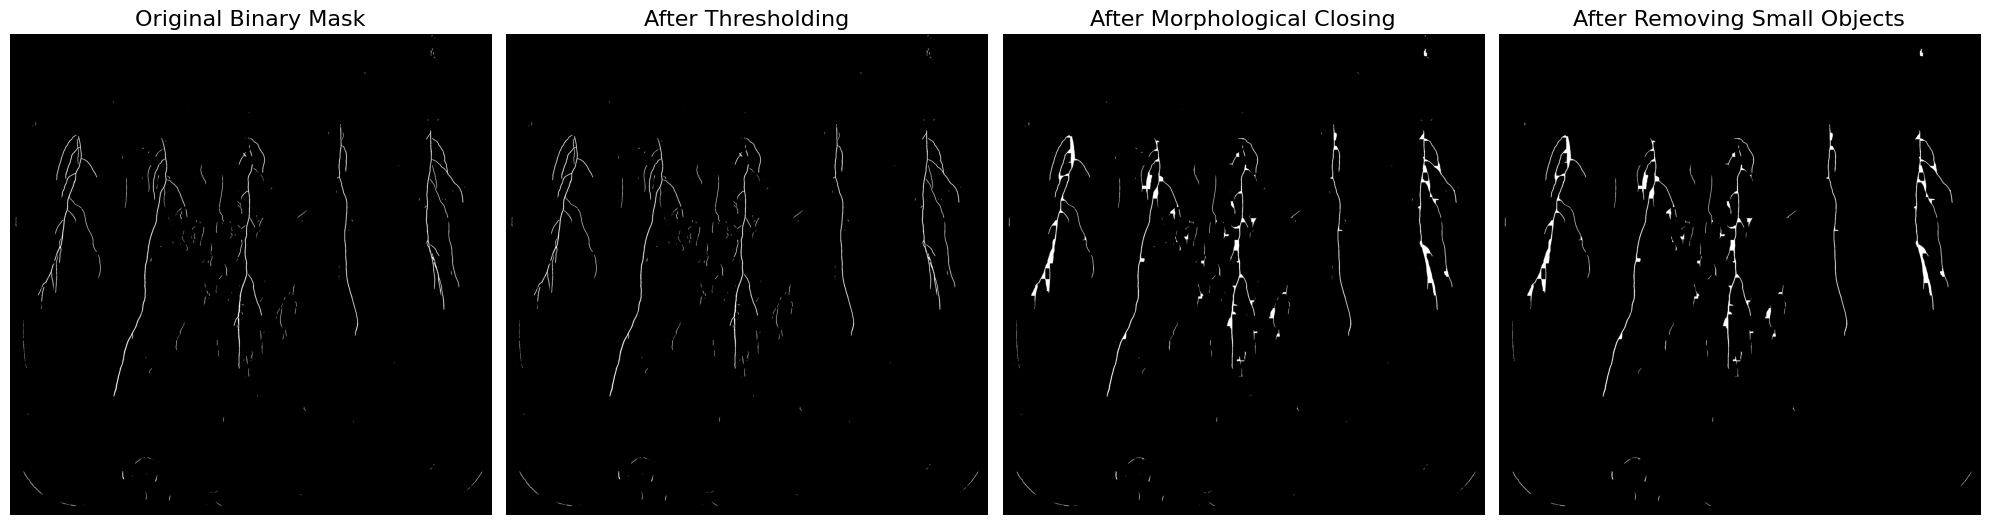

Processed test_image_10.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


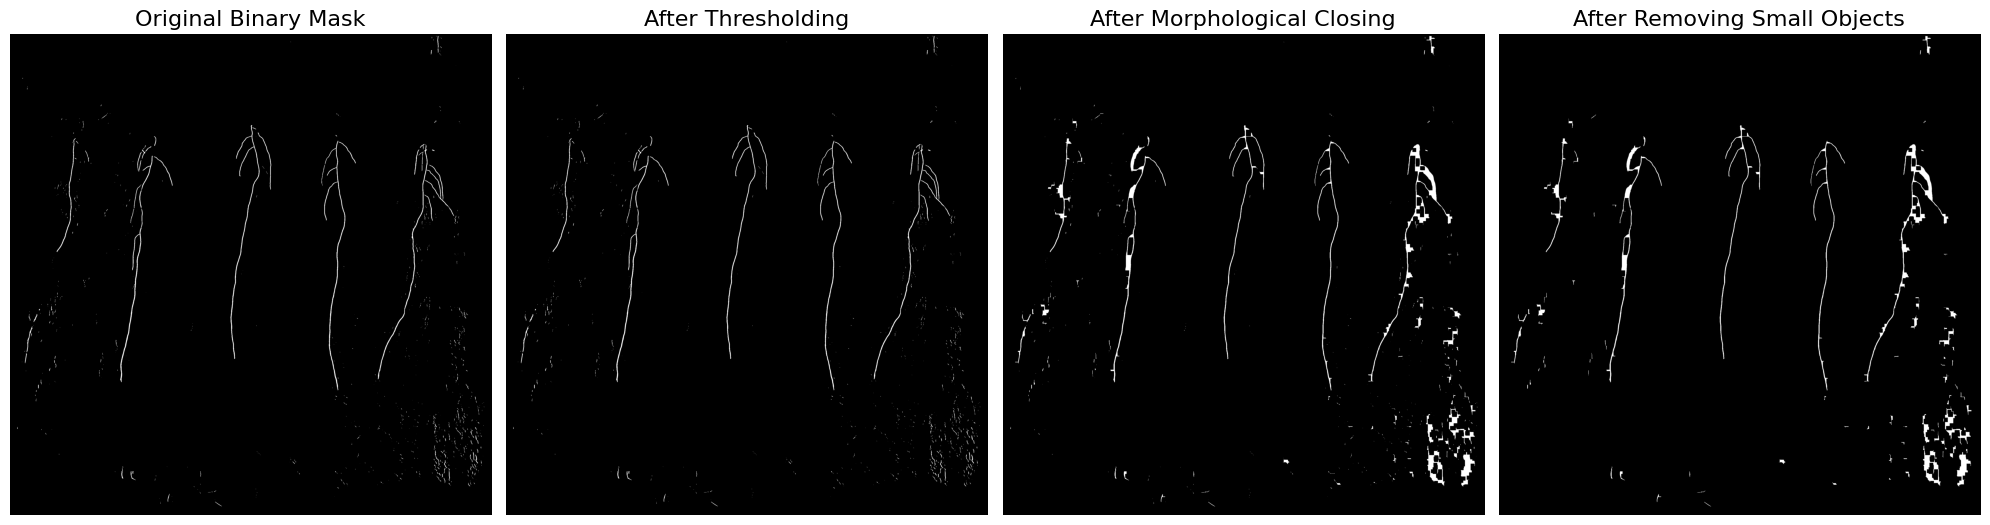

Processed test_image_11.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


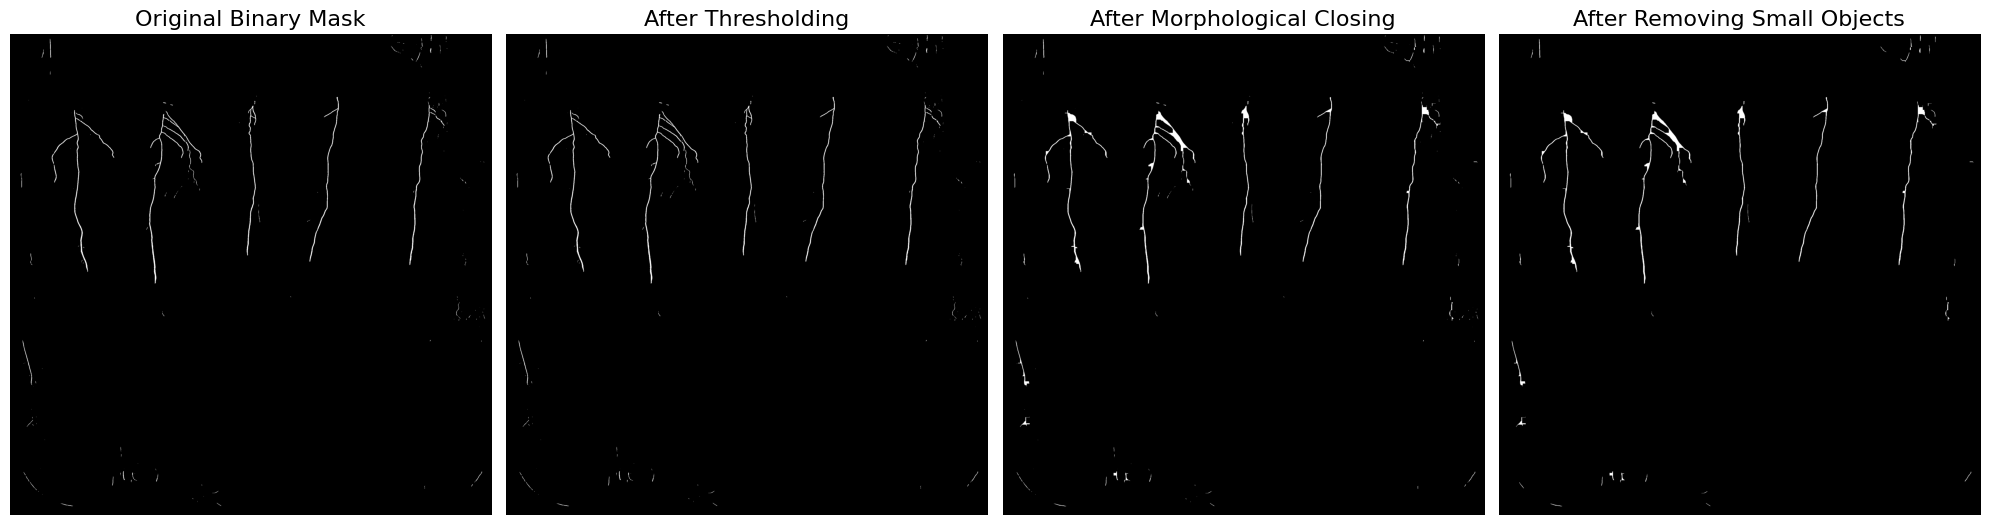

Processed test_image_12.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


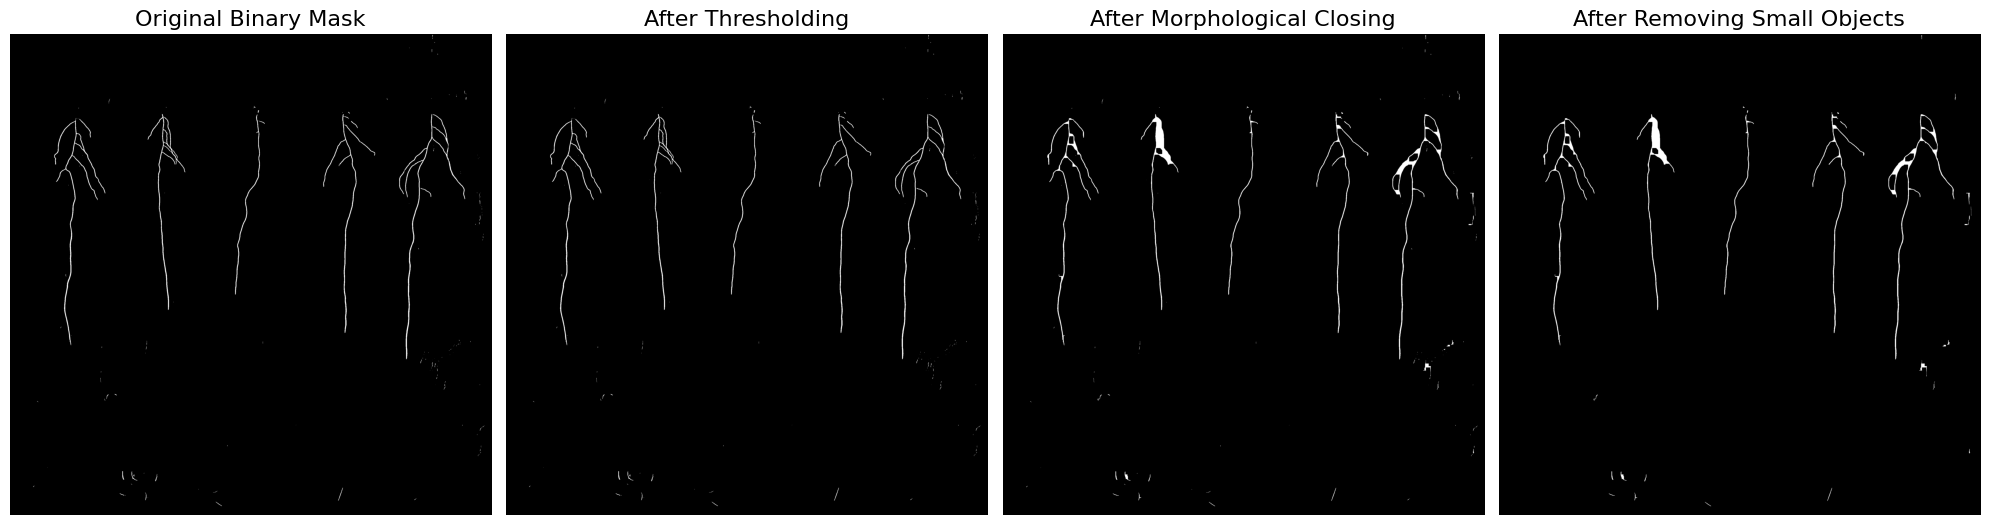

Processed test_image_13.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


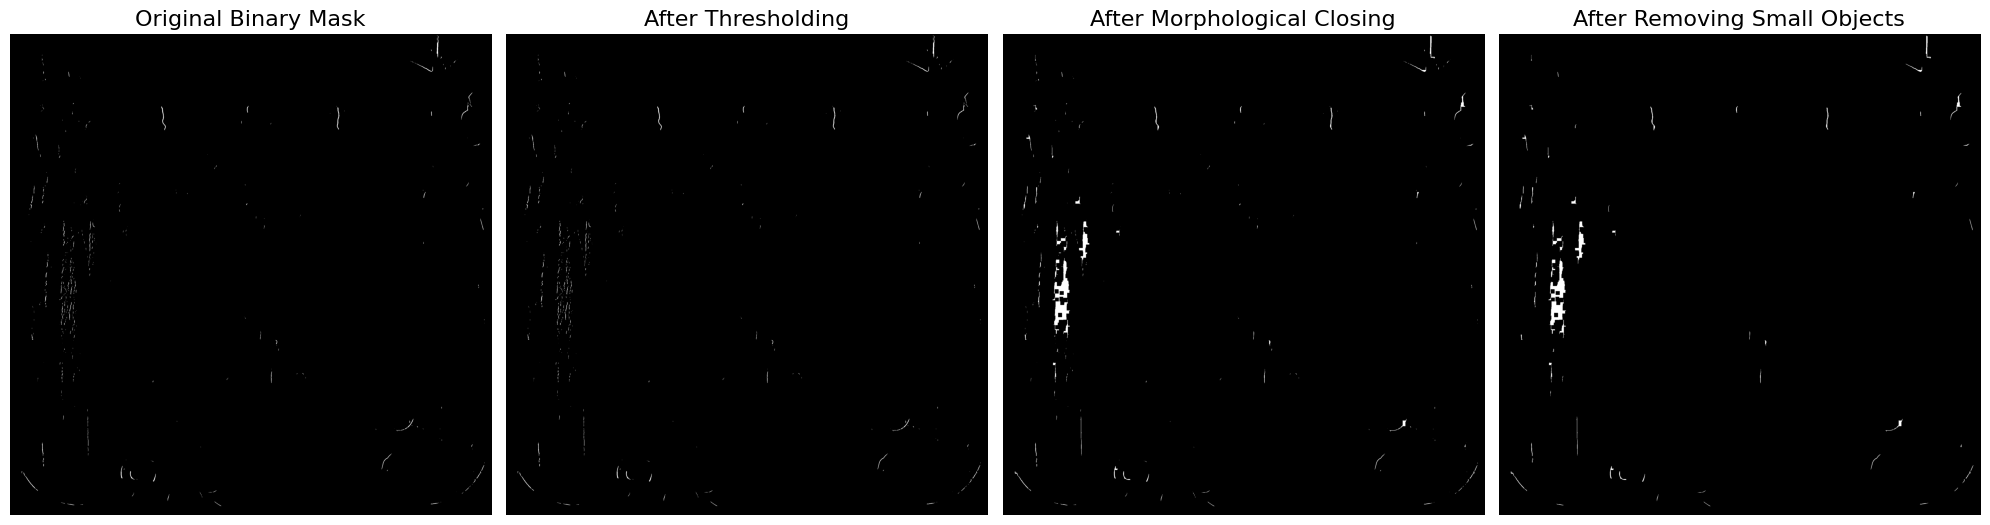

Processed test_image_14.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


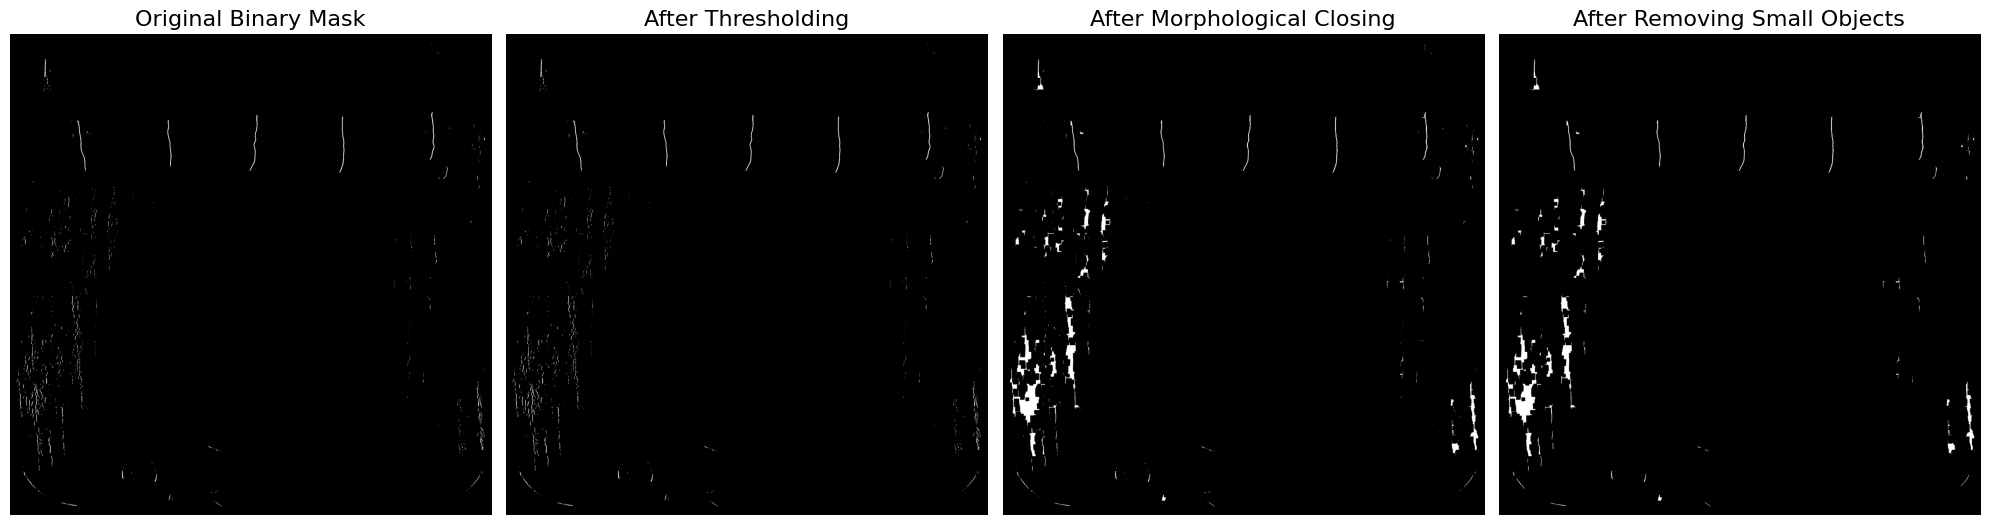

Processed test_image_15.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


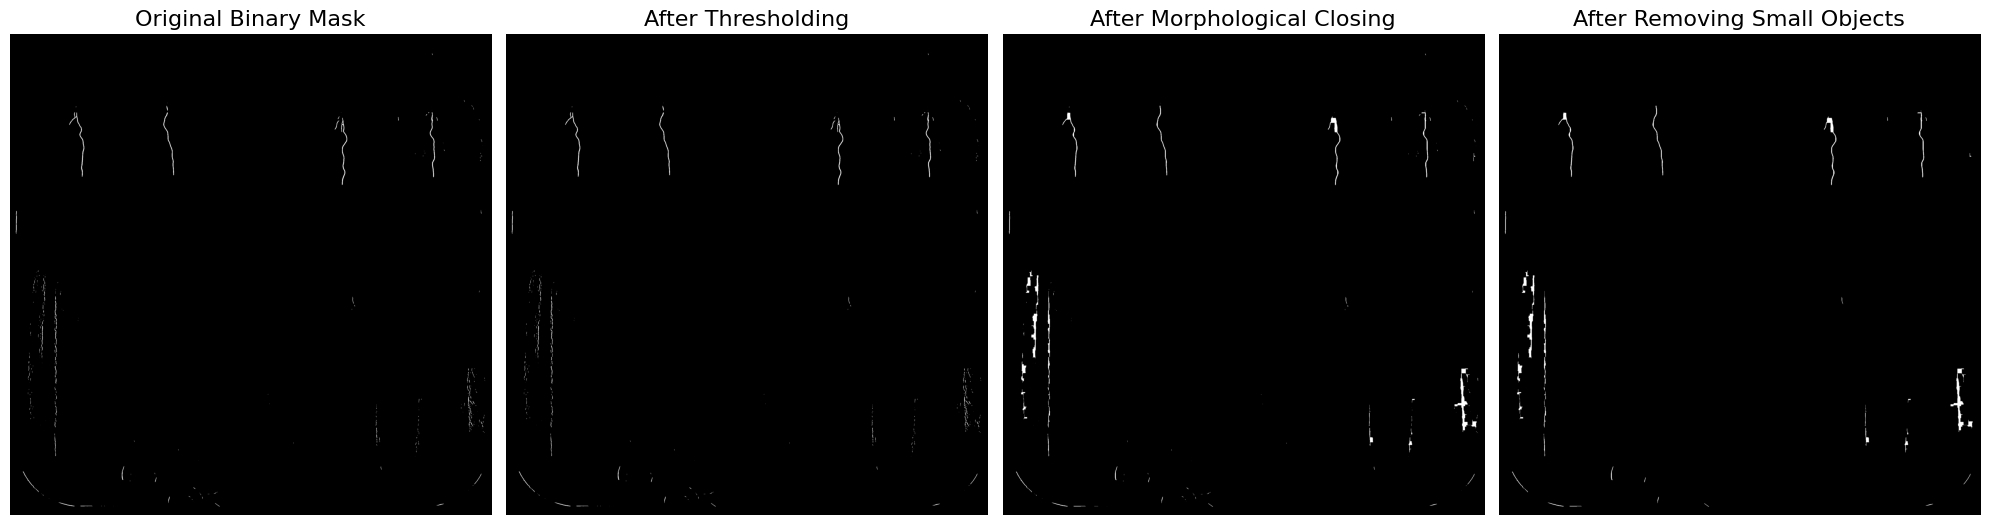

Processed test_image_16.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


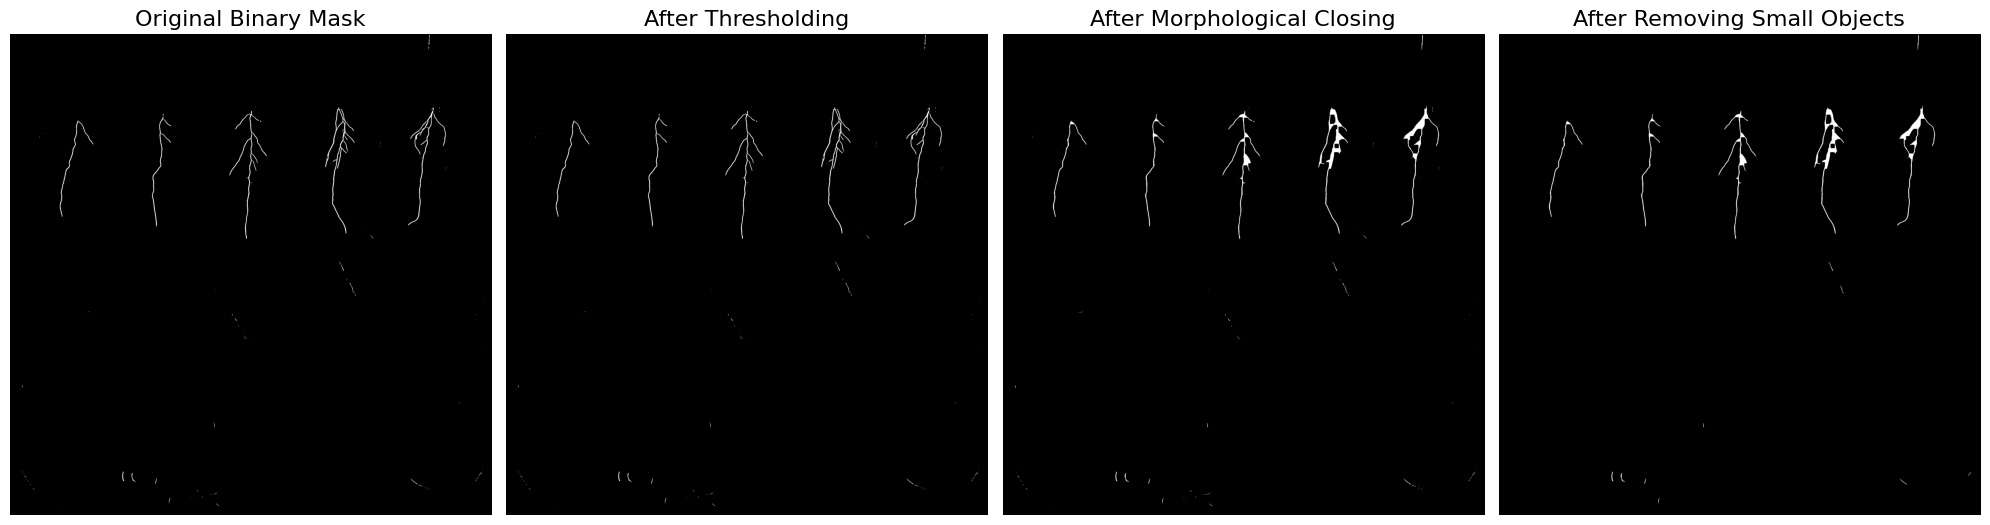

Processed test_image_17.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


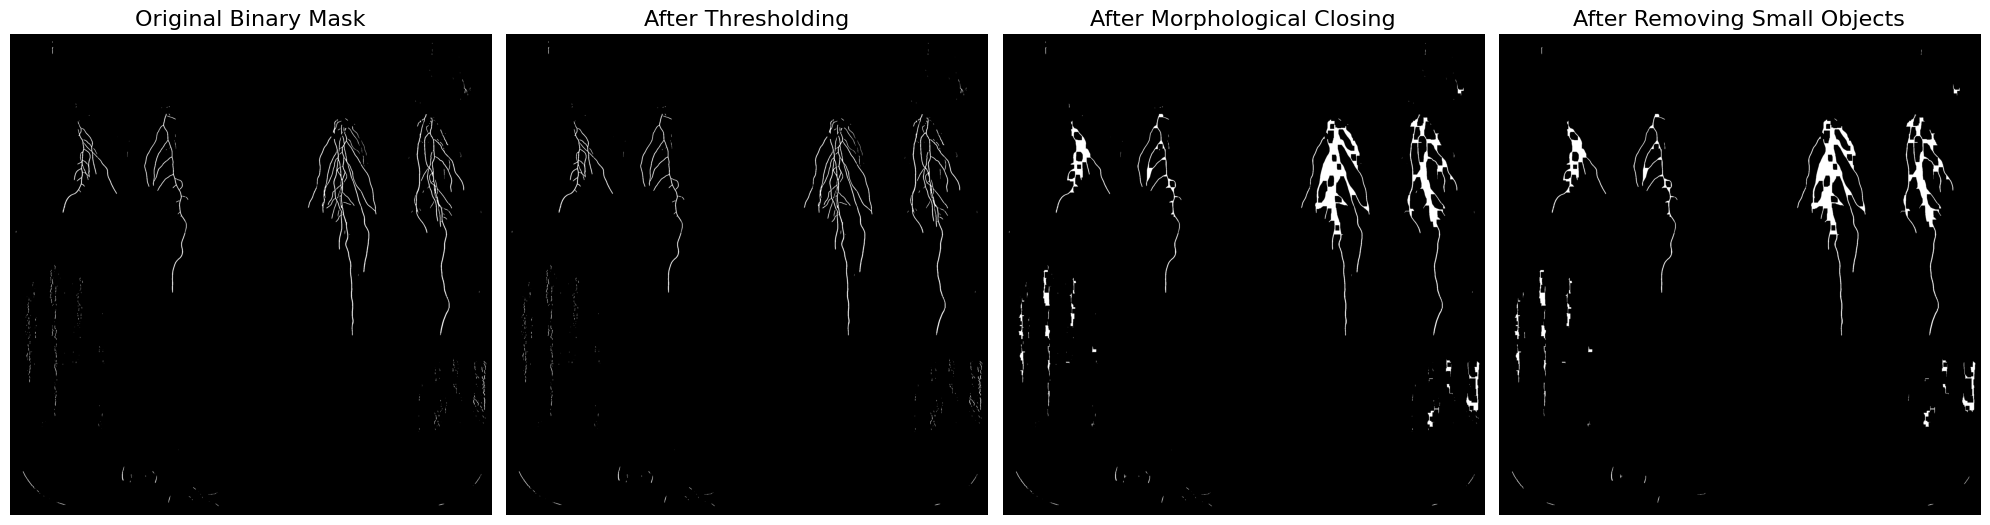

Processed test_image_18.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


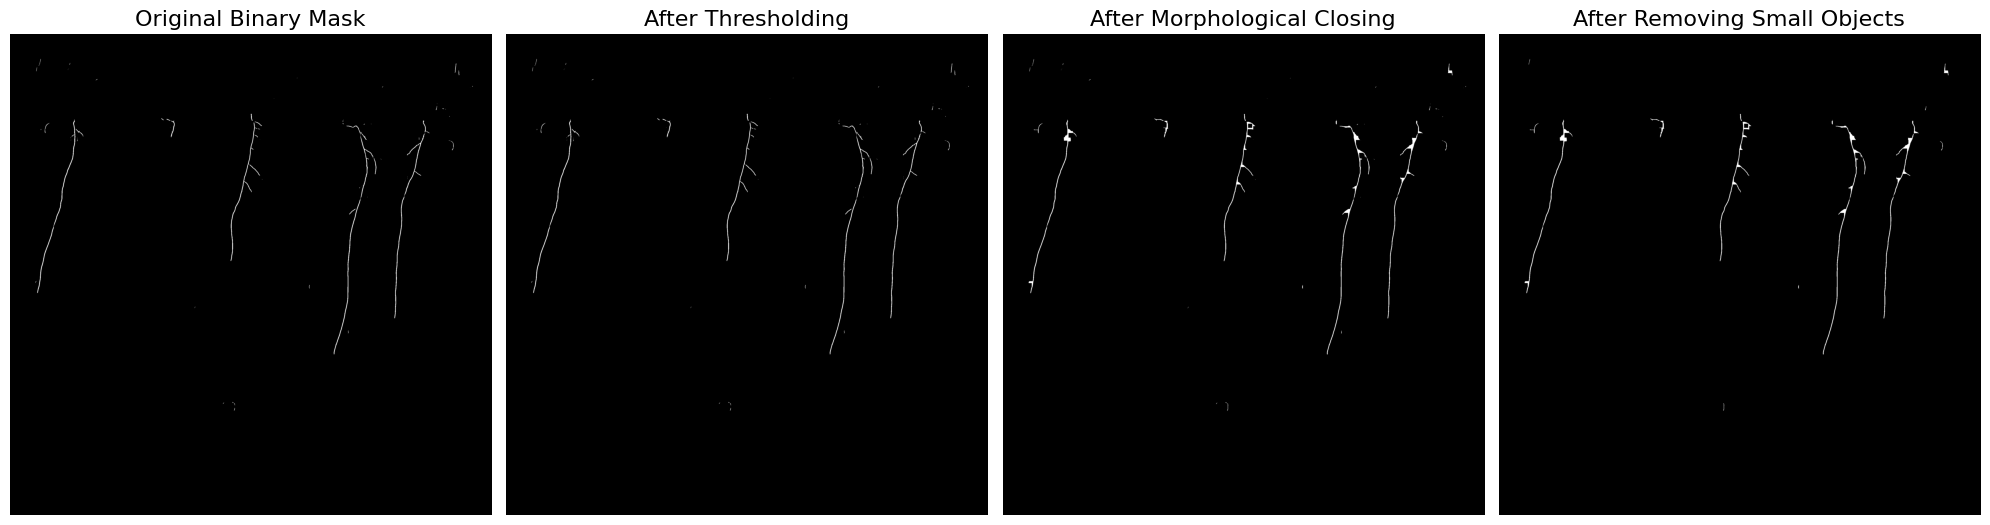

Processed test_image_2.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


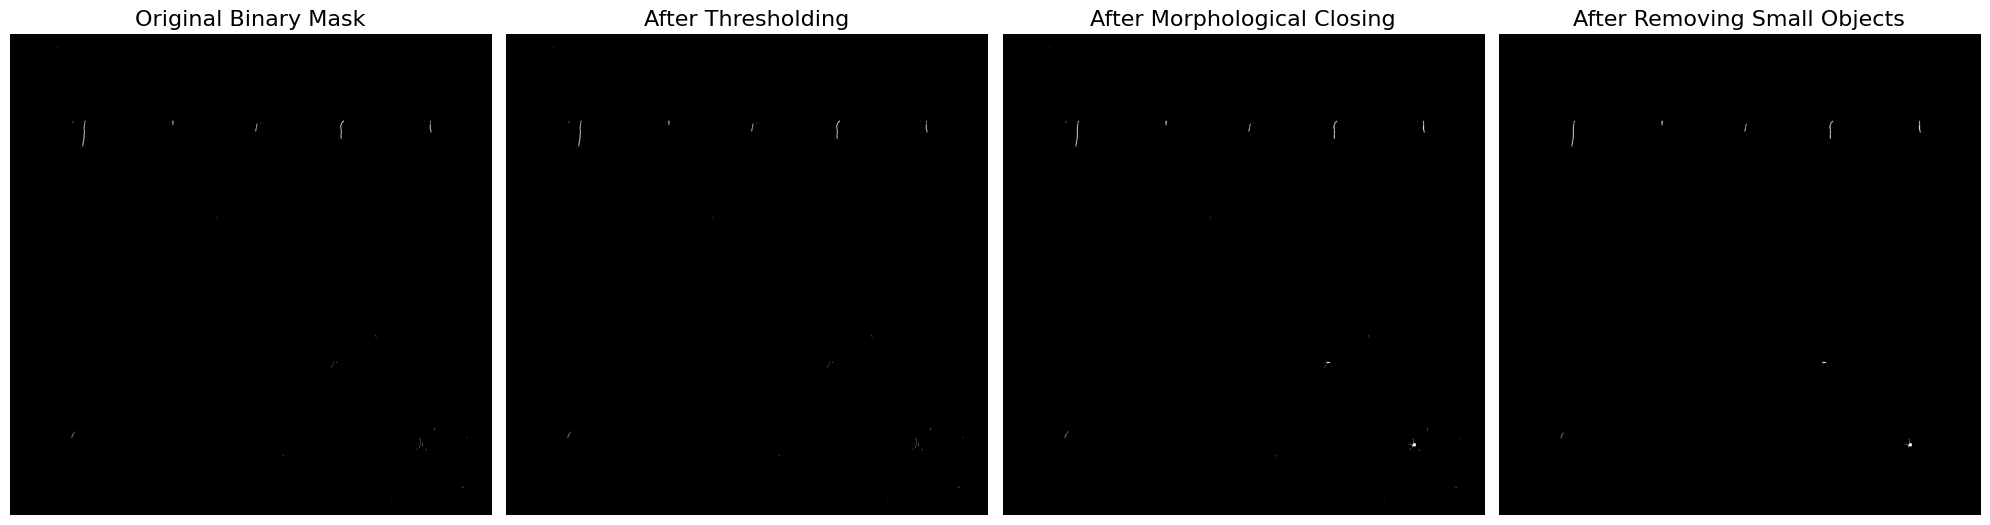

Processed test_image_3.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


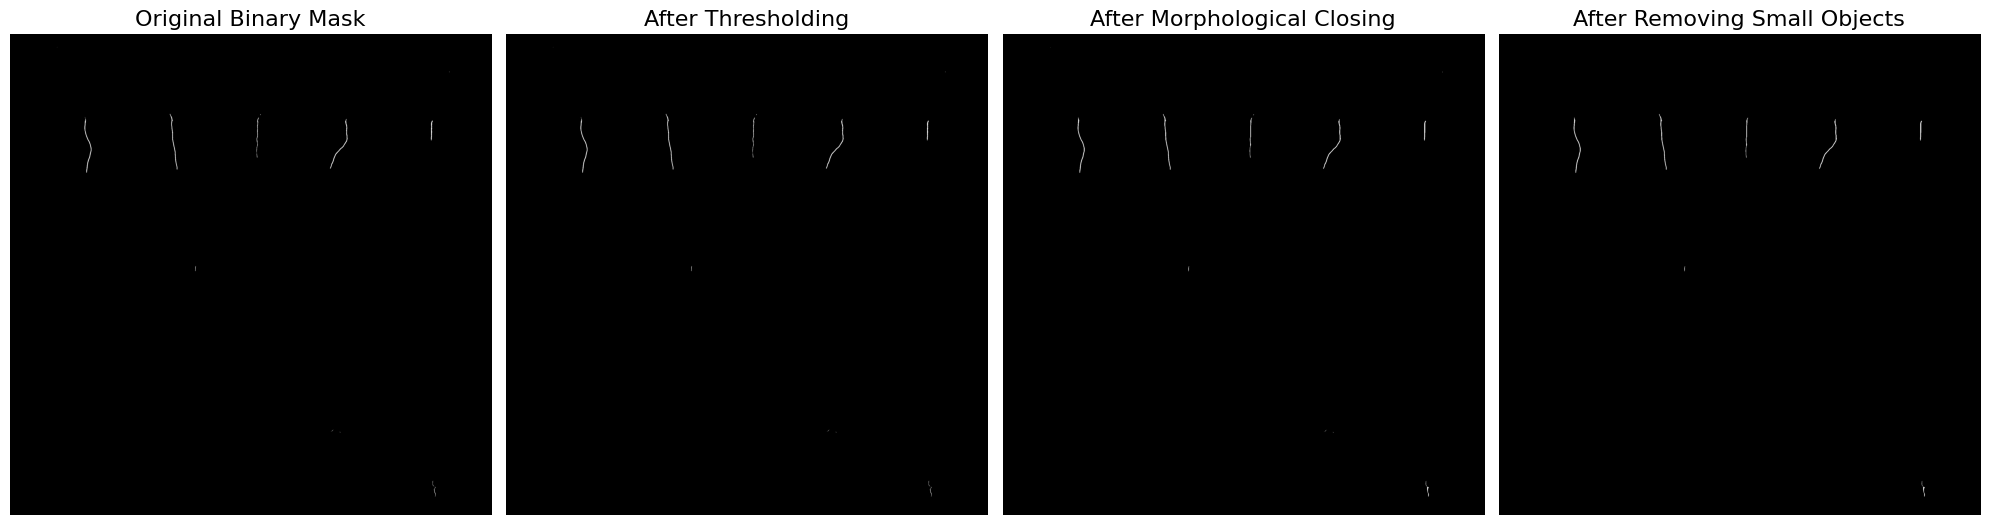

Processed test_image_4.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


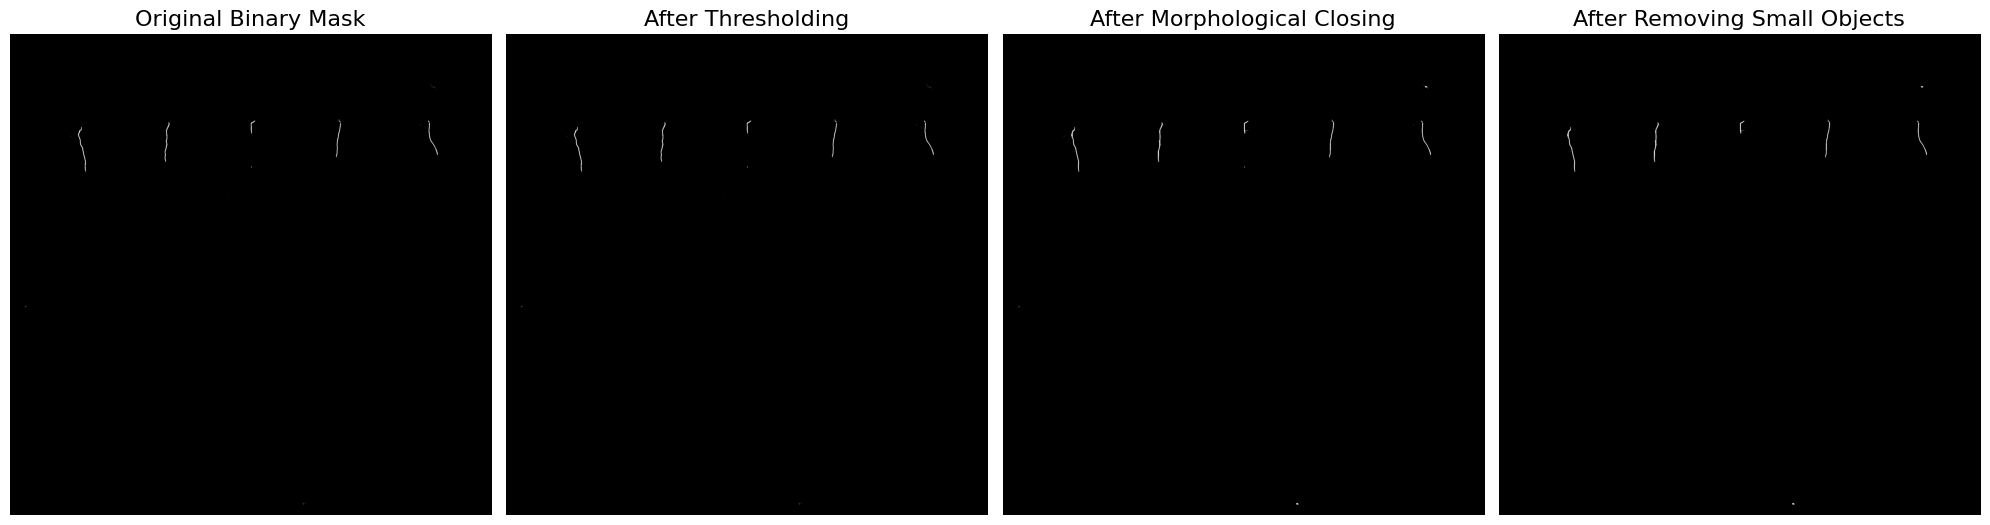

Processed test_image_5.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


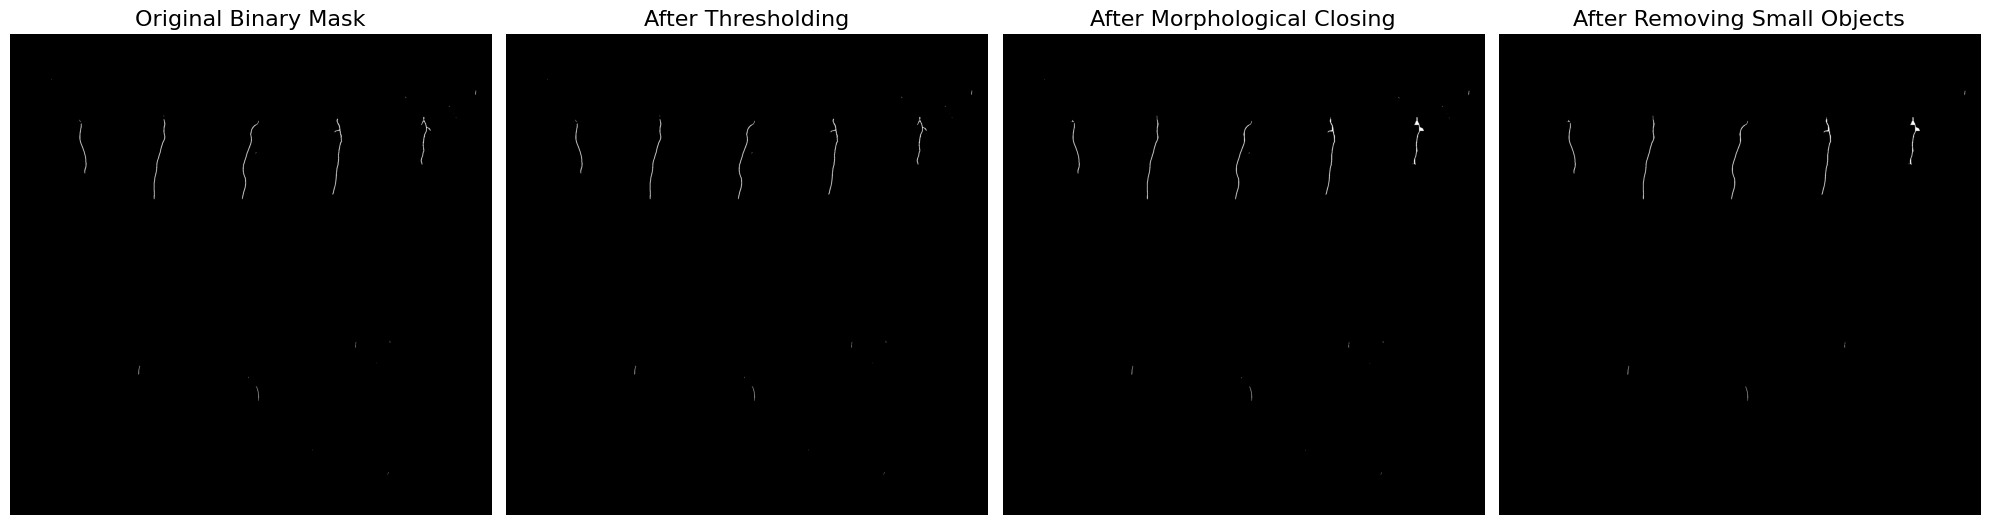

Processed test_image_6.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


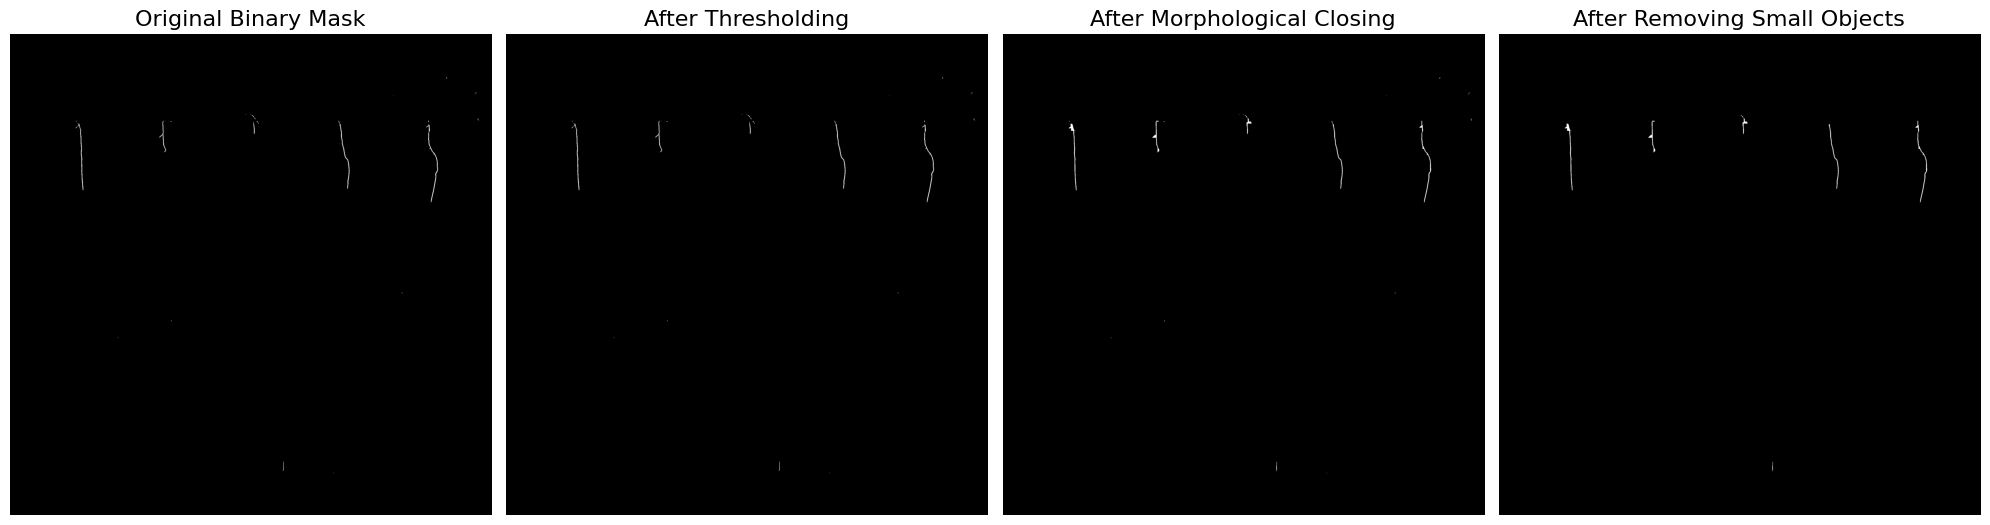

Processed test_image_7.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


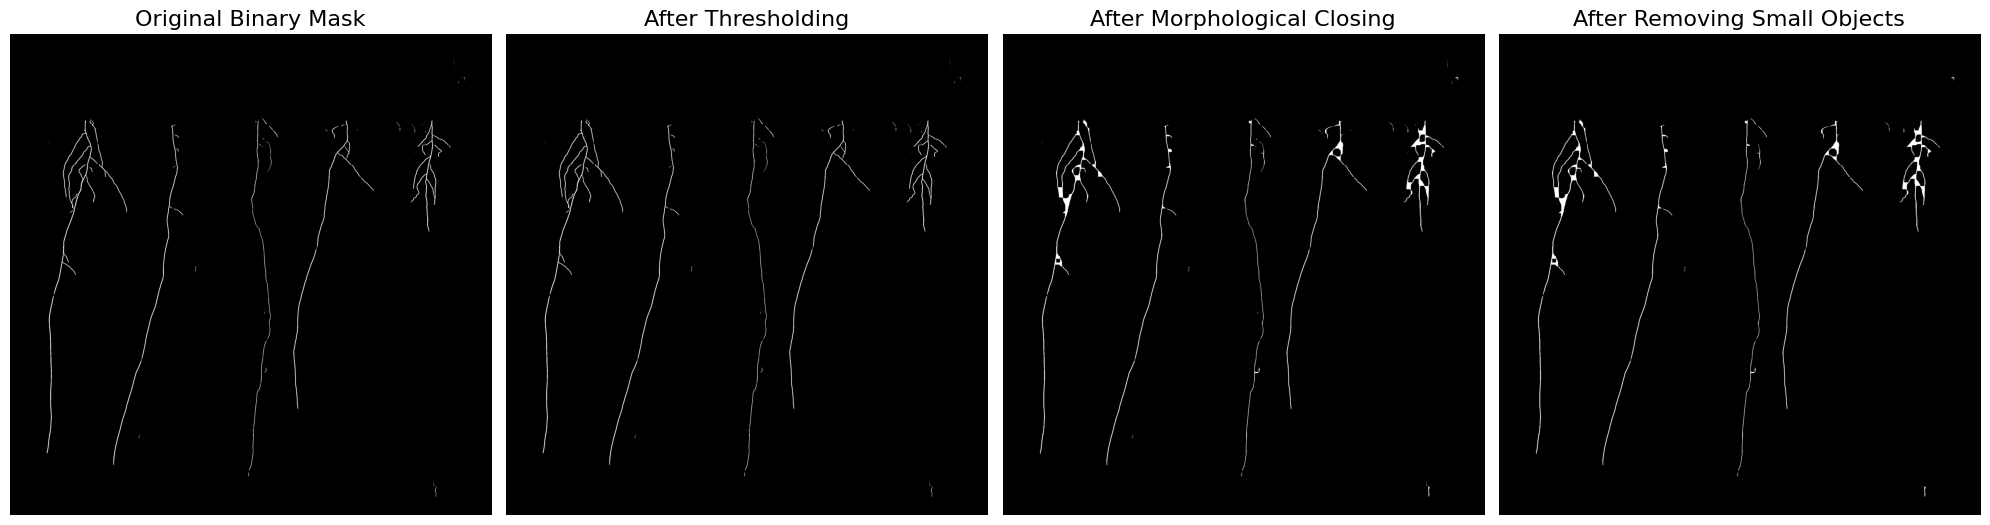

Processed test_image_8.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


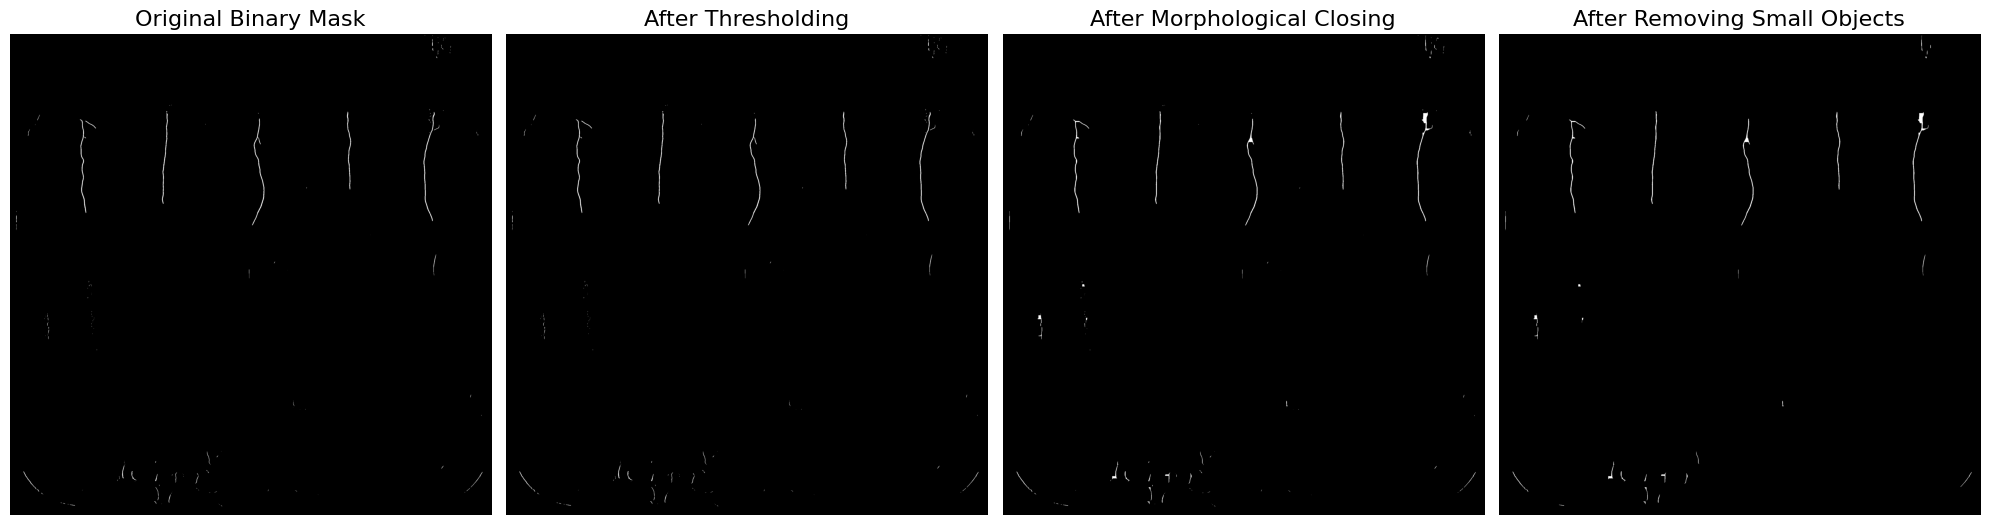

Processed test_image_9.png: Threshold = 50, Kernel Size = 22, Min Object Size = 50


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects

# Adjustable parameters
threshold_value = 50       # Adjust threshold value
kernel_size = 22           # Adjust kernel size for morphological closing
min_object_size = 50     # Adjust minimum object size for small object removal

# Process each binary mask in binary_predictions
processed_masks = []
for filename, binary_mask in binary_predictions:
    # Step 1: Apply thresholding
    _, thresholded_mask = cv2.threshold(binary_mask, threshold_value, 255, cv2.THRESH_BINARY)
    
    # Step 2: Apply morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    closed_mask = cv2.morphologyEx(thresholded_mask, cv2.MORPH_CLOSE, kernel)
    
    # Step 3: Remove small objects
    binary_mask_boolean = closed_mask > 0  # Convert to boolean (True for object pixels)
    cleaned_mask = remove_small_objects(binary_mask_boolean, min_size=min_object_size)
    cleaned_mask = (cleaned_mask * 255).astype(np.uint8)  # Convert back to uint8

    # Append processed mask
    processed_masks.append((filename, cleaned_mask))

    # Plot intermediate and final results
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 4, 1)
    plt.title("Original Binary Mask", fontsize=16)
    plt.imshow(binary_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("After Thresholding", fontsize=16)
    plt.imshow(thresholded_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("After Morphological Closing", fontsize=16)
    plt.imshow(closed_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("After Removing Small Objects", fontsize=16)
    plt.imshow(cleaned_mask, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Processed {filename}: Threshold = {threshold_value}, Kernel Size = {kernel_size}, Min Object Size = {min_object_size}")


Filename: test_image_1.png | Number of connected components: 7


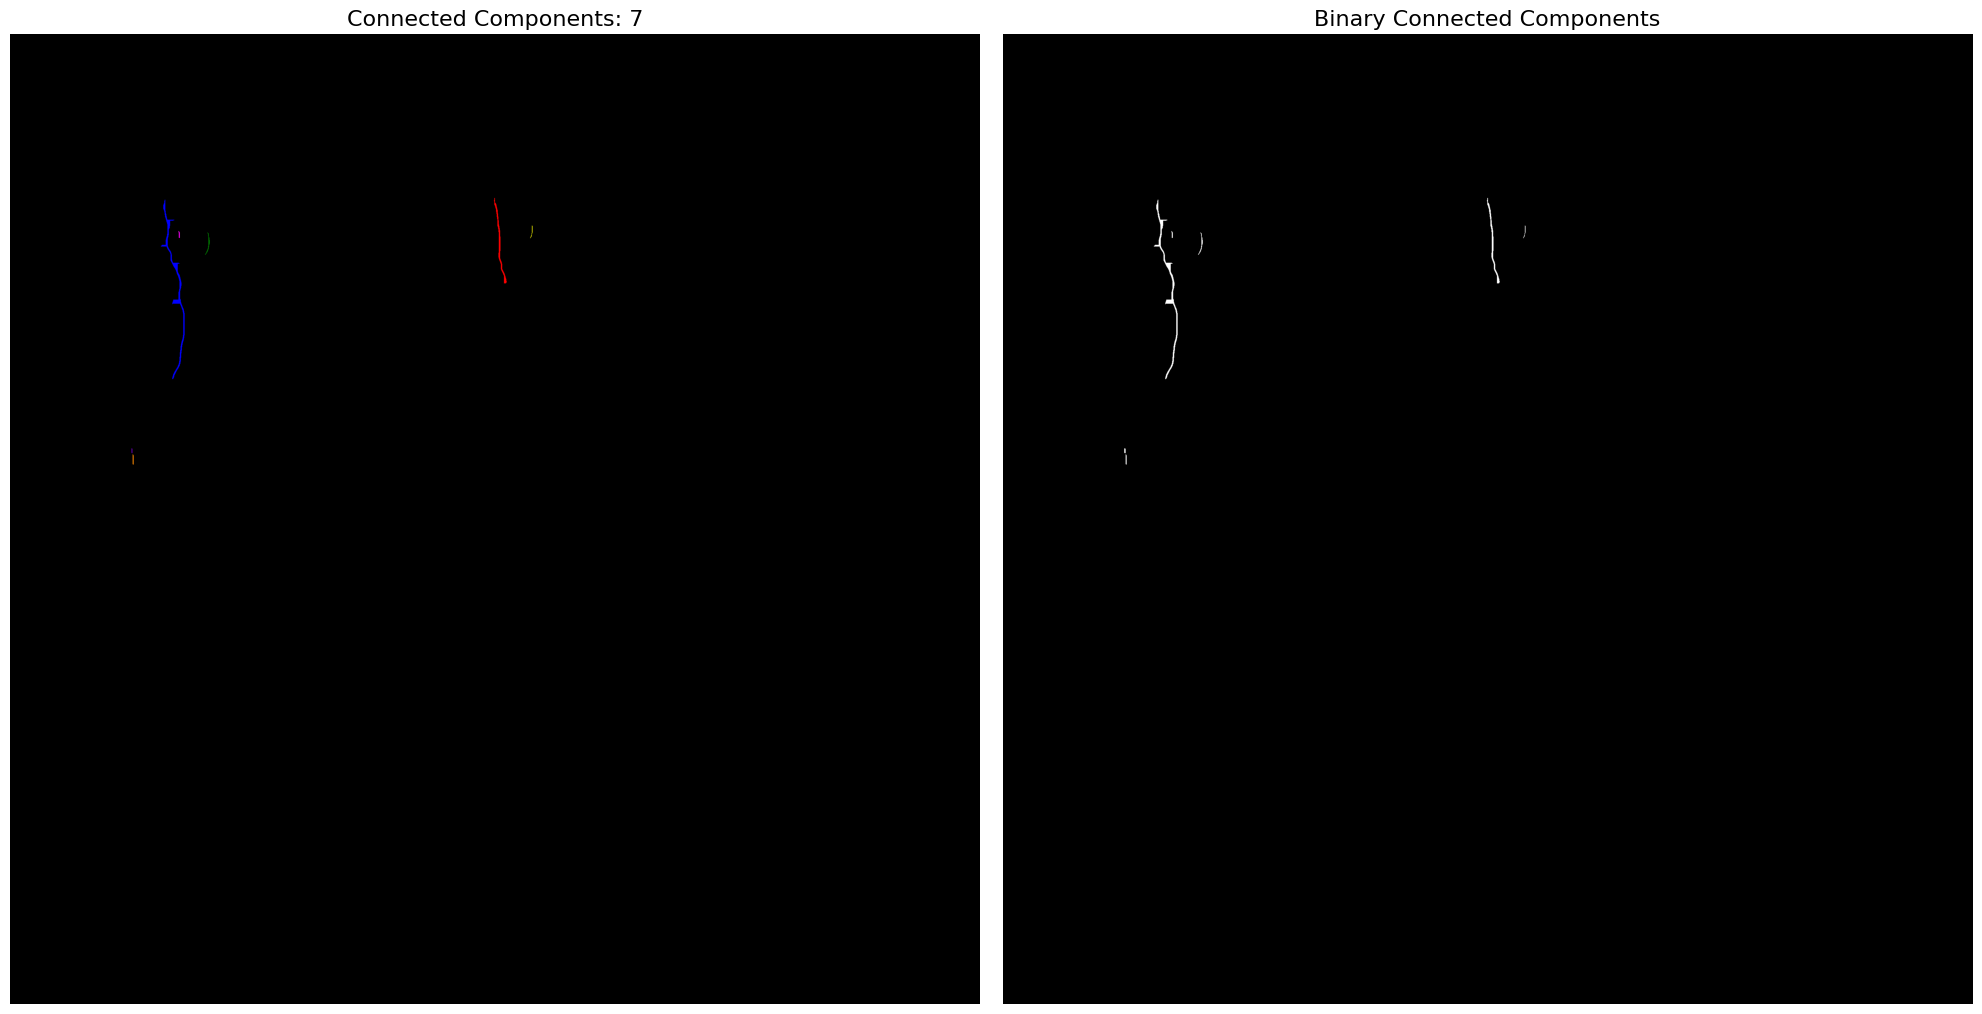

Filename: test_image_10.png | Number of connected components: 67


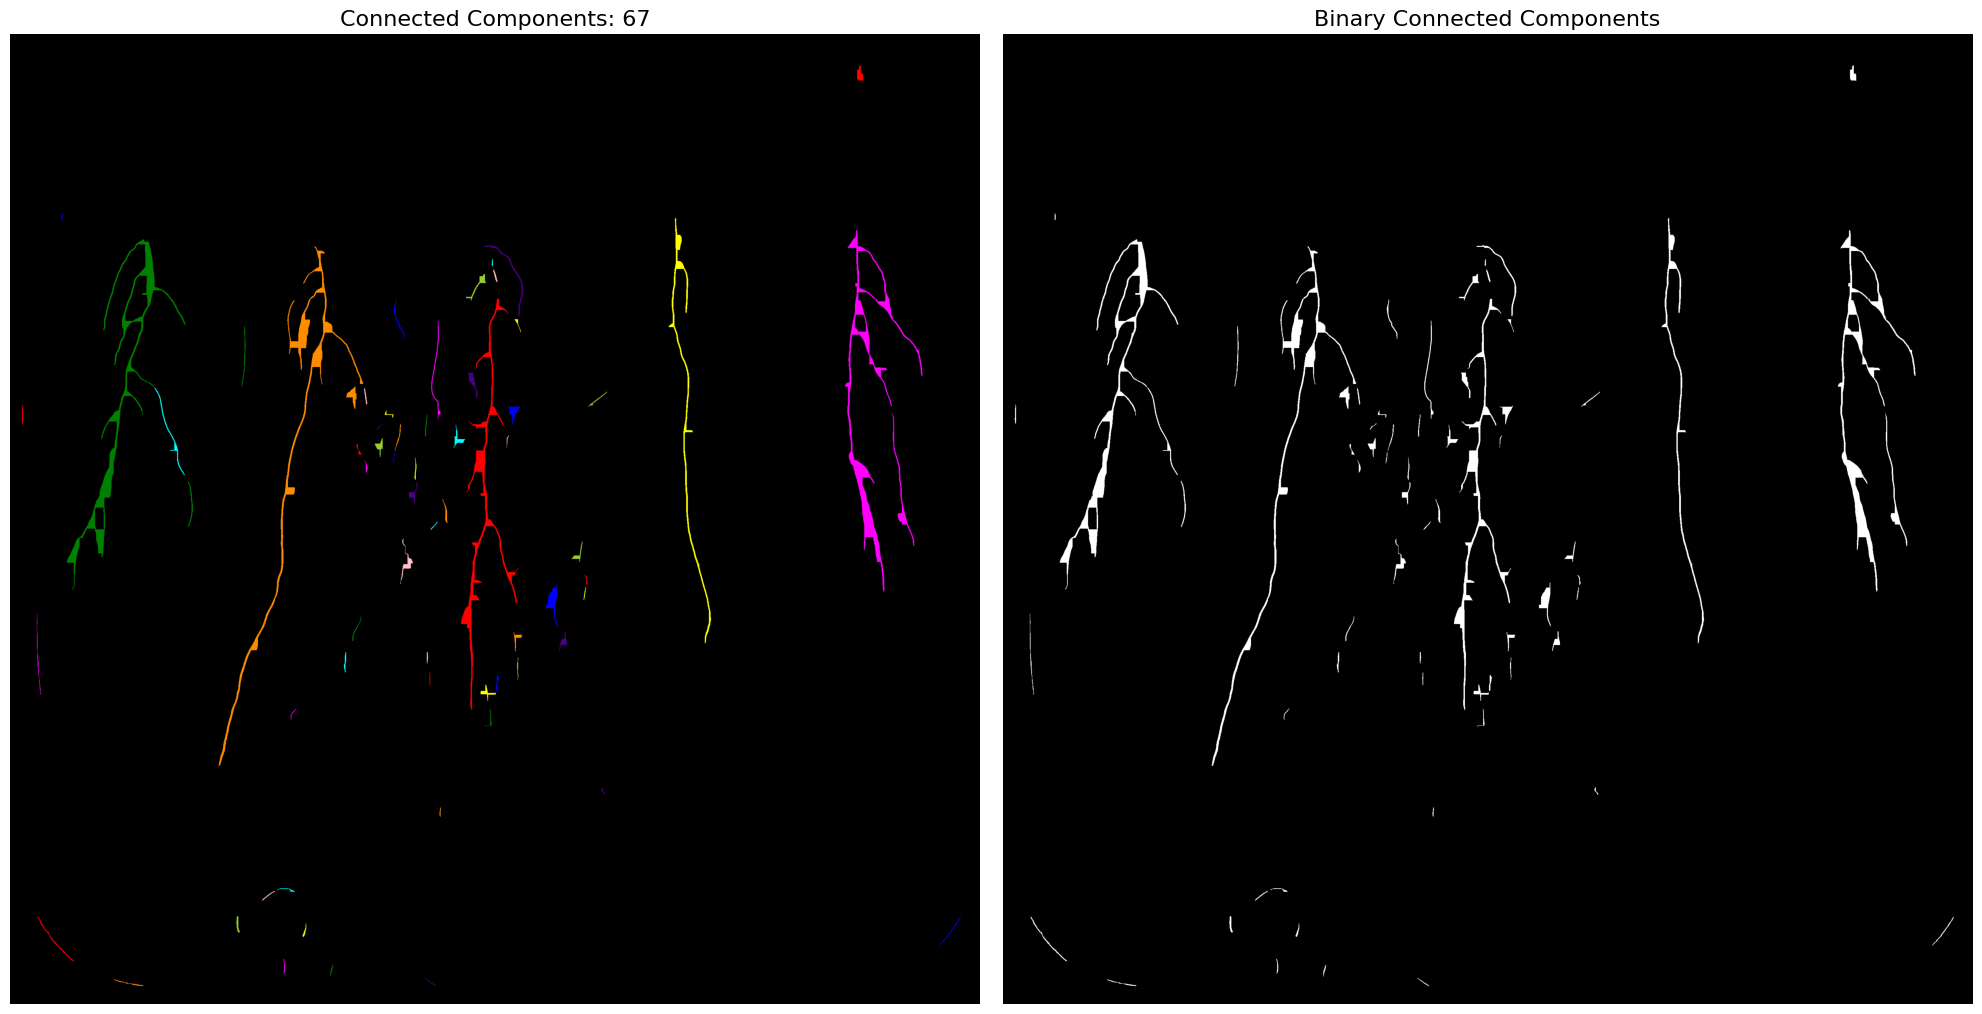

Filename: test_image_11.png | Number of connected components: 86


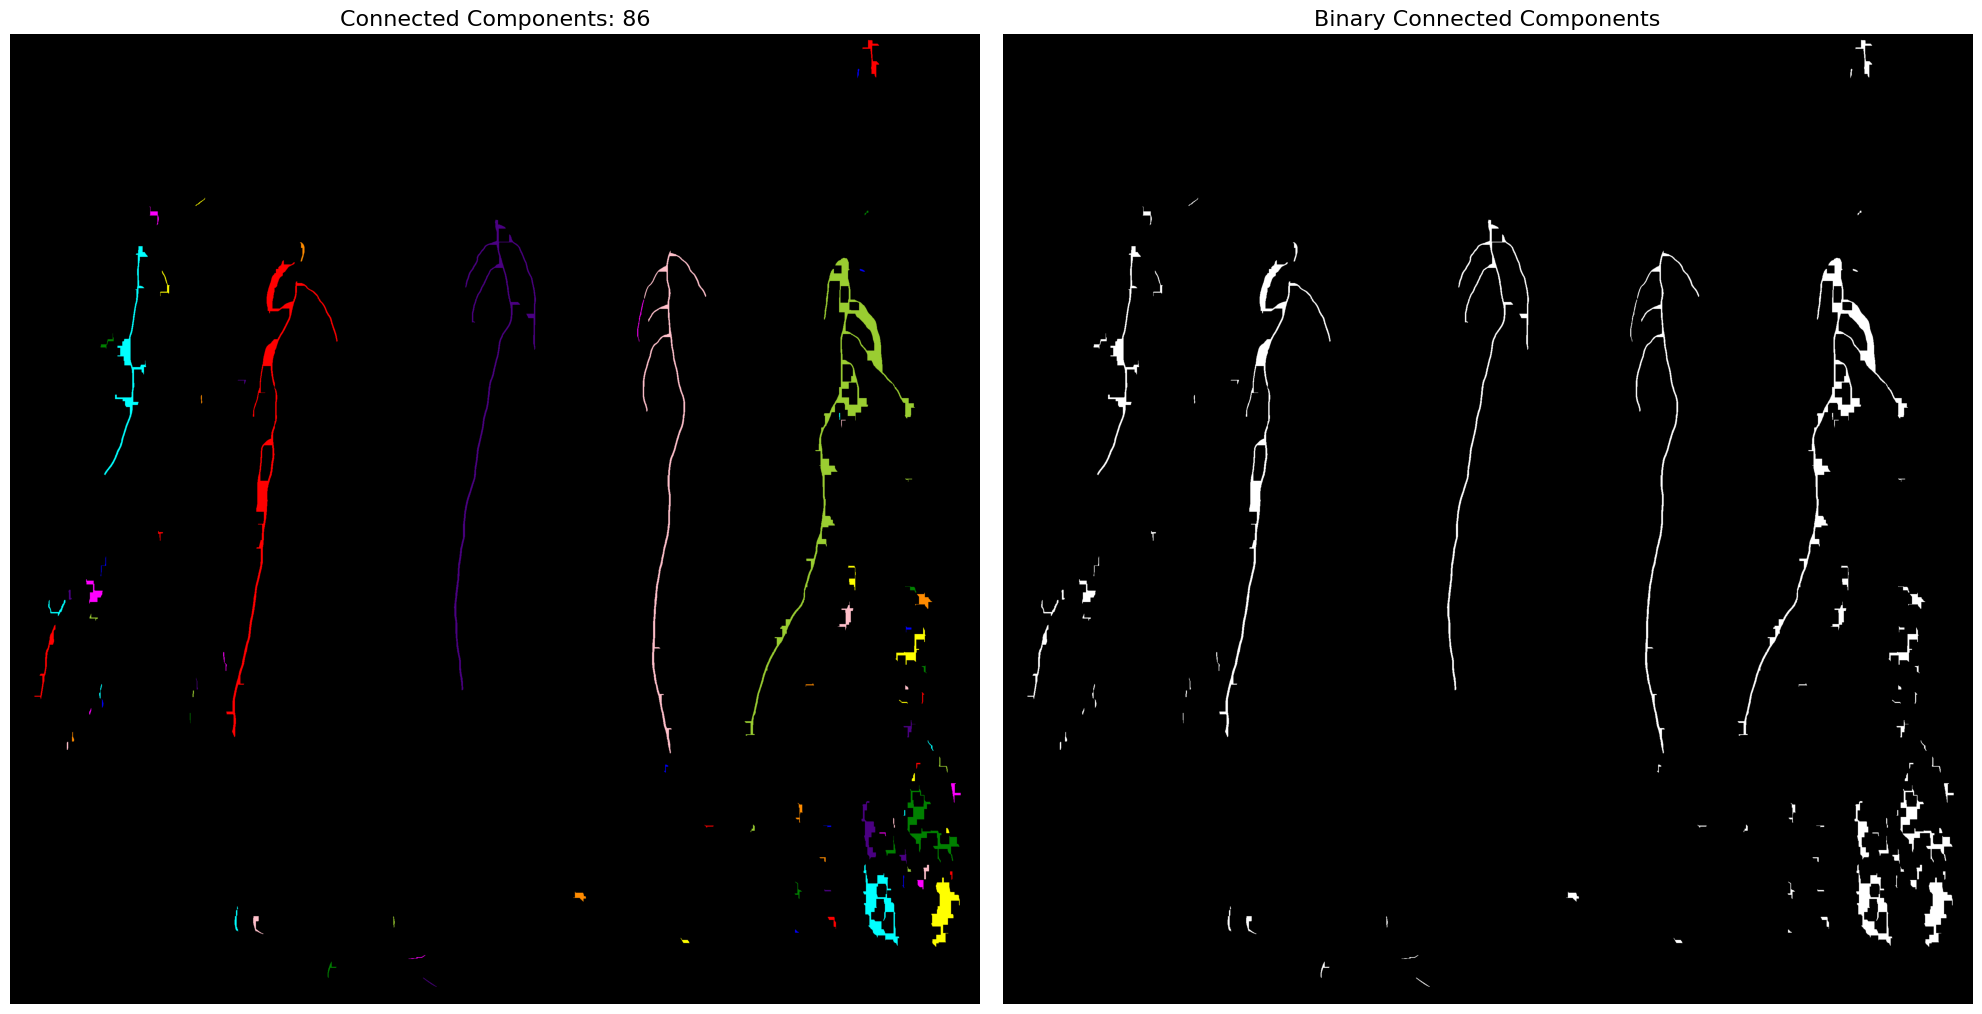

Filename: test_image_12.png | Number of connected components: 42


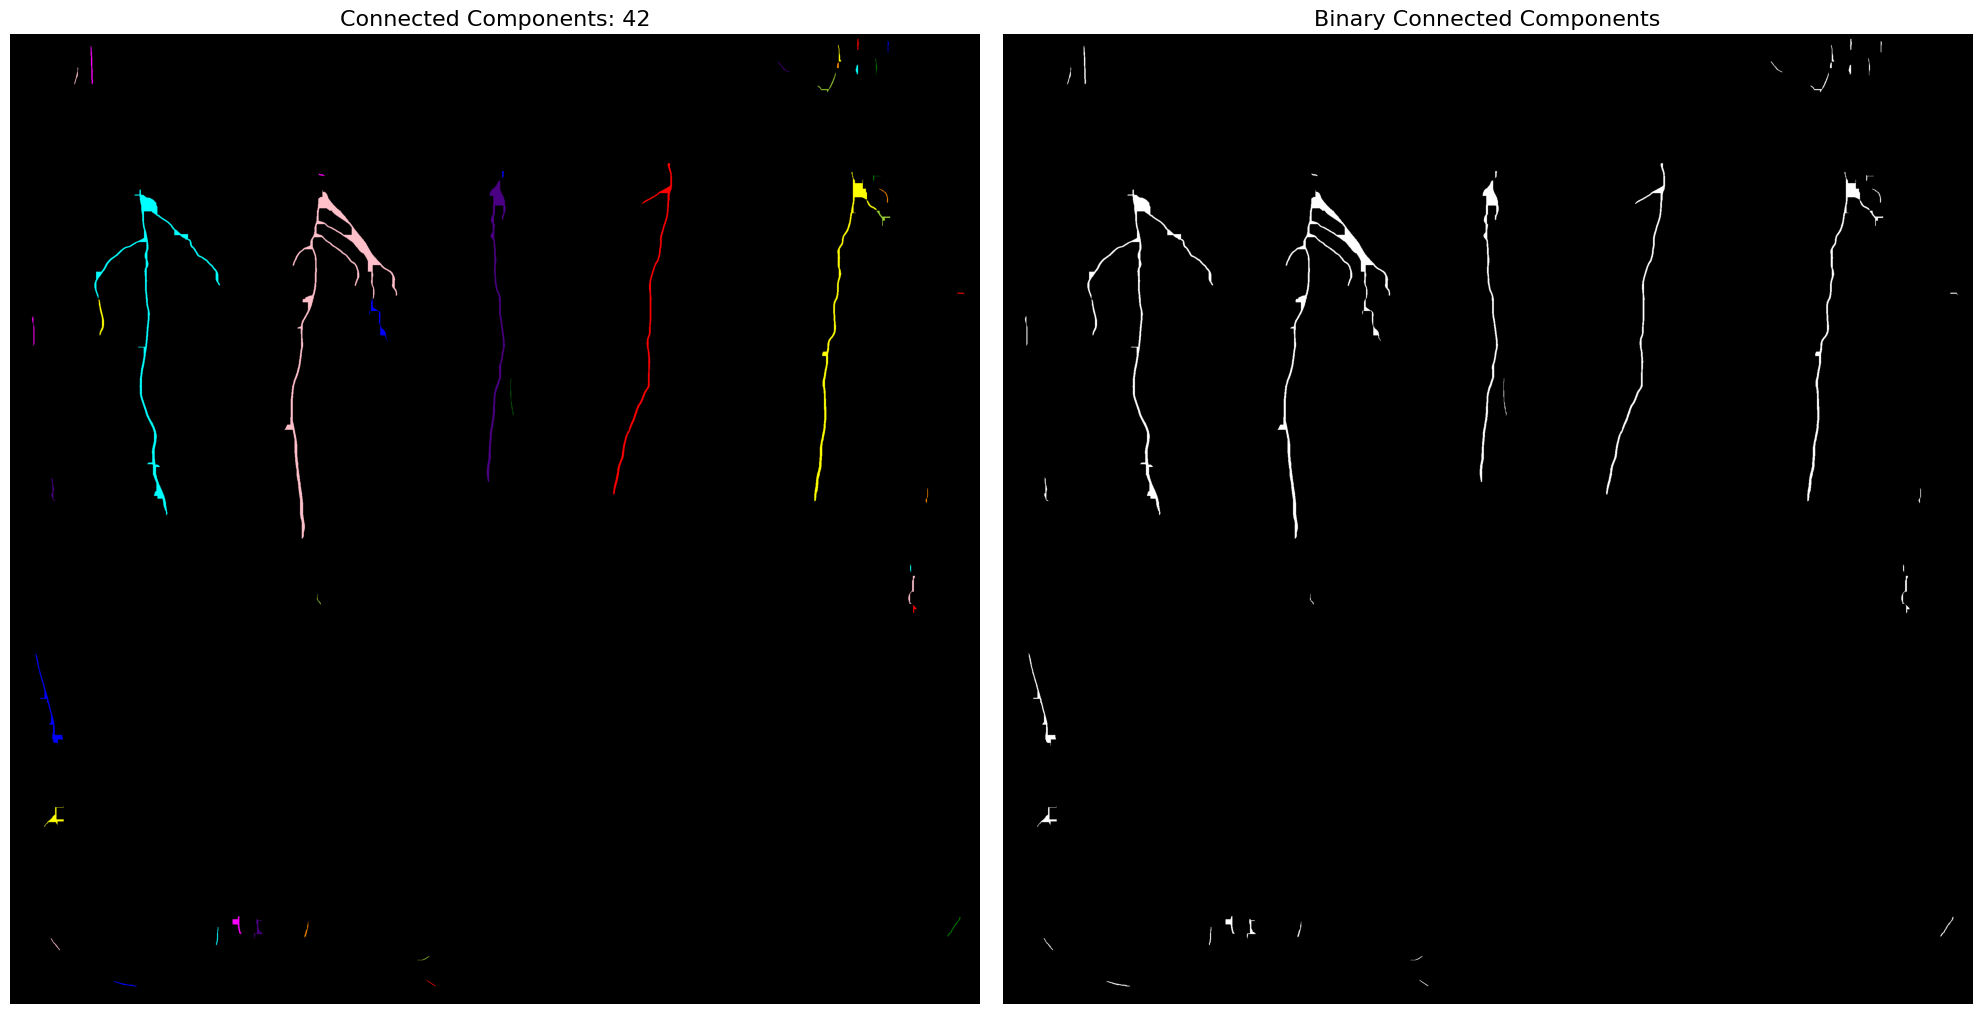

Filename: test_image_13.png | Number of connected components: 27


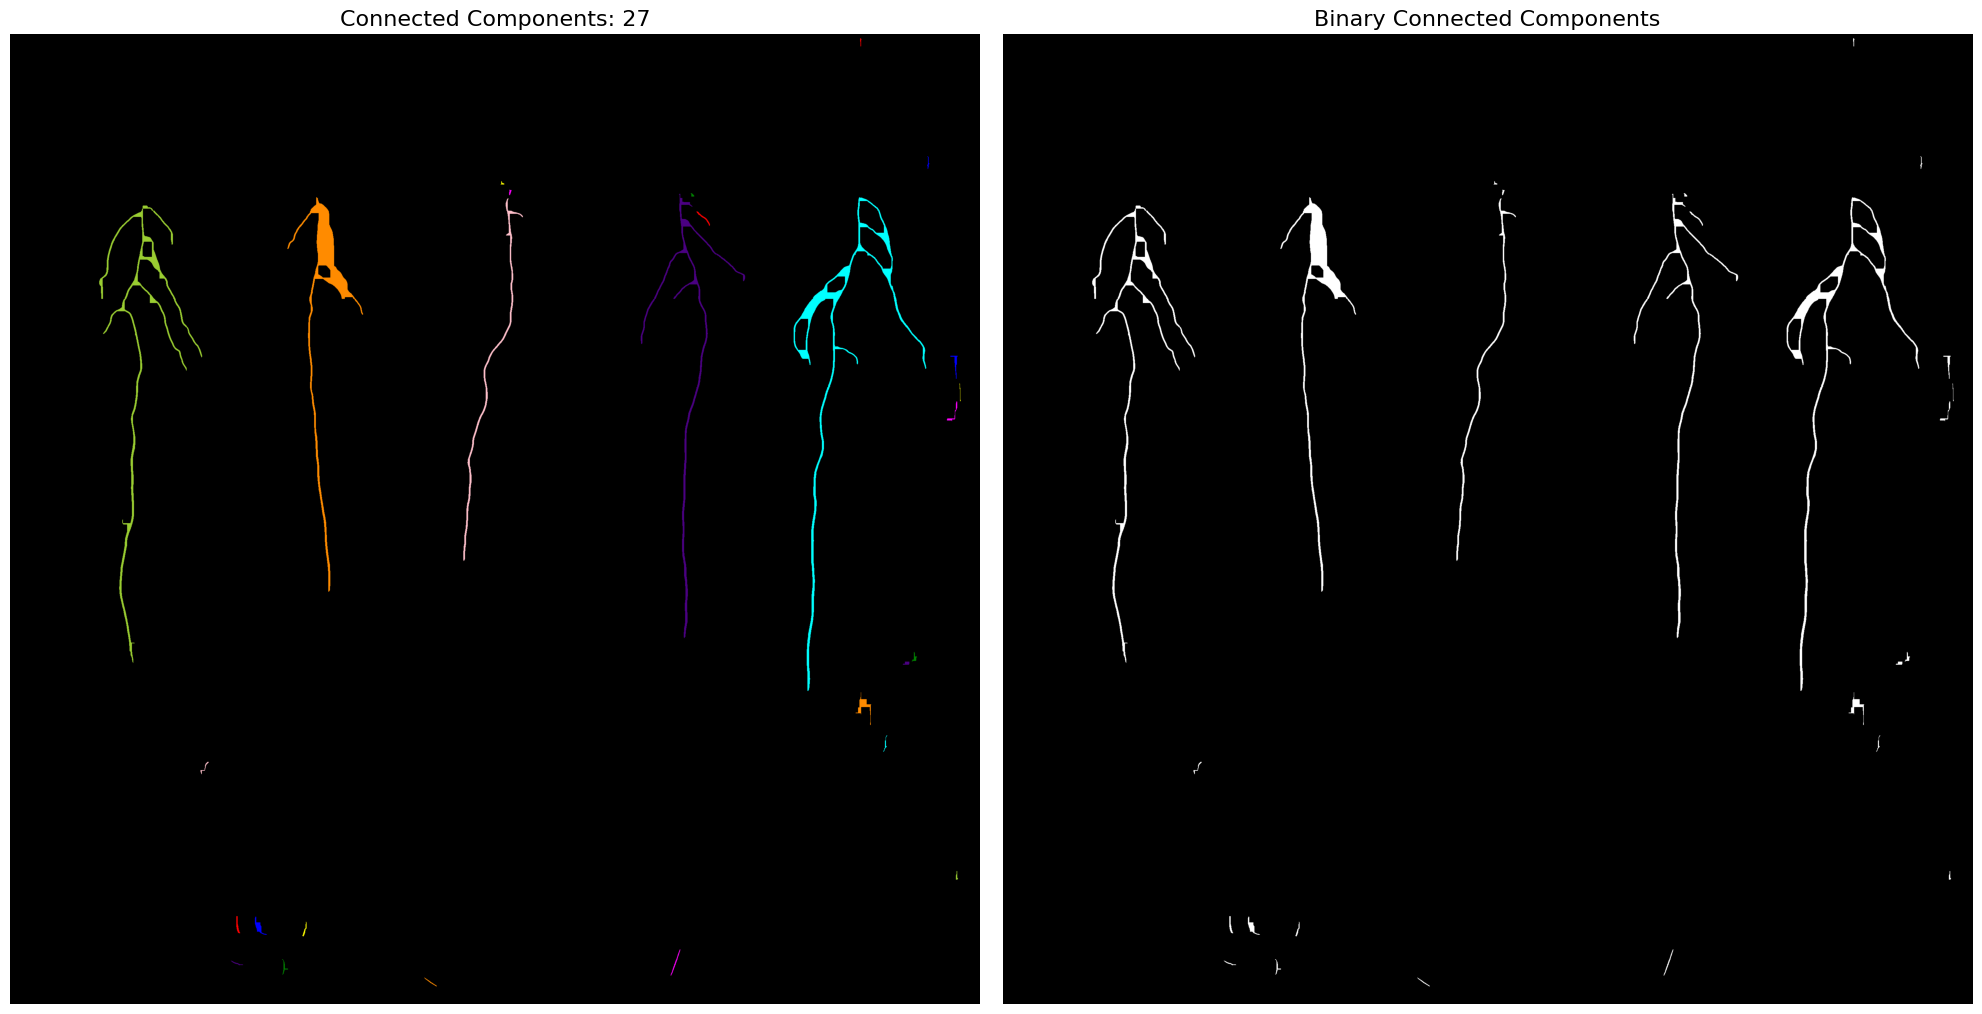

Filename: test_image_14.png | Number of connected components: 64


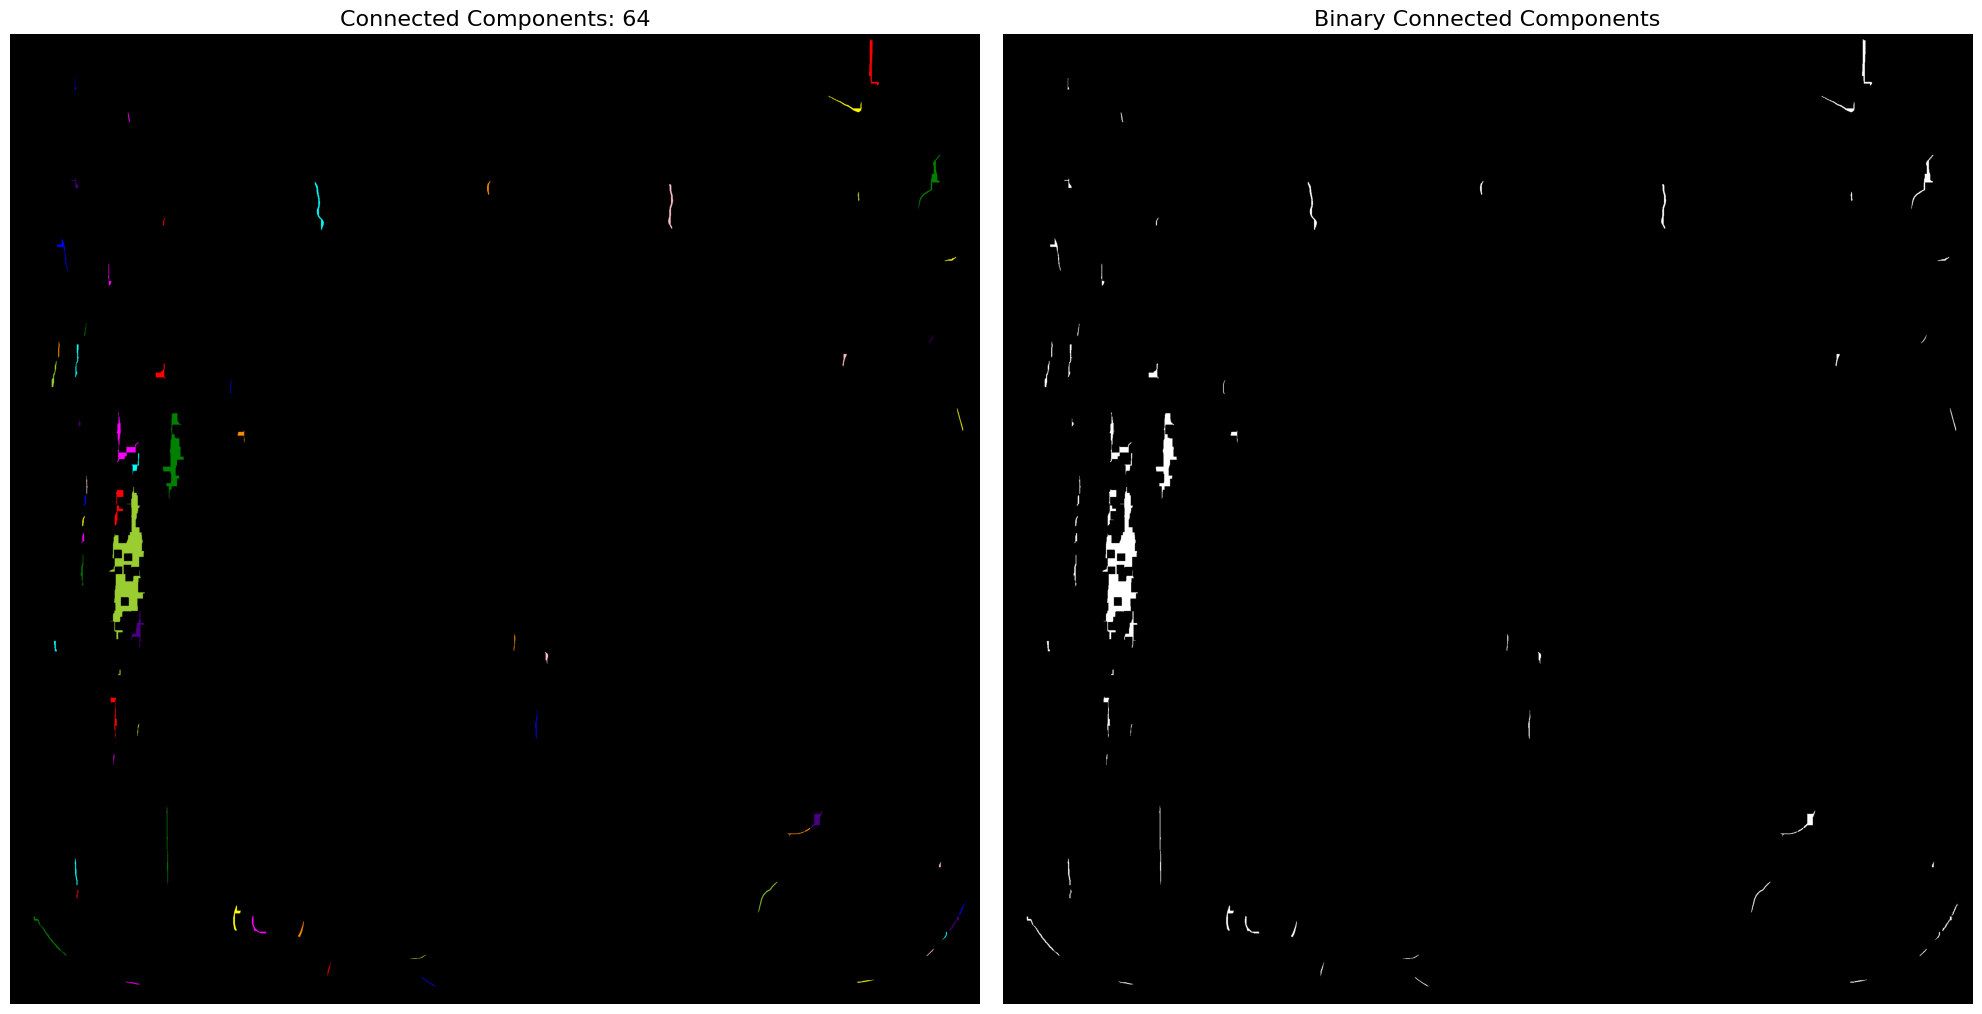

Filename: test_image_15.png | Number of connected components: 90


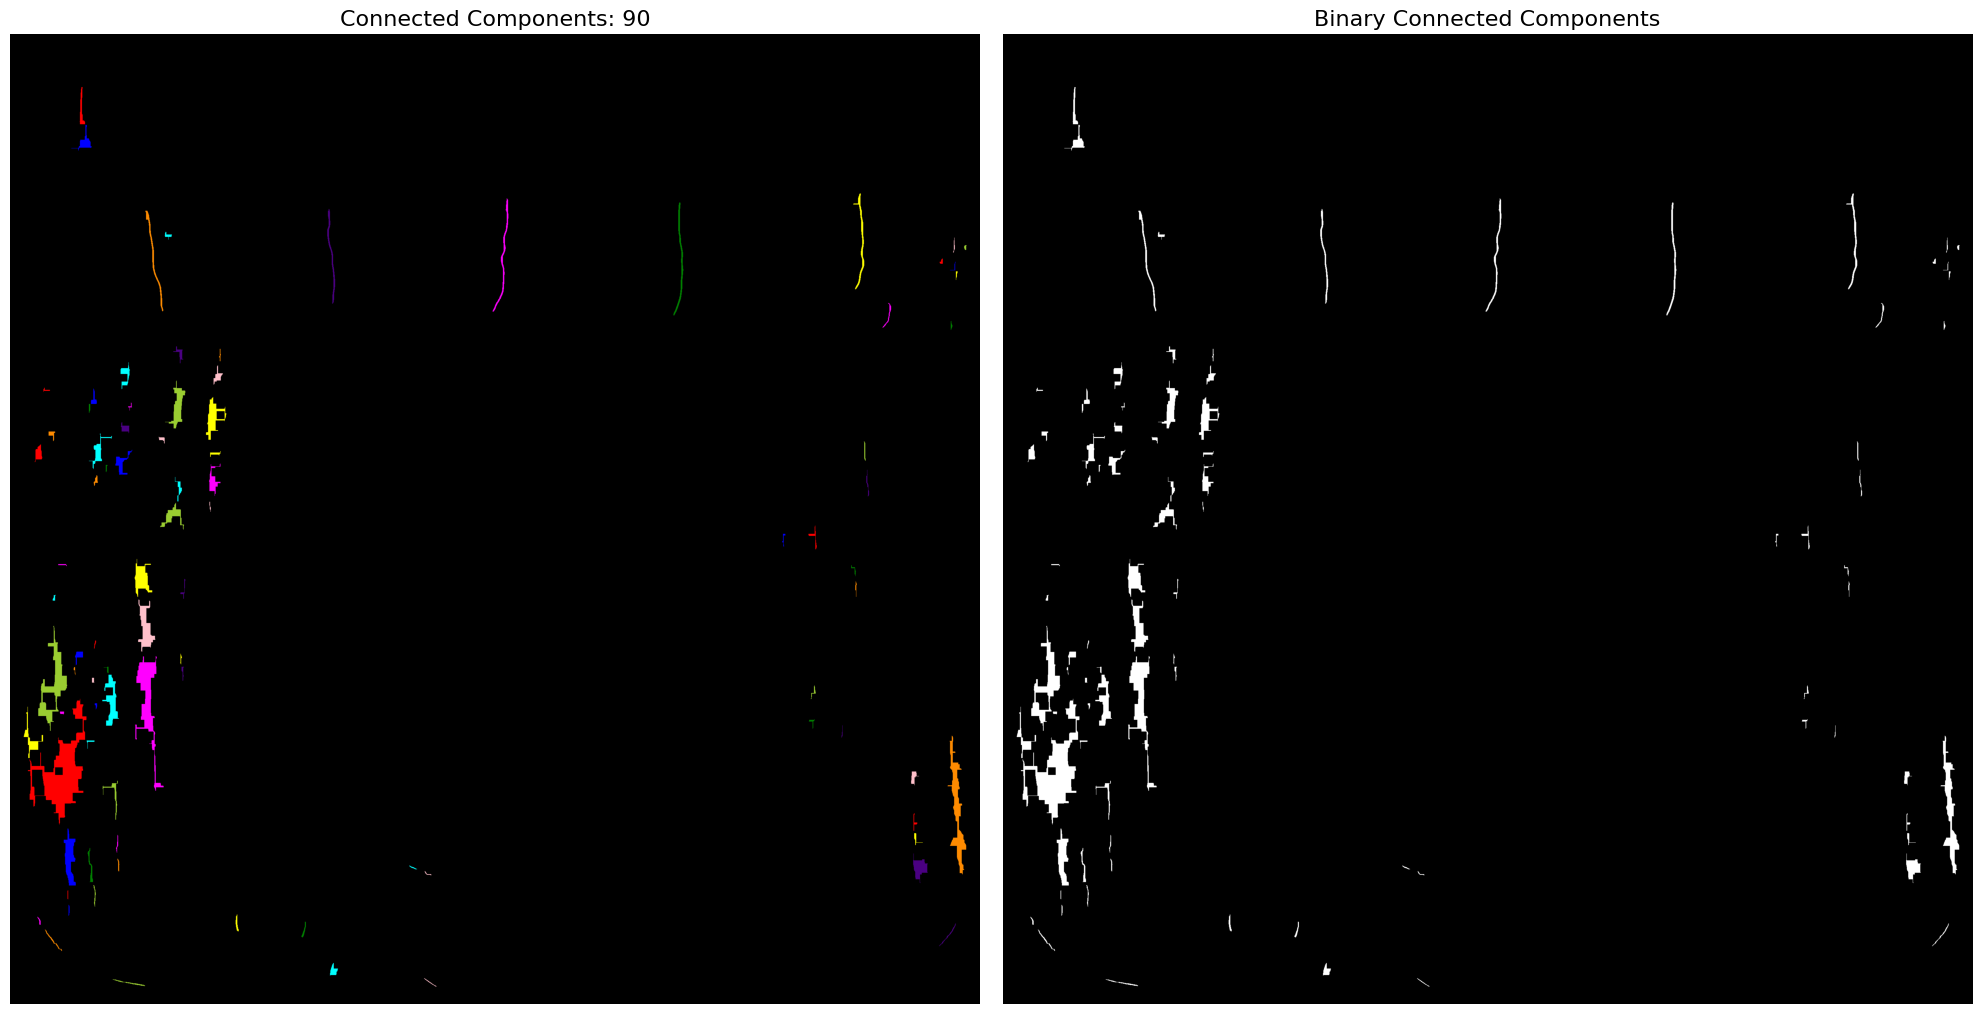

Filename: test_image_16.png | Number of connected components: 39


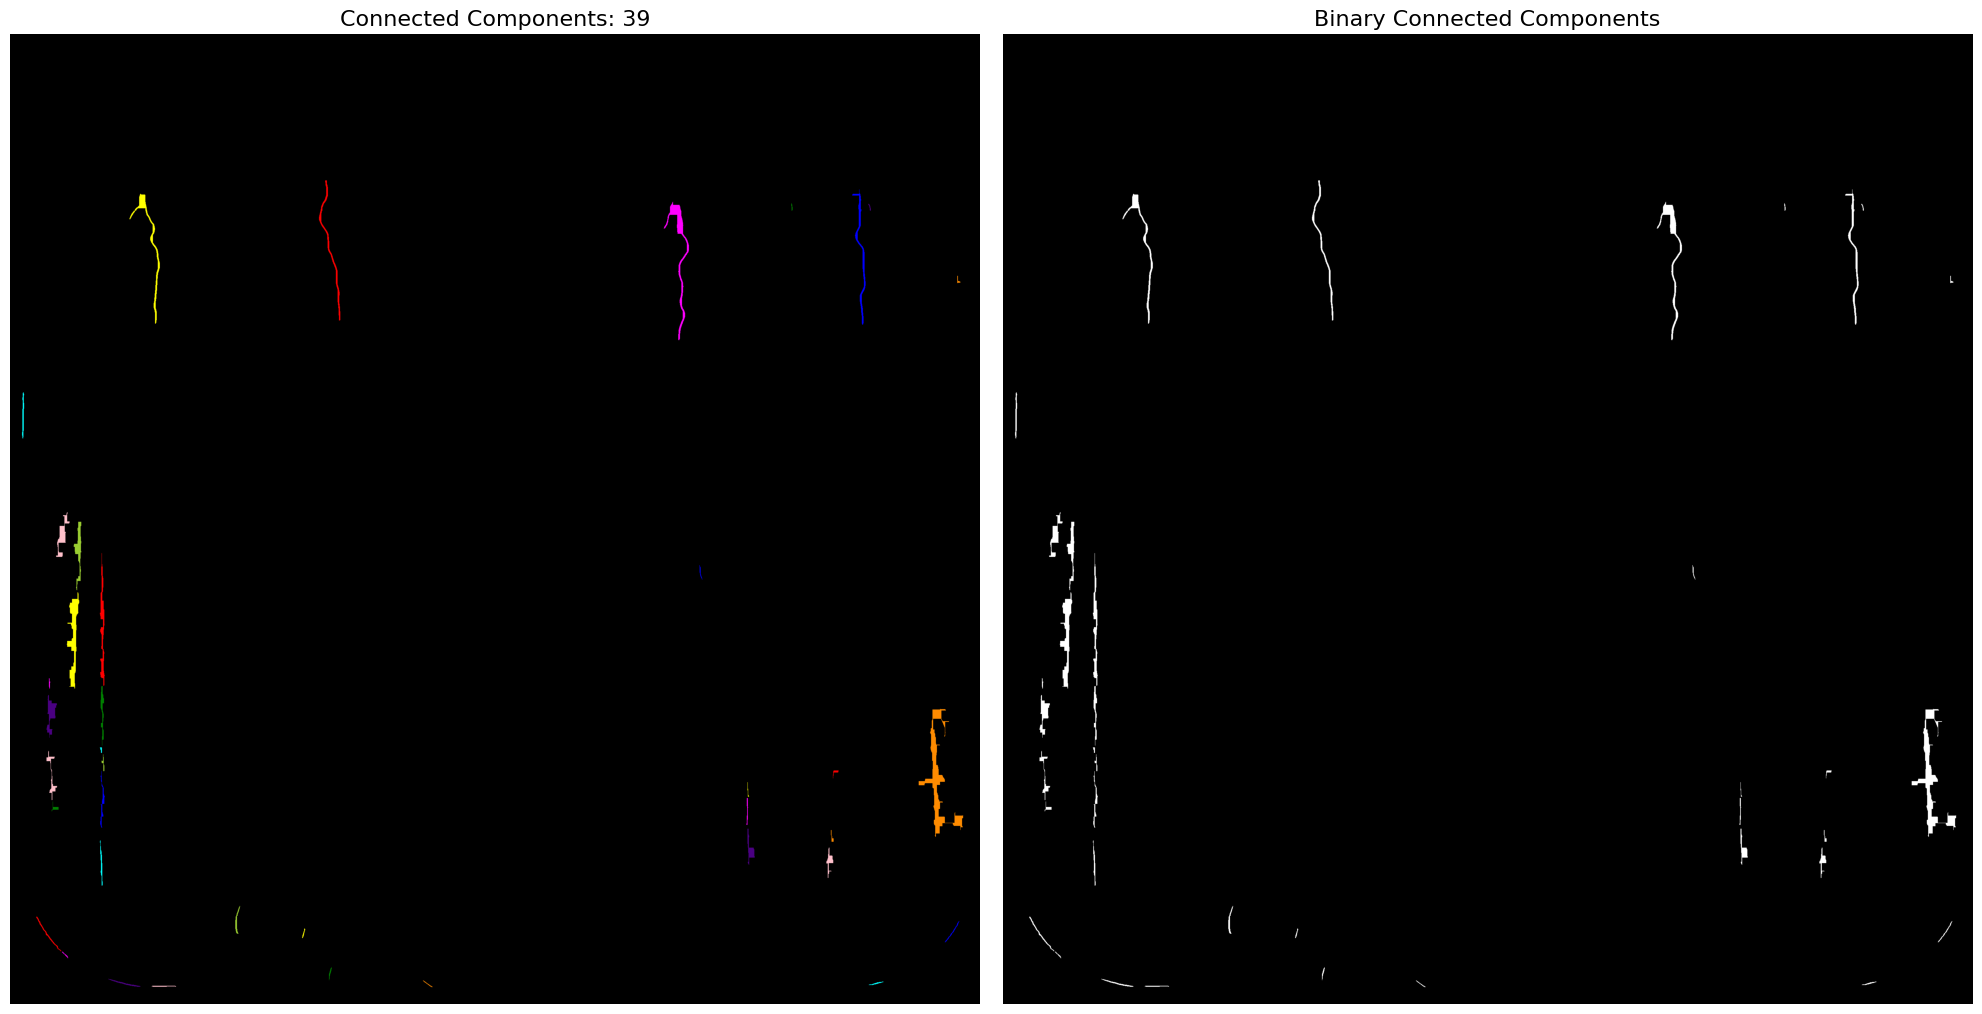

Filename: test_image_17.png | Number of connected components: 15


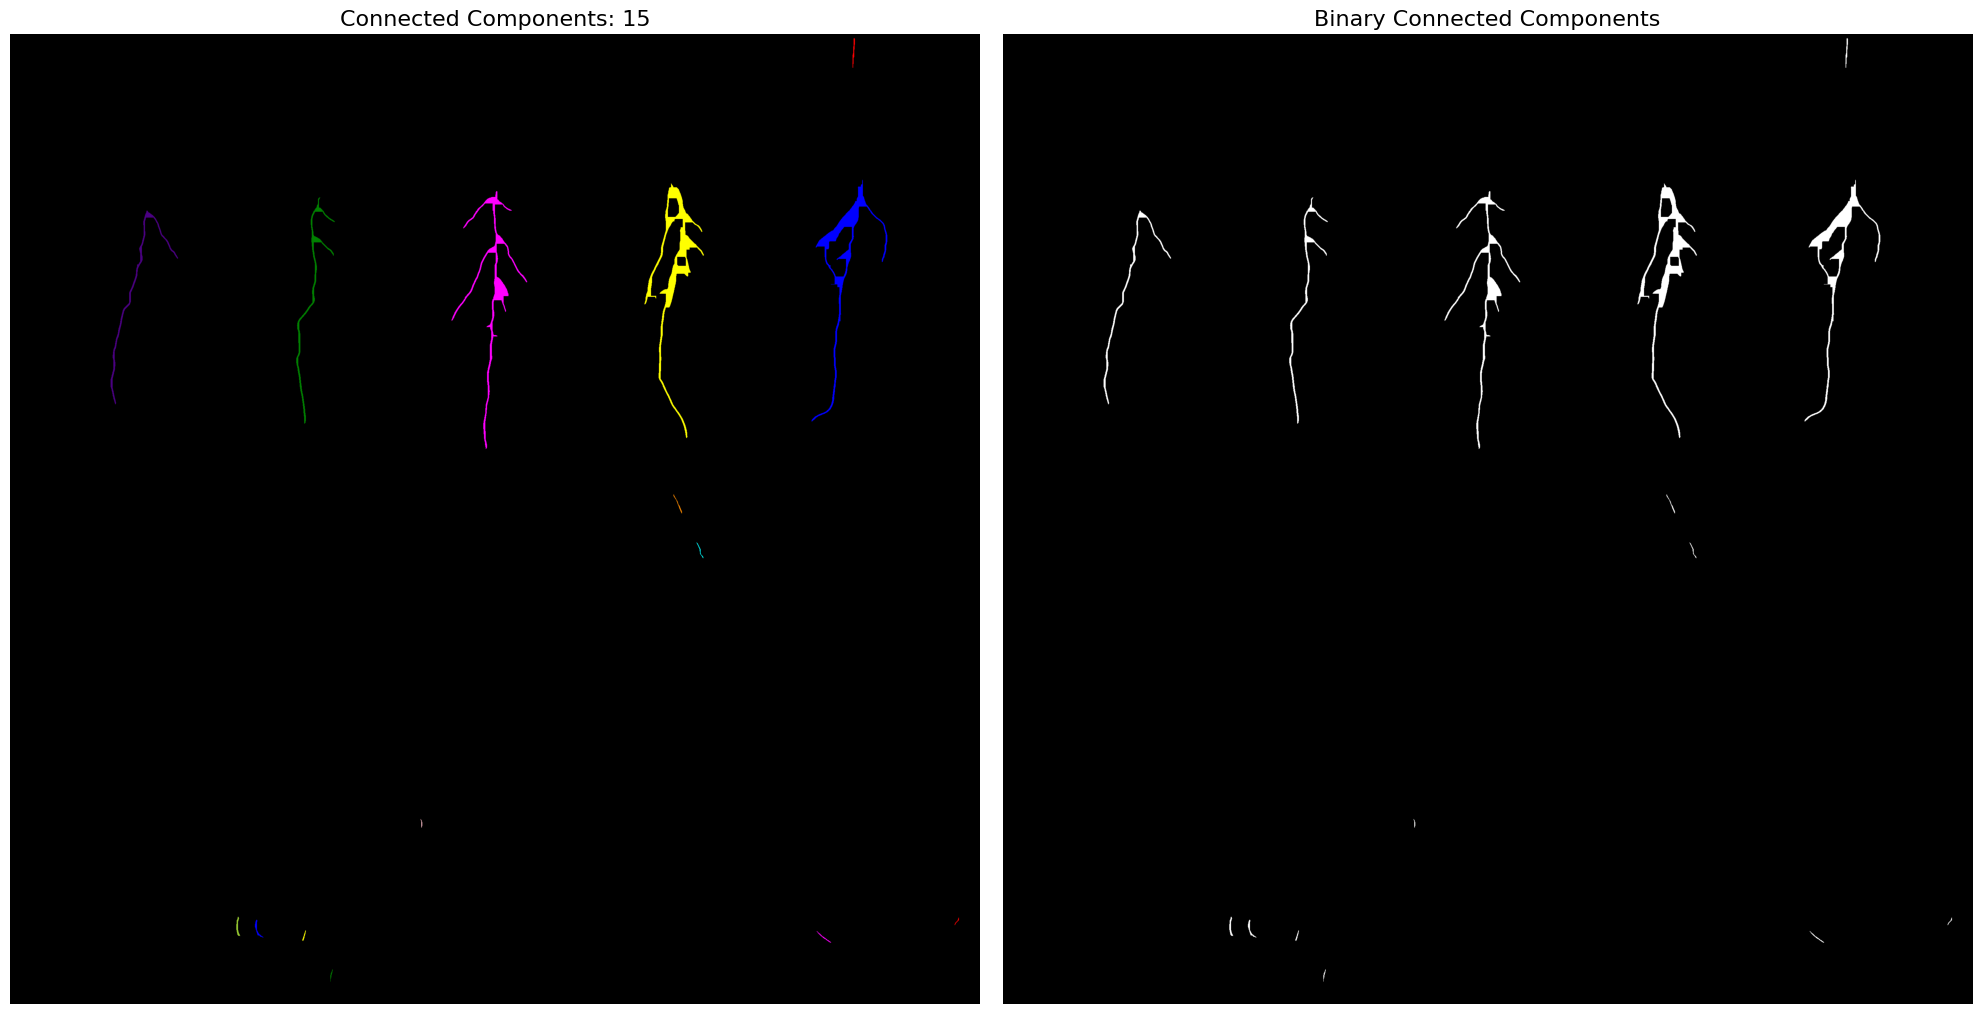

Filename: test_image_18.png | Number of connected components: 44


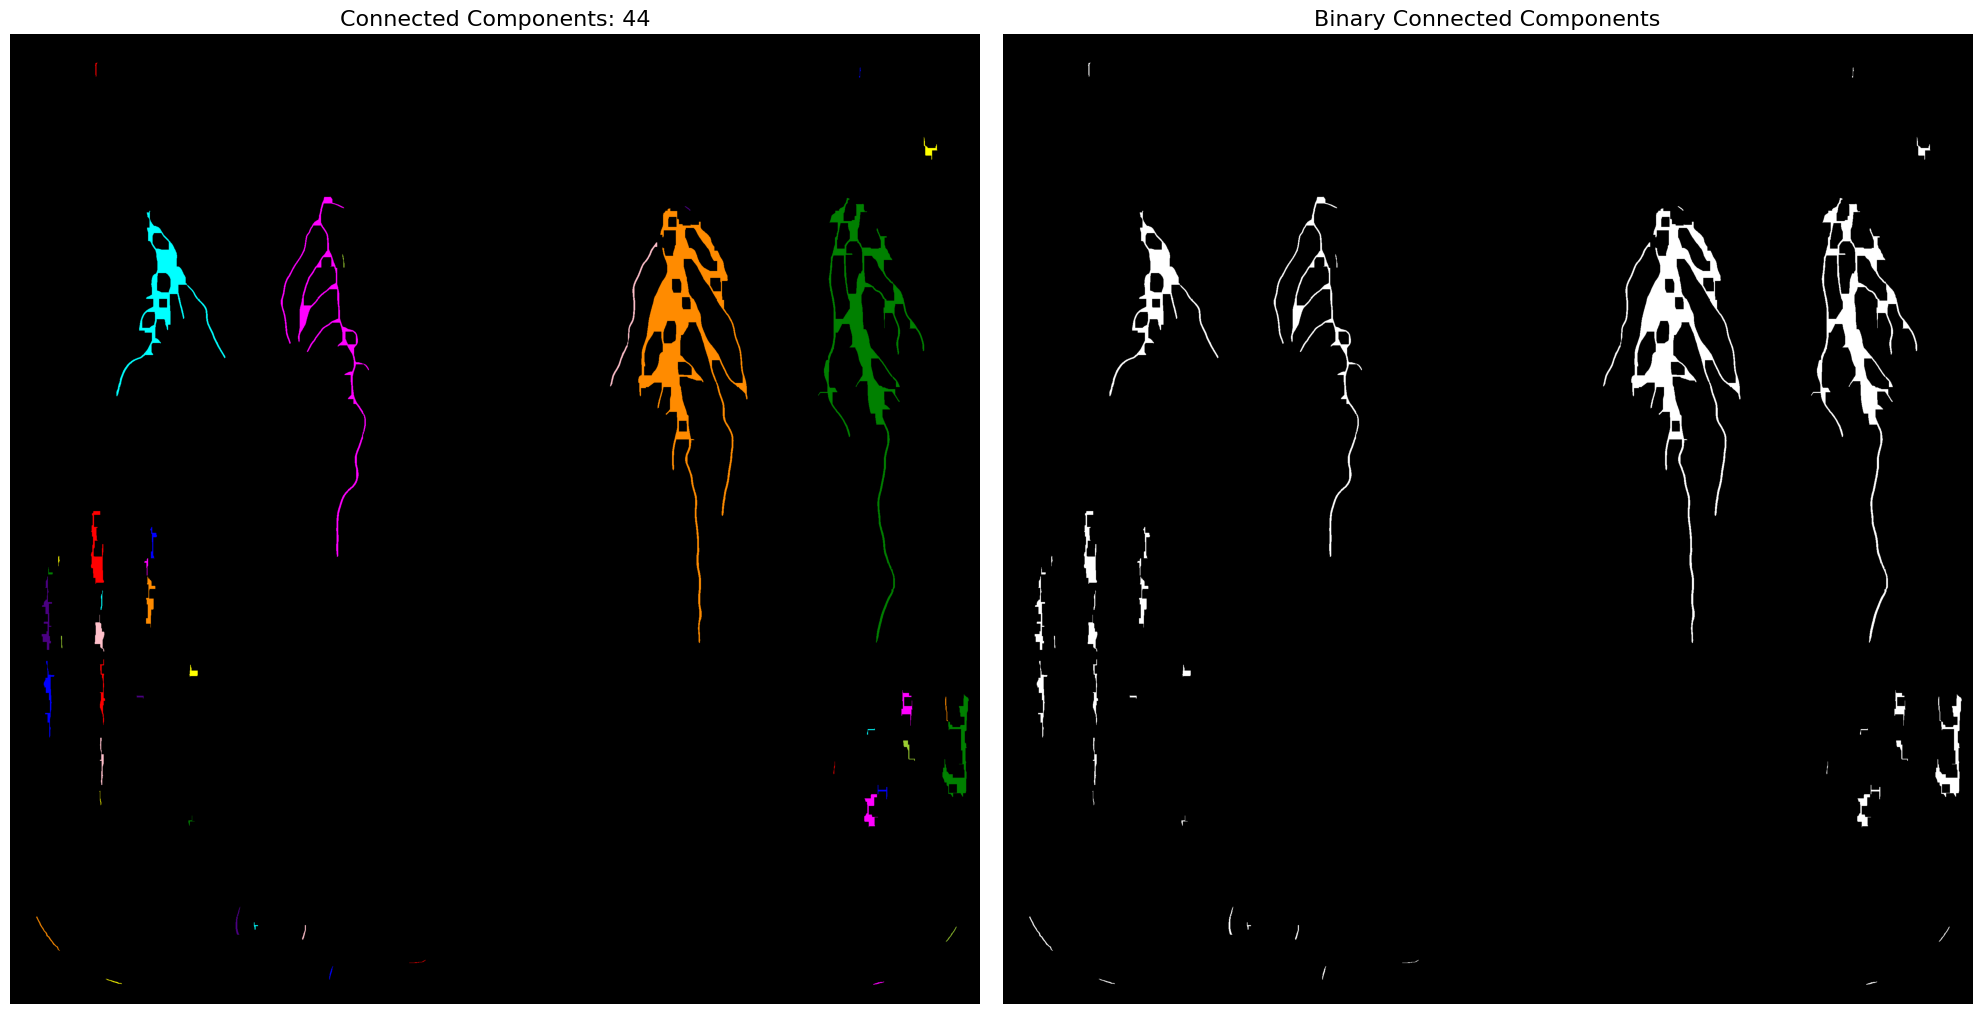

Filename: test_image_2.png | Number of connected components: 17


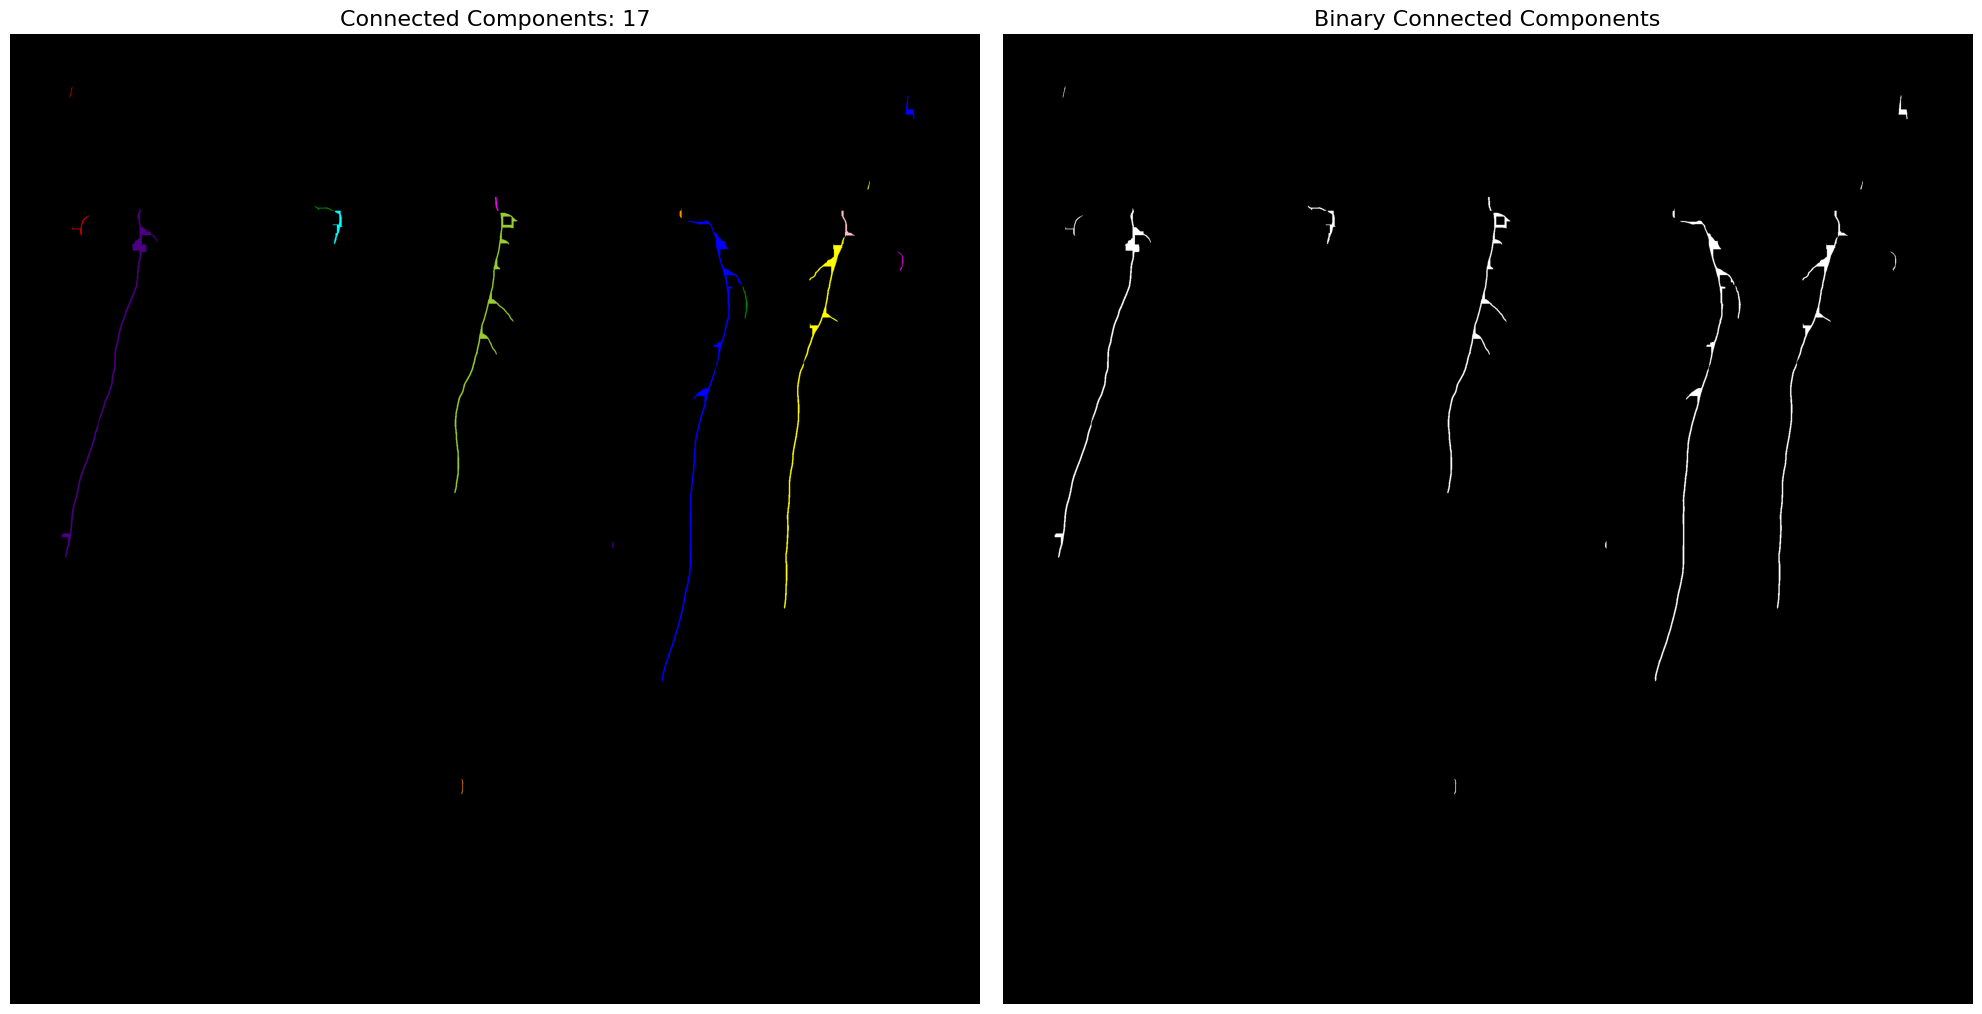

Filename: test_image_3.png | Number of connected components: 8


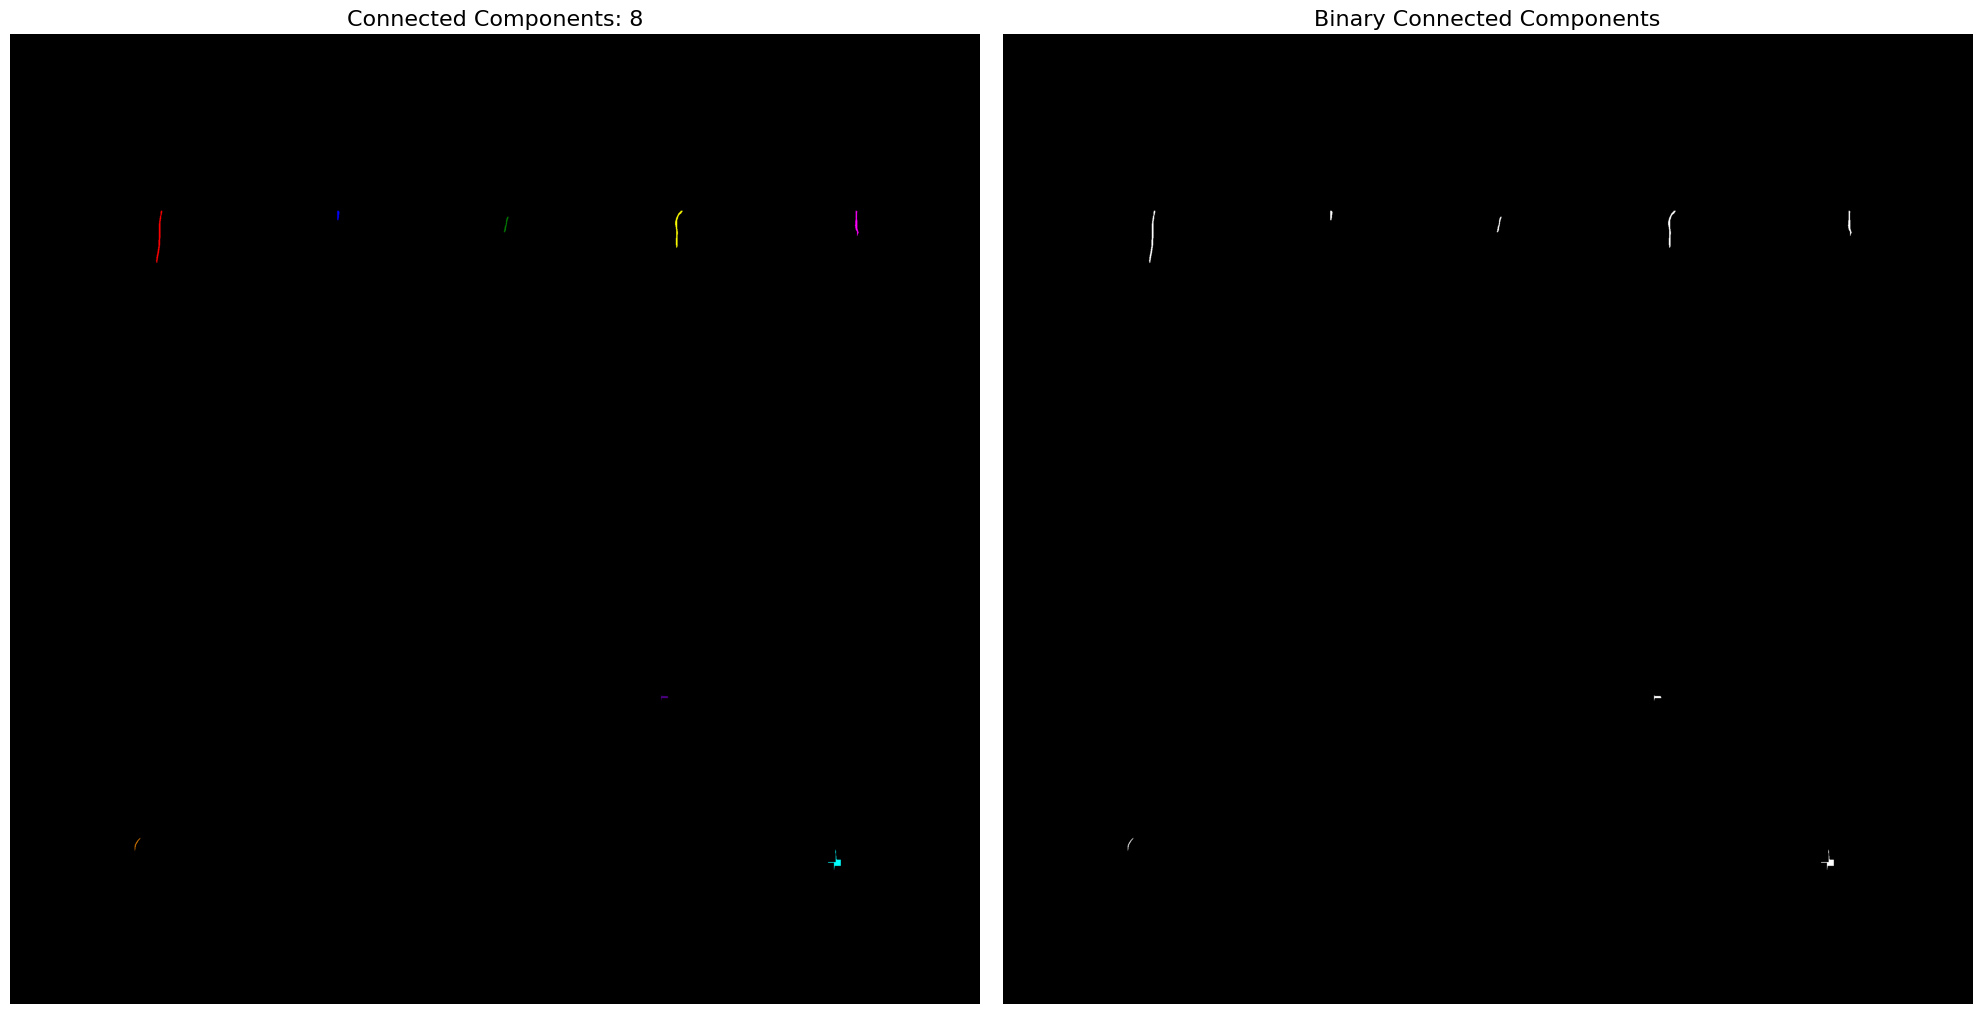

Filename: test_image_4.png | Number of connected components: 7


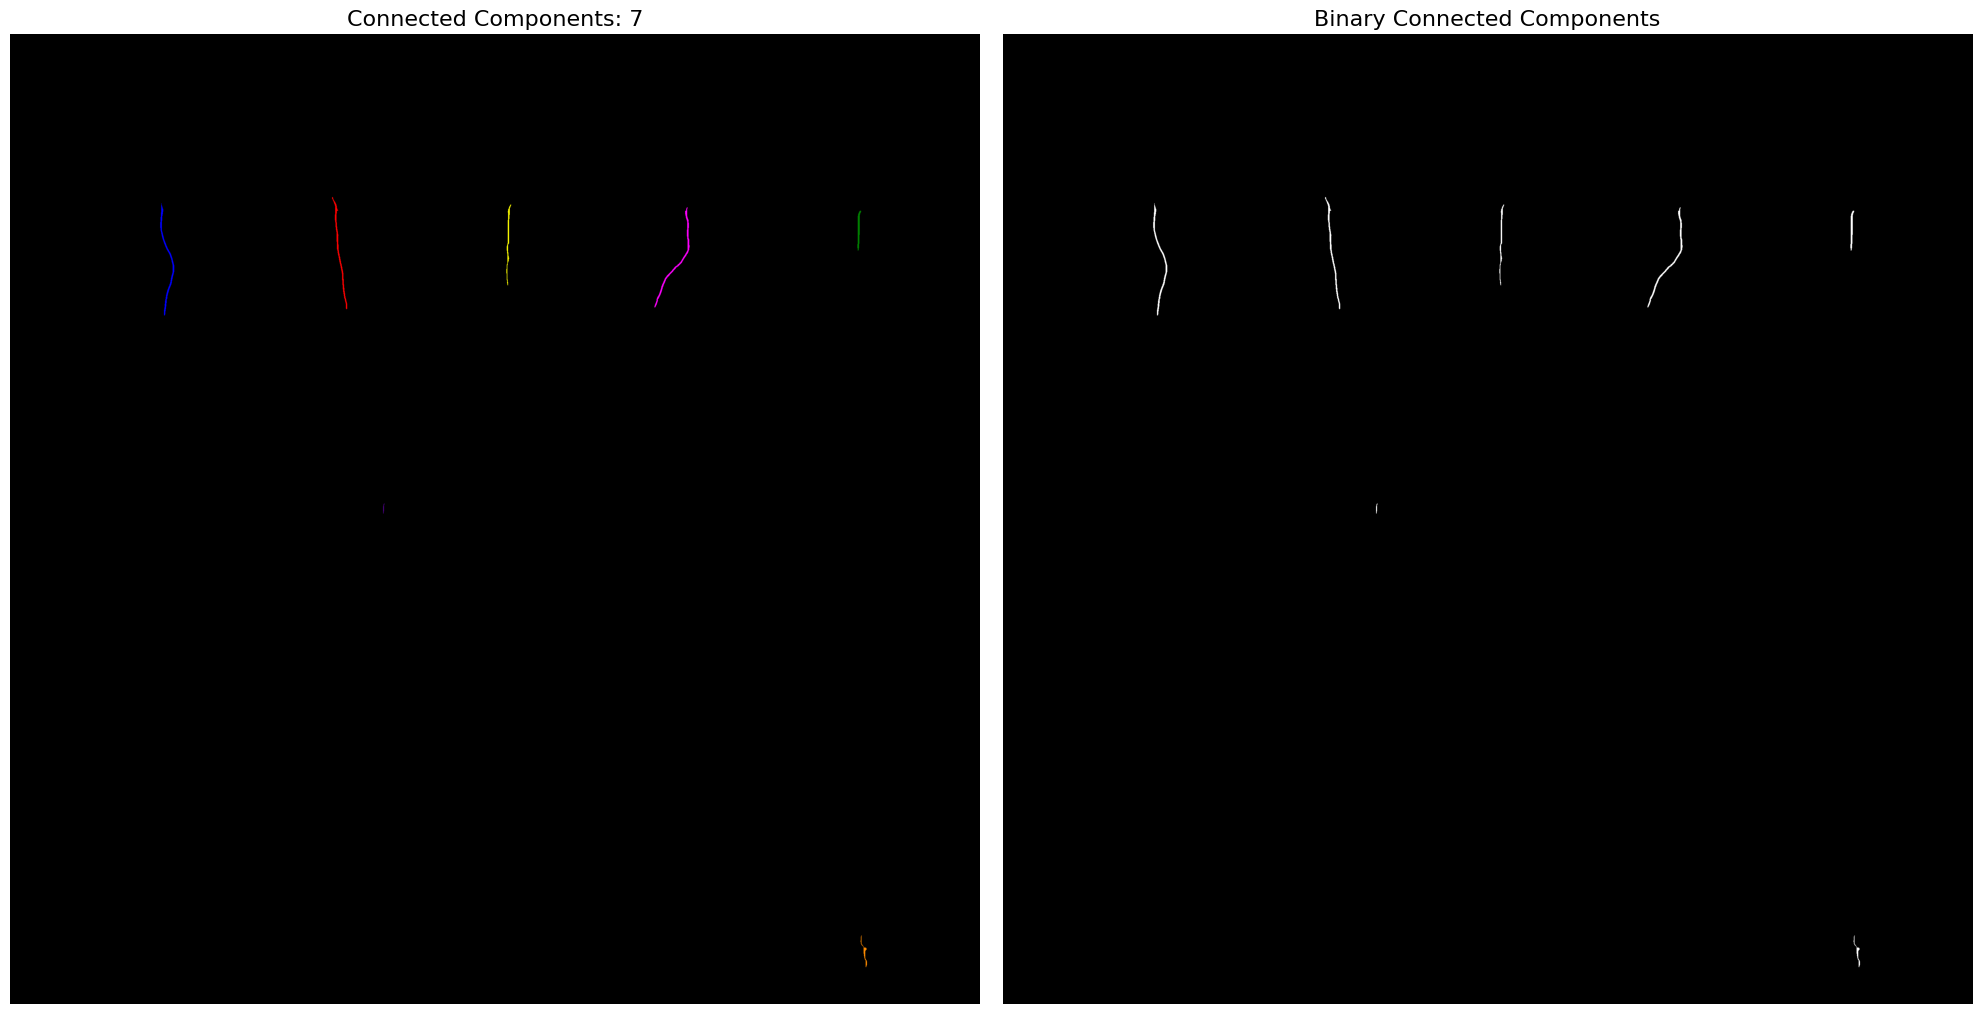

Filename: test_image_5.png | Number of connected components: 7


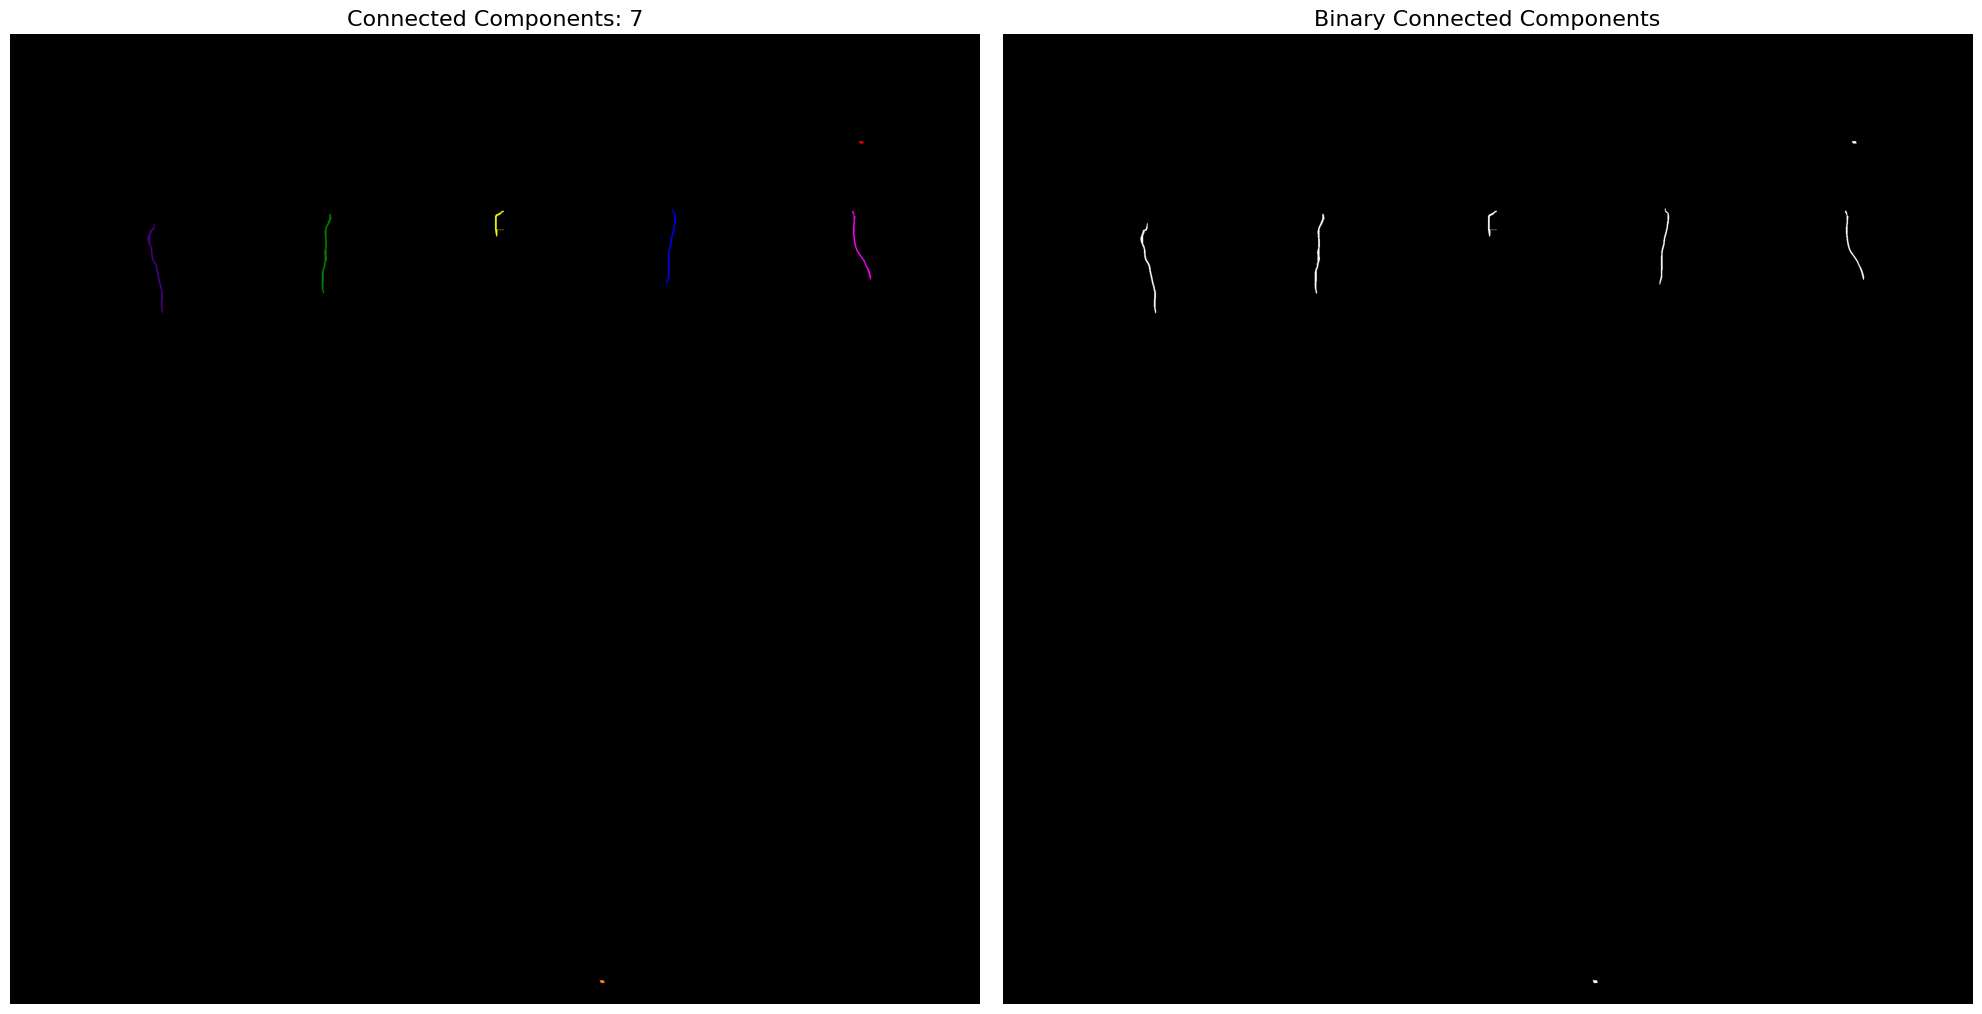

Filename: test_image_6.png | Number of connected components: 10


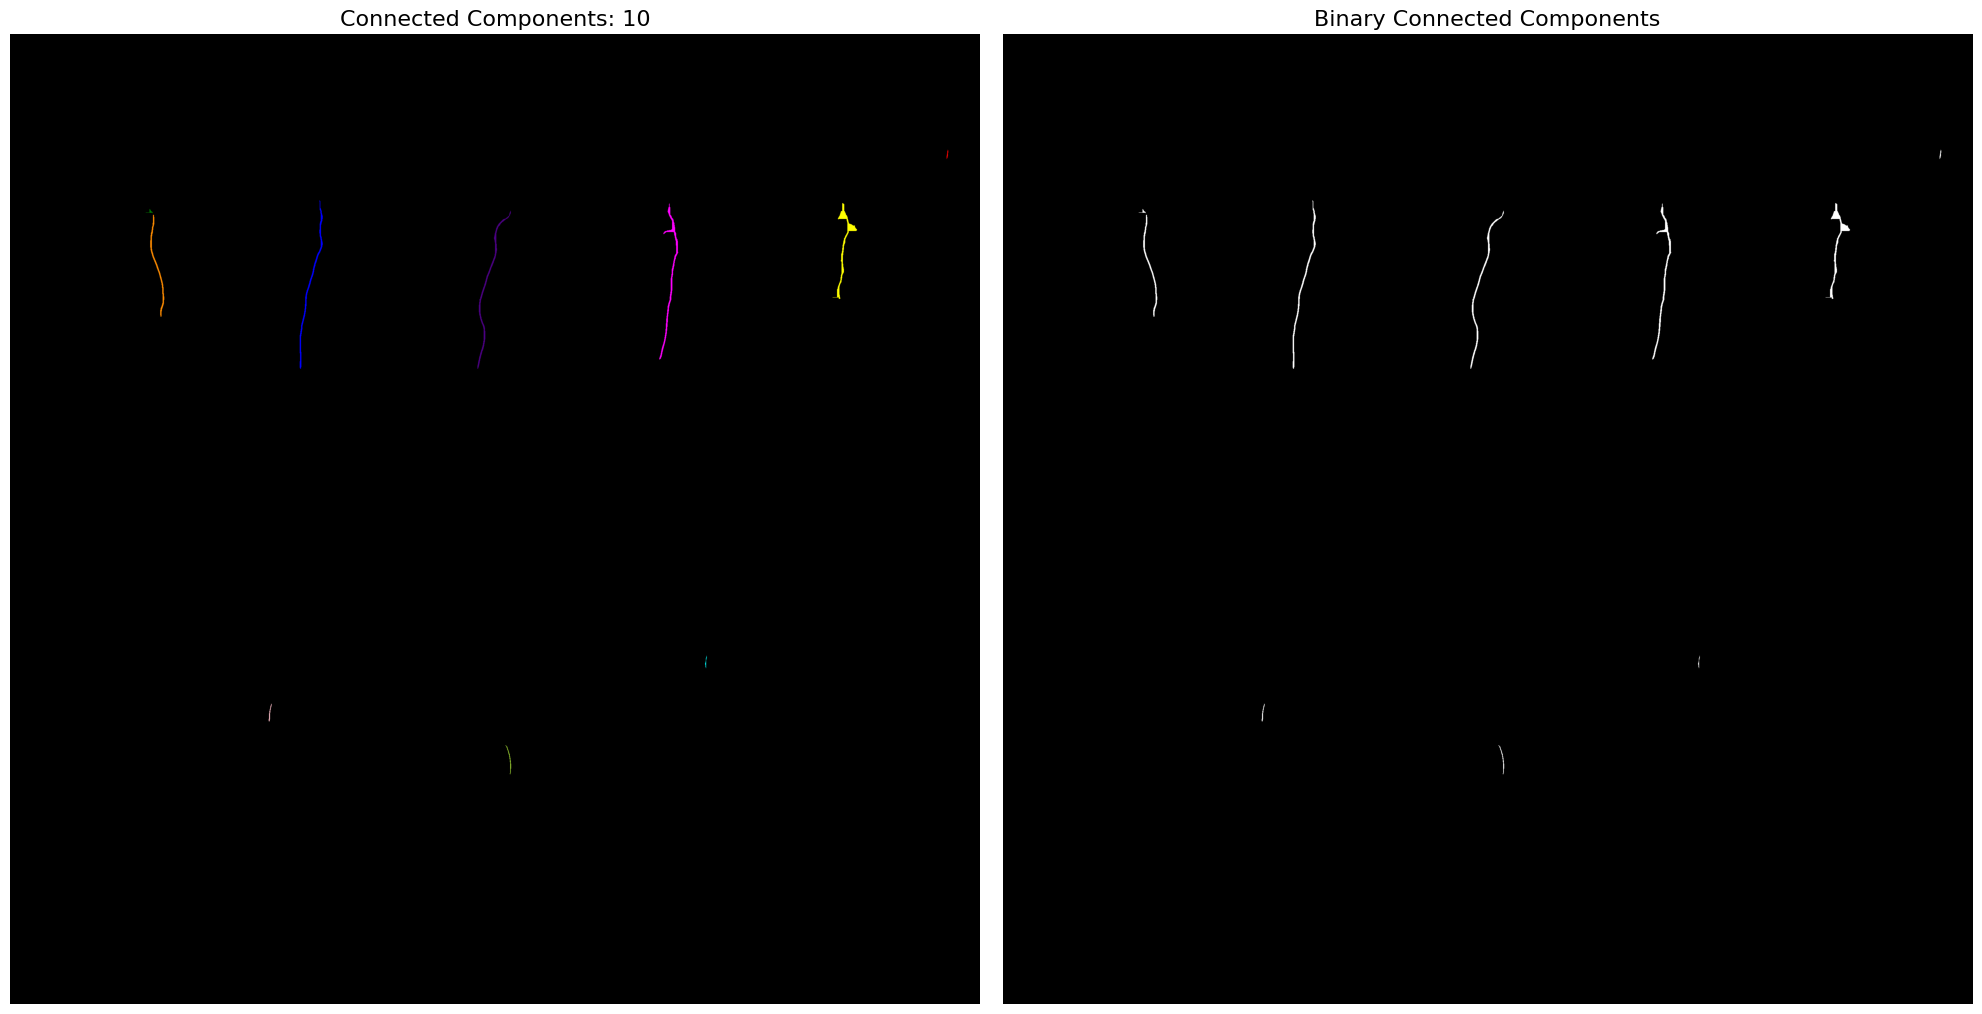

Filename: test_image_7.png | Number of connected components: 7


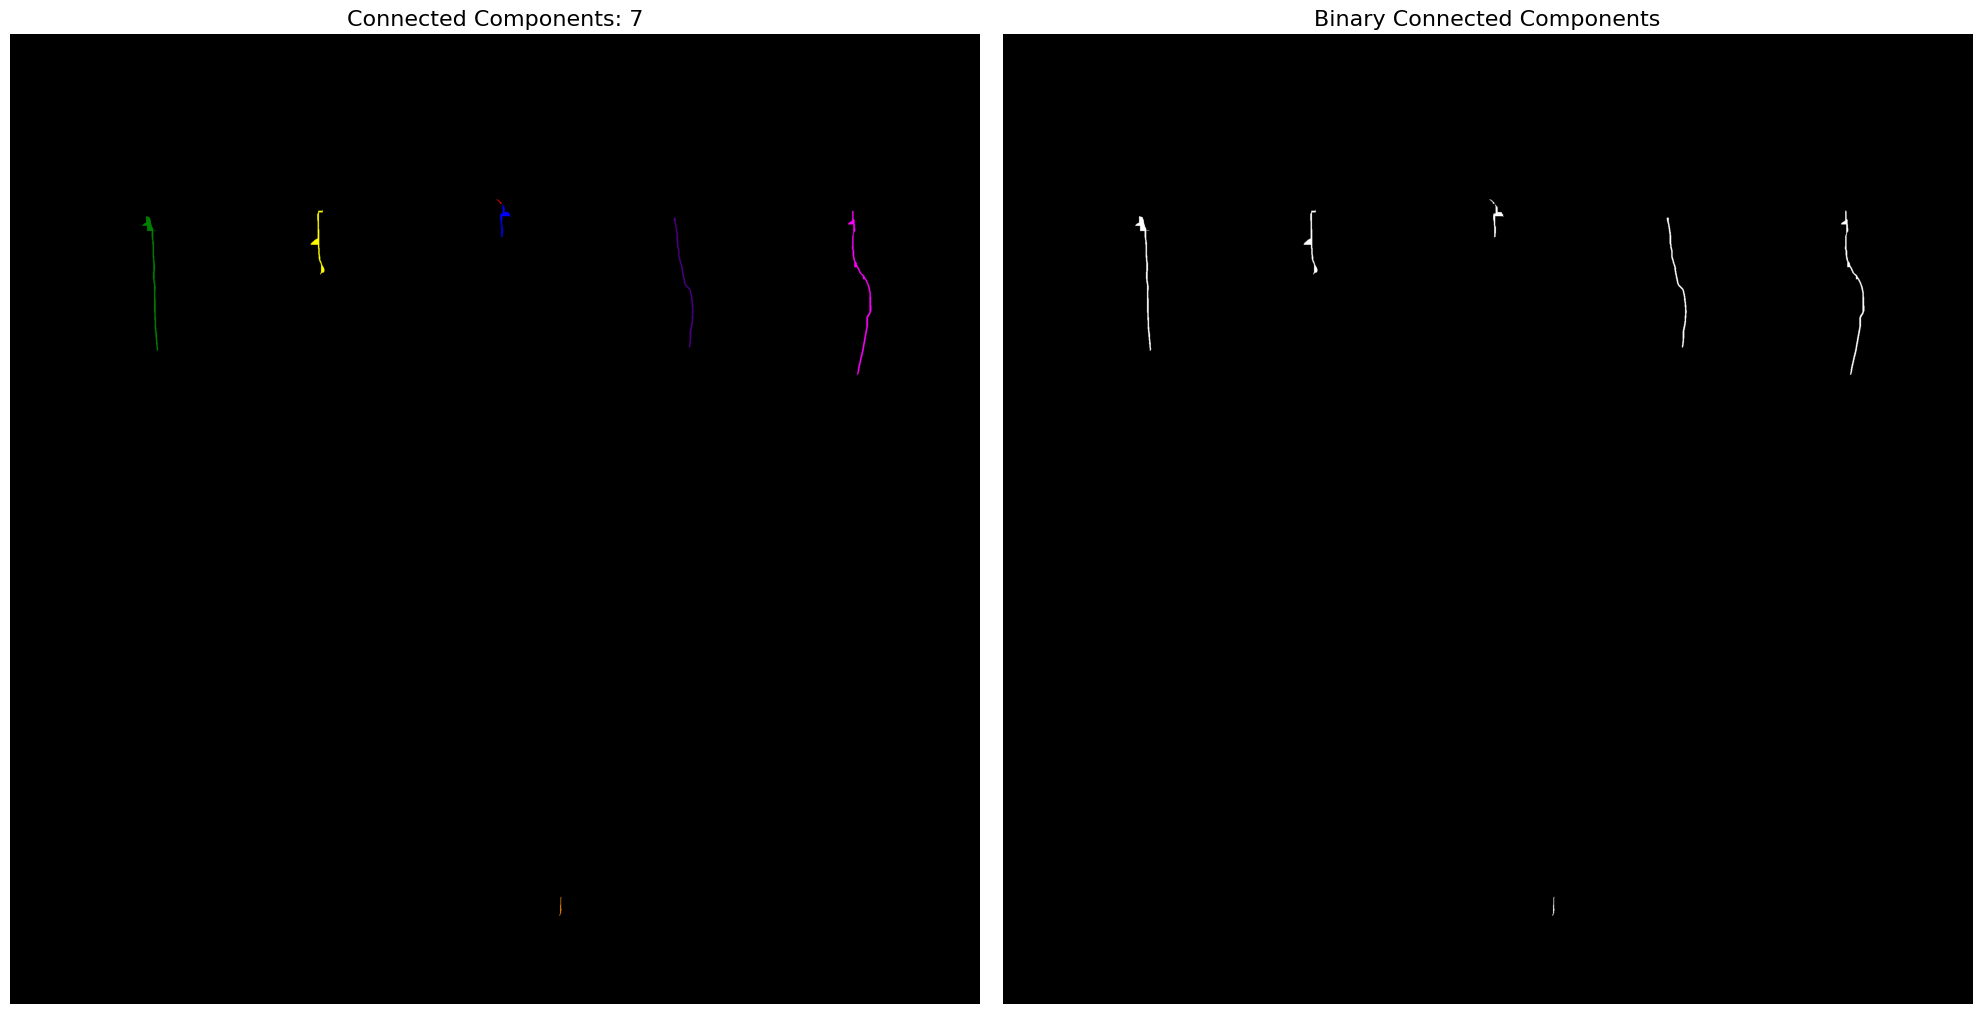

Filename: test_image_8.png | Number of connected components: 23


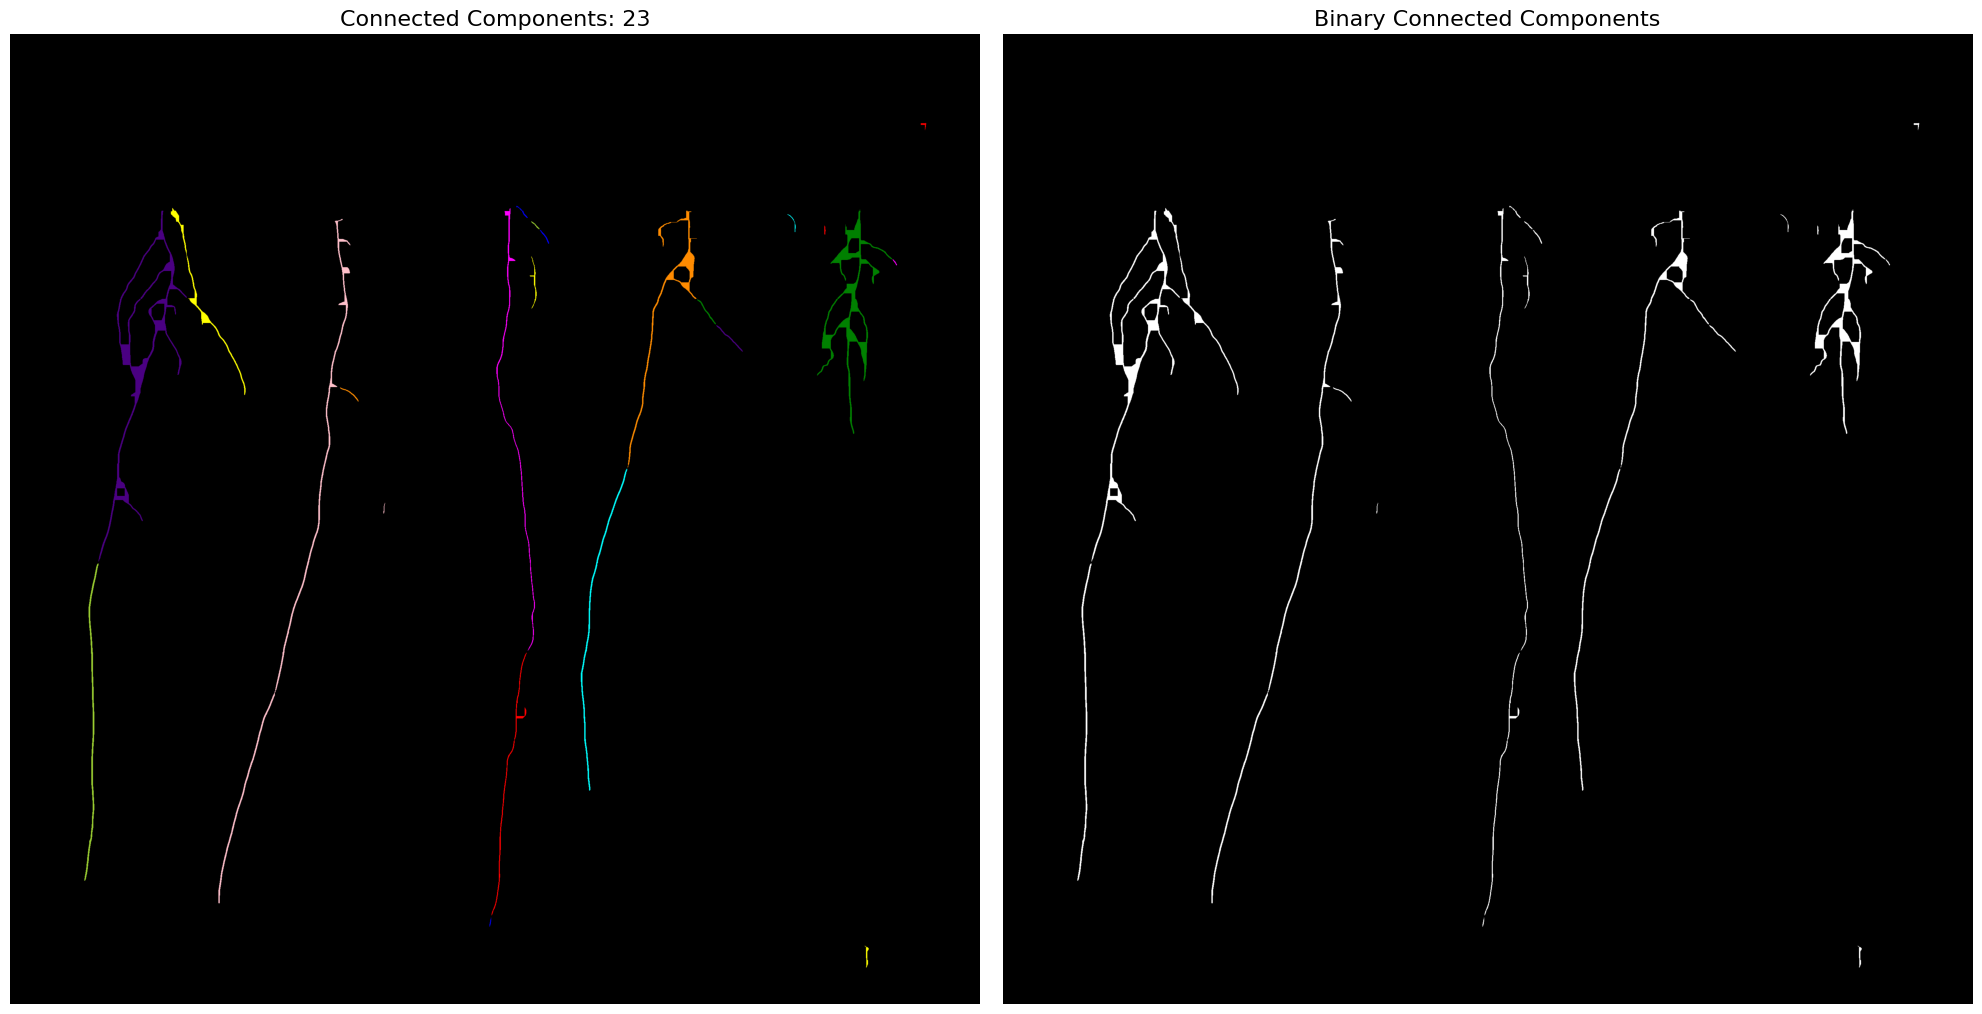

Filename: test_image_9.png | Number of connected components: 32


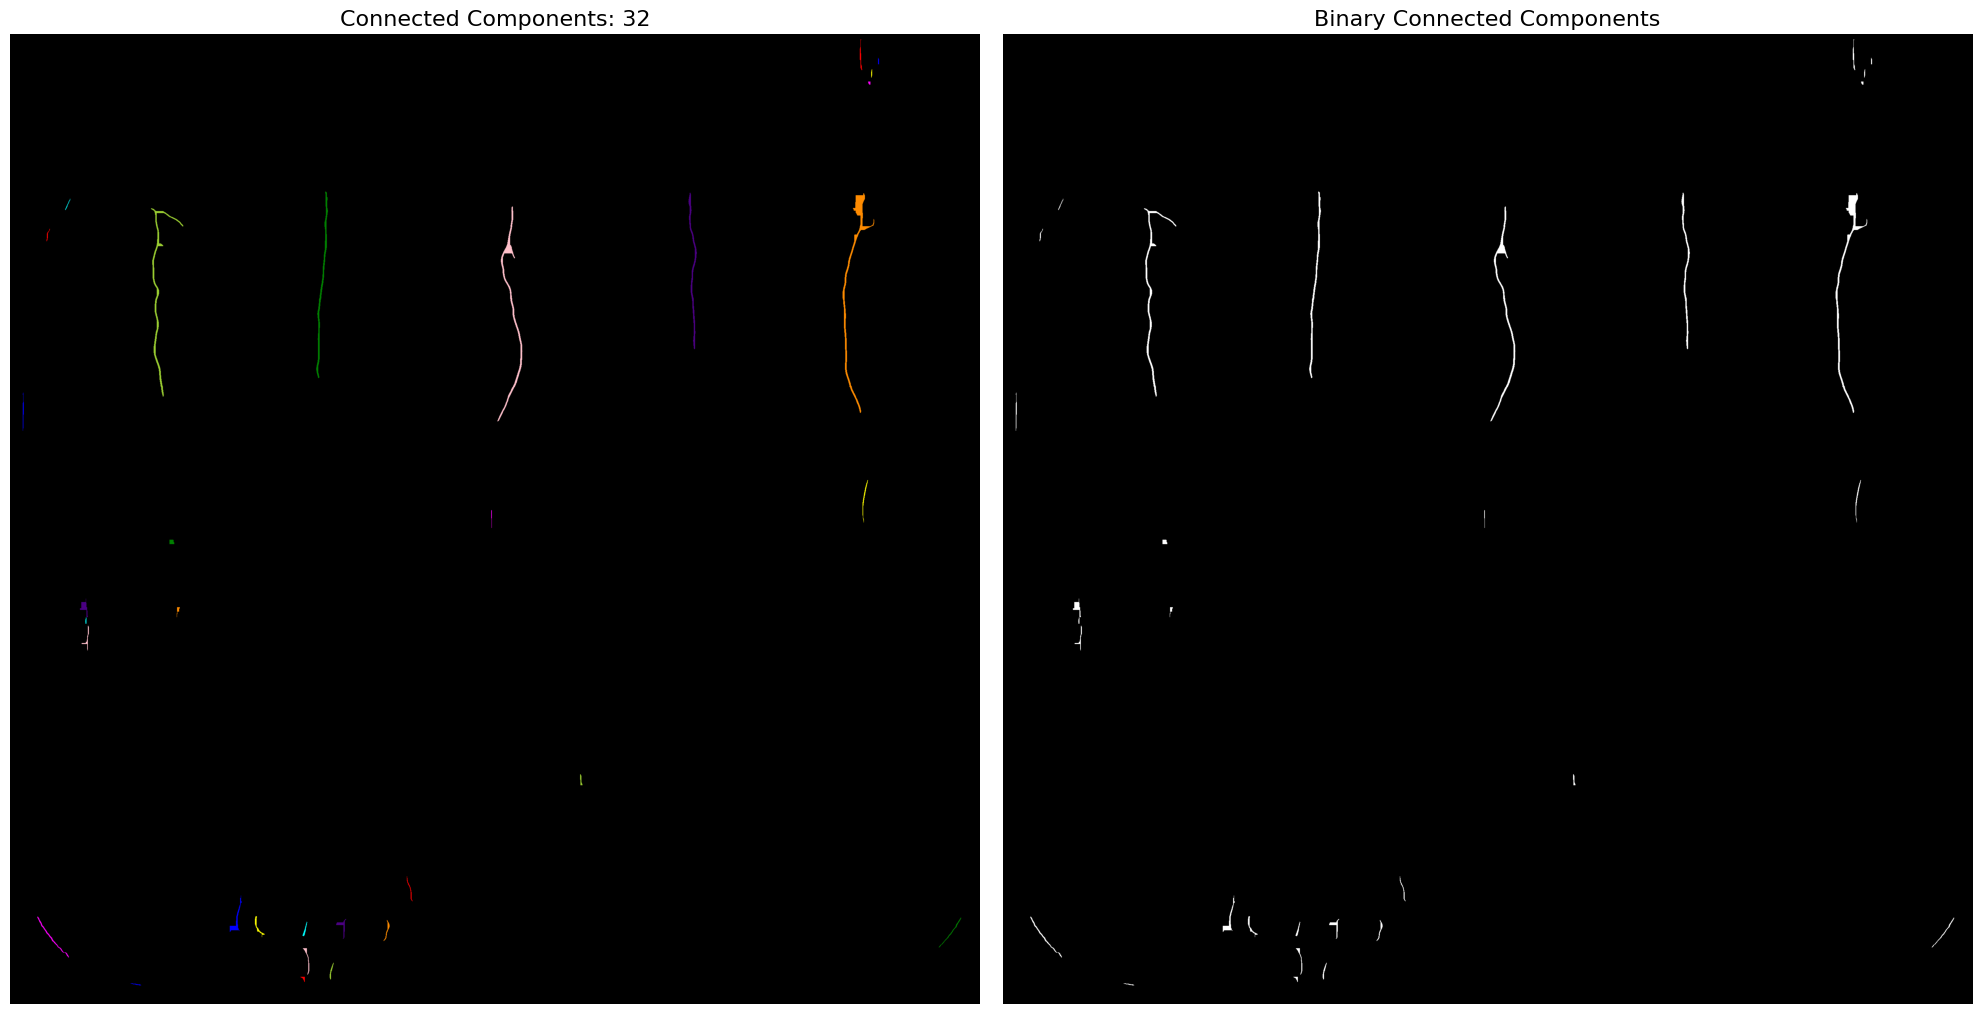

In [17]:
from skimage.measure import label
from skimage.color import label2rgb
import matplotlib.pyplot as plt

# Process connected components for each cleaned mask
for filename, cleaned_mask in processed_masks:
    # Step 1: Label connected components
    labeled_mask = label(cleaned_mask > 0)  # Ensure the mask is binary (True for foreground pixels)

    # Step 2: Count the number of connected components (excluding background)
    num_connected_components = labeled_mask.max()
    print(f"Filename: {filename} | Number of connected components: {num_connected_components}")

    # Step 3: Convert labeled mask to a color image for visualization
    colored_labels = label2rgb(labeled_mask, bg_label=0, bg_color=(0, 0, 0), colors=None)

    # Plot the labeled connected components
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title(f"Connected Components: {num_connected_components}", fontsize=16)
    plt.imshow(colored_labels)
    plt.axis('off')

    # Step 4: Convert labeled mask back to binary
    binary_labels = (labeled_mask > 0).astype(np.uint8) * 255  # Set all non-zero labels to 255

    # Plot the binary connected components
    plt.subplot(1, 2, 2)
    plt.title("Binary Connected Components", fontsize=16)
    plt.imshow(binary_labels, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


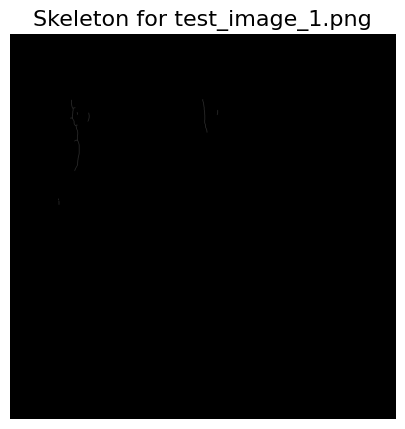

Branch data for test_image_1.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          649       257.083261            0   
1            1            5          145        68.384776            1   
2            1          123          145        17.656854            1   
3            1          145          376        72.485281            2   
4            2          173          312        37.071068            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                477               1406   
1               1.0                0.0                482                449   
2               1.0                0.0                539                476   
3               1.0                0.0                543                460   
4               1.0                0.0                556               1515   

   image-coord-dst-0  image-coord-dst-1 

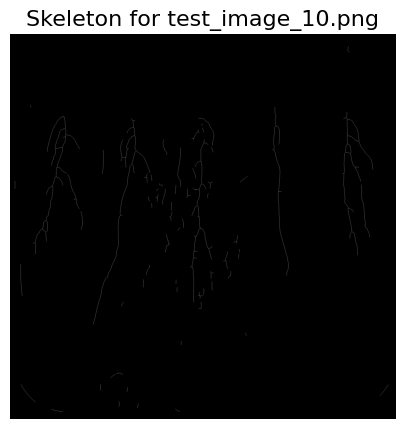

Branch data for test_image_10.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           44        51.041631            0   
1            1           45           69        20.242641            0   
2            2           60          756       148.112698            1   
3            3          101          231        45.899495            1   
4            4          160          179         7.242641            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 91               2469   
1               1.0                0.0                520                151   
2               1.0                0.0                534               1933   
3               1.0                0.0                569               2457   
4               1.0                0.0                599                387   

   image-coord-dst-0  image-coord-dst-1

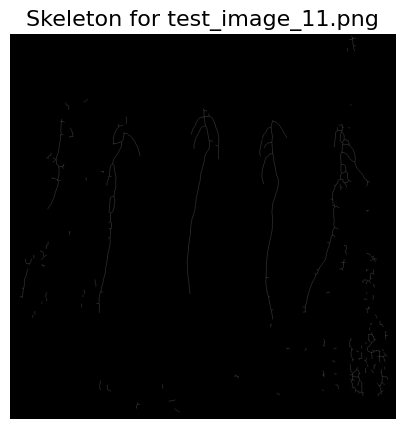

Branch data for test_image_11.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           14        15.485281            1   
1            0           14           46         8.000000            2   
2            0           14           40        24.828427            1   
3            0           46           69        22.656854            1   
4            0           46          120        53.142136            2   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 17               2491   
1               1.0                0.0                 30               2497   
2               1.0                0.0                 30               2497   
3               1.0                0.0                 37               2496   
4               1.0                0.0                 37               2496   

   image-coord-dst-0  image-coord-dst-1

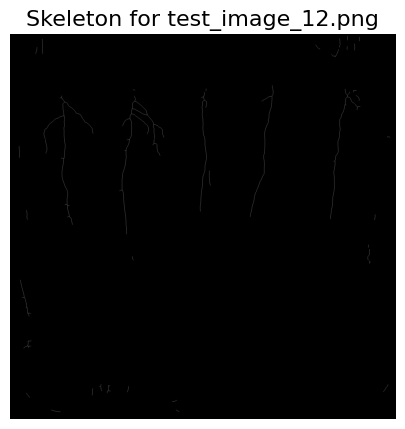

Branch data for test_image_12.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           78        31.414214            0   
1            1            9           97        29.828427            0   
2            2           28          160        49.485281            0   
3            3           40          428       109.656854            0   
4            4          136          354        50.656854            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 14               2462   
1               1.0                0.0                 22               2548   
2               1.0                0.0                 32               2404   
3               1.0                0.0                 36                234   
4               1.0                0.0                 70               2512   

   image-coord-dst-0  image-coord-dst-1

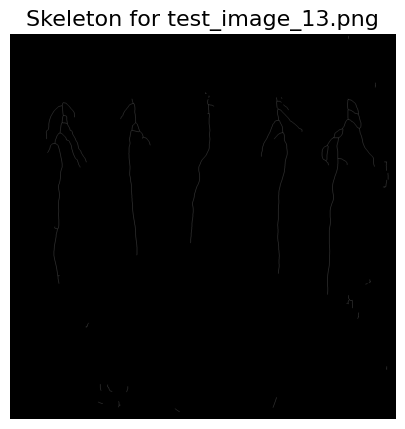

Branch data for test_image_13.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           20        20.000000            0   
1            1           21           42        20.828427            1   
2            1           41           42         1.414214            1   
3            1           42           56        14.828427            1   
4            2           57           64         7.828427            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 14               2469   
1               1.0                0.0                356               2664   
2               1.0                0.0                375               2667   
3               1.0                0.0                376               2666   
4               1.0                0.0                427               1427   

   image-coord-dst-0  image-coord-dst-1

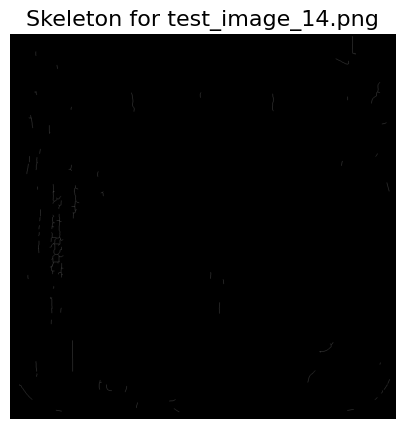

Branch data for test_image_14.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          174       155.970563            0   
1            1          112          183        32.242641            0   
2            2          184          221       131.225397            0   
3            3          298          325        29.071068            0   
4            4          326          402        79.284271            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 16               2496   
1               1.0                0.0                128                189   
2               1.0                0.0                180               2376   
3               1.0                0.0                227                342   
4               1.0                0.0                352               2699   

   image-coord-dst-0  image-coord-dst-1

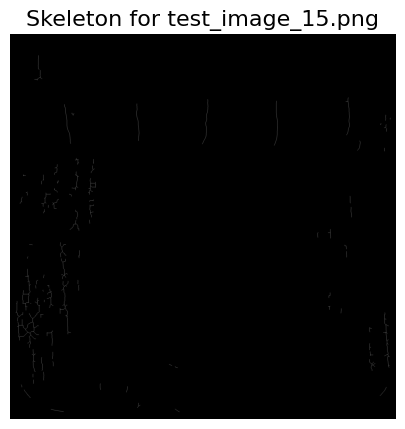

Branch data for test_image_15.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          106       109.727922            0   
1            1          107          166        58.142136            1   
2            1          166          217        26.970563            2   
3            1          166          193        18.727922            1   
4            1          197          217        20.000000            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                156                209   
1               1.0                0.0                264                221   
2               1.0                0.0                318                219   
3               1.0                0.0                318                219   
4               1.0                0.0                331                178   

   image-coord-dst-0  image-coord-dst-1

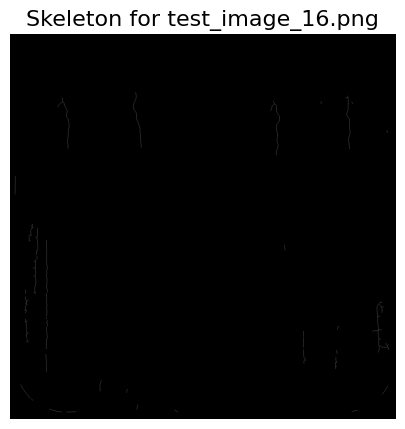

Branch data for test_image_16.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0         1686       437.551299            0   
1            1           26           76        15.000000            1   
2            2           51          184        34.899495            1   
3            1           76           79        20.414214            1   
4            1           76          305        46.656854            2   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                426                918   
1               1.0                0.0                451               2465   
2               1.0                0.0                464                378   
3               1.0                0.0                466               2465   
4               1.0                0.0                466               2465   

   image-coord-dst-0  image-coord-dst-1

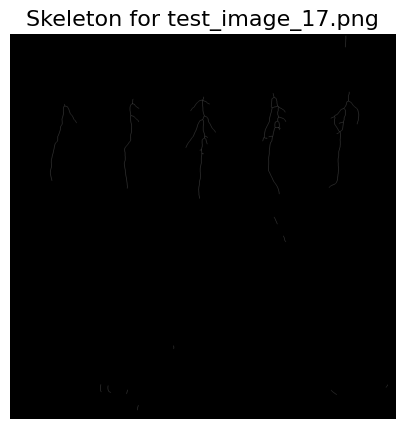

Branch data for test_image_17.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           84        86.071068            0   
1            1           85          327        68.899495            1   
2            2           95          161        32.899495            1   
3            3          147          255        25.485281            1   
4            2          161          886        91.112698            2   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 12               2451   
1               1.0                0.0                423               2474   
2               1.0                0.0                433               1919   
3               1.0                0.0                459               1412   
4               1.0                0.0                463               1926   

   image-coord-dst-0  image-coord-dst-1

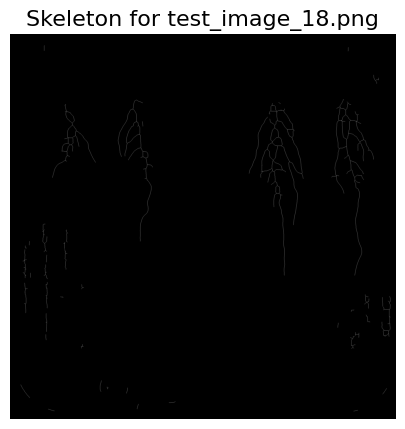

Branch data for test_image_18.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            1           64        39.828427            0   
1            1           15           68        28.828427            0   
2            2           69          147        46.384776            1   
3            2           91          133        14.828427            1   
4            2          133          147        23.485281            2   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 84                252   
1               1.0                0.0                 97               2468   
2               1.0                0.0                299               2653   
3               1.0                0.0                320               2689   
4               1.0                0.0                334               2687   

   image-coord-dst-0  image-coord-dst-1

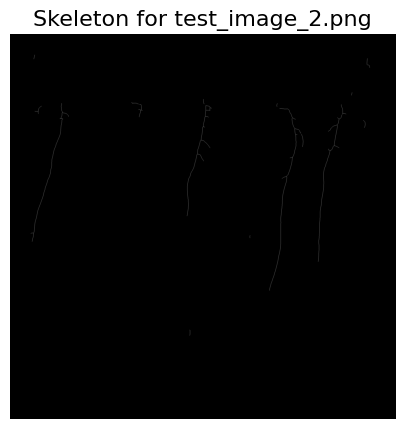

Branch data for test_image_2.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           36        33.899495            0   
1            1           27          109        83.627417            0   
2            2          110          131        23.071068            0   
3            3          132          233        38.485281            0   
4            4          155          171        12.485281            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                152                180   
1               1.0                0.0                178               2607   
2               1.0                0.0                427               2495   
3               1.0                0.0                476               1410   
4               1.0                0.0                499                885   

   image-coord-dst-0  image-coord-dst-1 

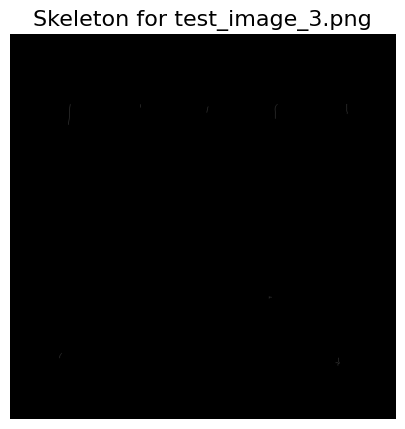

Branch data for test_image_3.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          401       155.798990            0   
1            1            1          357       115.698485            0   
2            2            2           16         3.000000            1   
3            3            4          106        23.828427            0   
4            2           12           16         2.414214            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                513                440   
1               1.0                0.0                513               1951   
2               1.0                0.0                513               2456   
3               1.0                0.0                514                951   
4               1.0                0.0                515               2458   

   image-coord-dst-0  image-coord-dst-1 

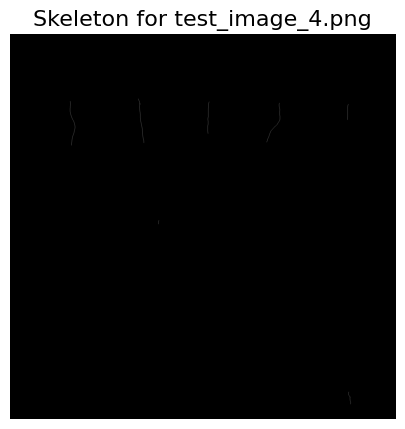

Branch data for test_image_4.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           82        42.556349            1   
1            1           18         1292       350.752309            0   
2            2           28         1074       240.870058            0   
3            3           56         1264       333.320851            0   
4            0           82           92         6.414214            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                473                935   
1               1.0                0.0                491                439   
2               1.0                0.0                495               1454   
3               1.0                0.0                504               1965   
4               1.0                0.0                511                946   

   image-coord-dst-0  image-coord-dst-1 

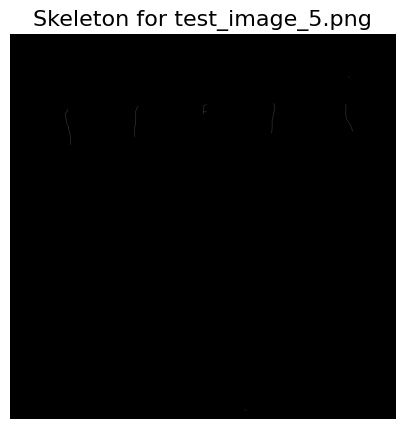

Branch data for test_image_5.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0            9        10.656854            0   
1            1           10          914       234.083261            0   
2            2           18          872       220.781746            0   
3            3           22          286        69.213203            1   
4            4           58          966       239.840620            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                312               2467   
1               1.0                0.0                507               1923   
2               1.0                0.0                514               2446   
3               1.0                0.0                515               1432   
4               1.0                0.0                525                928   

   image-coord-dst-0  image-coord-dst-1 

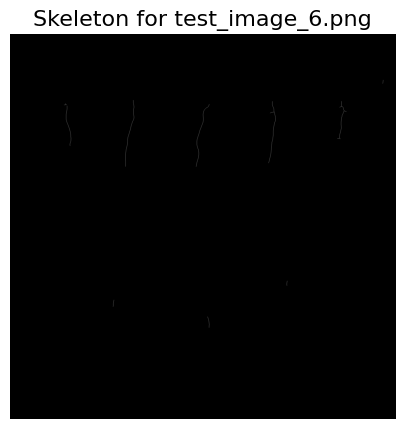

Branch data for test_image_6.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           26        27.242641            0   
1            1           27         2109       518.722871            0   
2            2           36          203        39.656854            1   
3            3           38          448        84.627417            1   
4            4           85          120         8.414214            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                336               2722   
1               1.0                0.0                483                898   
2               1.0                0.0                491               2416   
3               1.0                0.0                492               1914   
4               1.0                0.0                508                405   

   image-coord-dst-0  image-coord-dst-1 

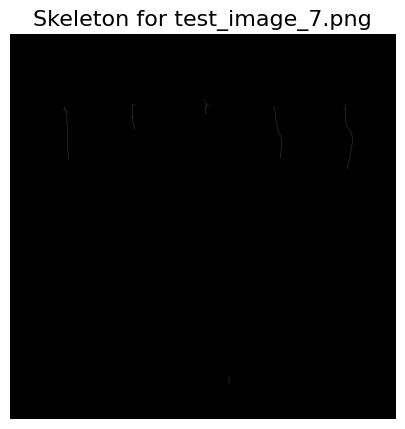

Branch data for test_image_7.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           14        18.142136            0   
1            1           15           71        29.899495            1   
2            2           30          520       106.556349            1   
3            3           38          209        36.242641            1   
4            1           71          114        19.485281            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                480               1412   
1               1.0                0.0                495               1428   
2               1.0                0.0                510                907   
3               1.0                0.0                513               2446   
4               1.0                0.0                522               1435   

   image-coord-dst-0  image-coord-dst-1 

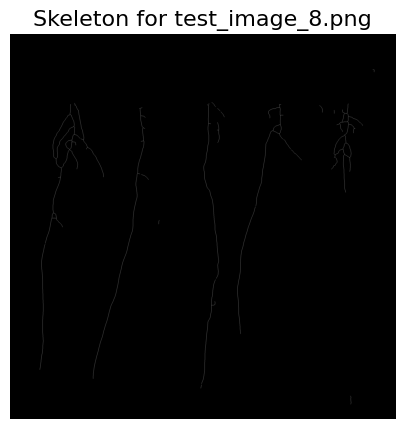

Branch data for test_image_8.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0           27        27.828427            0   
1            1           28          214        45.769553            0   
2            2           35          119        16.071068            1   
3            3           41          129        15.485281            1   
4            4           49          764        76.384776            1   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                261               2646   
1               1.0                0.0                501               1471   
2               1.0                0.0                505                471   
3               1.0                0.0                507               1451   
4               1.0                0.0                509               2467   

   image-coord-dst-0  image-coord-dst-1 

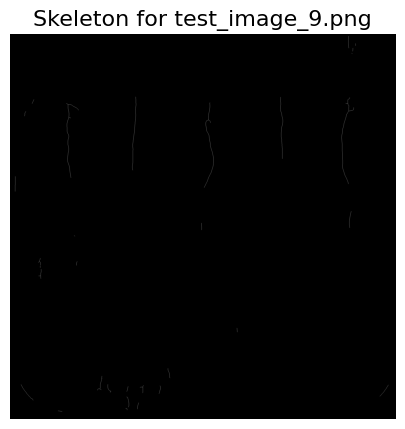

Branch data for test_image_9.png:
   skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0            0            0          106        90.485281            0   
1            1           55           87        16.414214            0   
2            2          105          130        24.828427            0   
3            3          131          137         6.828427            0   
4            4          138         2916       555.225397            0   

   mean-pixel-value  stdev-pixel-value  image-coord-src-0  image-coord-src-1  \
0               1.0                0.0                 15               2470   
1               1.0                0.0                 69               2520   
2               1.0                0.0                102               2502   
3               1.0                0.0                139               2493   
4               1.0                0.0                459                916   

   image-coord-dst-0  image-coord-dst-1 

In [18]:
from skimage.morphology import skeletonize
from skan import Skeleton, summarize
import matplotlib.pyplot as plt

# Process skeletonization for each binary connected component
skeleton_results = []
for filename, binary_labels in processed_masks:
    # Step 1: Skeletonize the binary mask
    skeleton_object = skeletonize(binary_labels > 0)  # Ensure mask is binary (True for foreground)

    # Step 2: Convert the skeletonized object into a skan Skeleton object
    skeleton_data = Skeleton(skeleton_object)

    # Step 3: Summarize the skeleton's branch data
    branch_data = summarize(skeleton_data)

    # Append results for further use
    skeleton_results.append((filename, skeleton_object, branch_data))

    # Plot the skeletonized mask
    plt.figure(figsize=(10, 5))
    plt.title(f"Skeleton for {filename}", fontsize=16)
    plt.imshow(skeleton_object, cmap='gray')
    plt.axis('off')
    plt.show()

    # Display branch data
    print(f"Branch data for {filename}:")
    print(branch_data.head())  # Display the first few rows of branch data

Processing test_image_1.png...


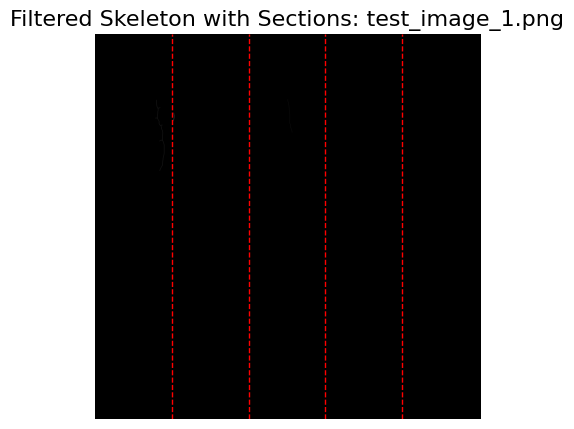

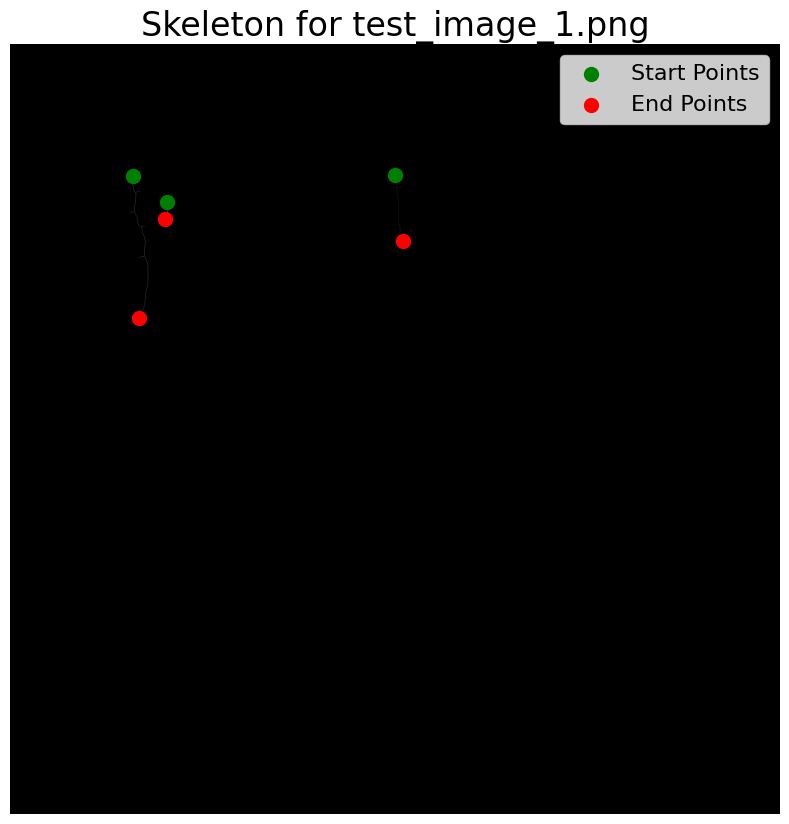

Processing test_image_10.png...


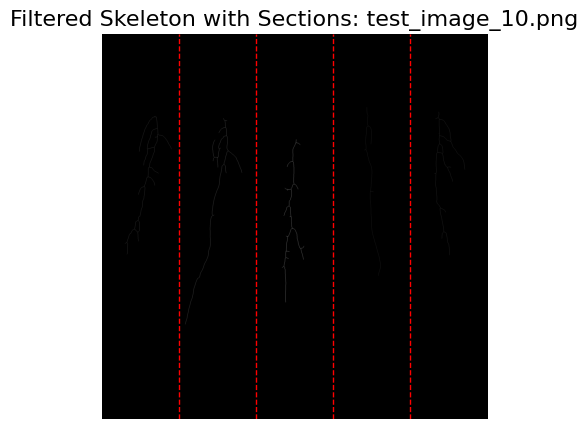

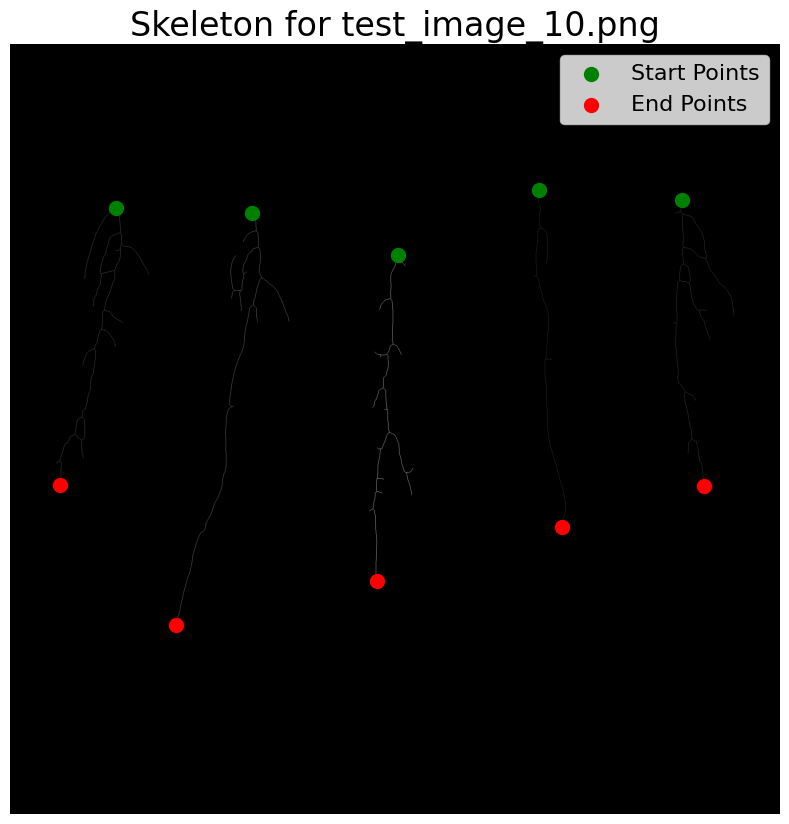

Processing test_image_11.png...


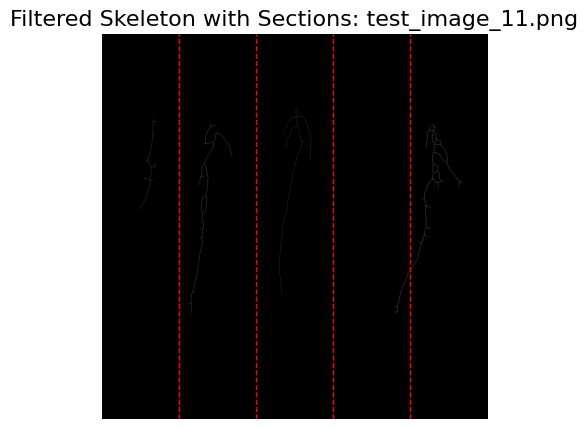

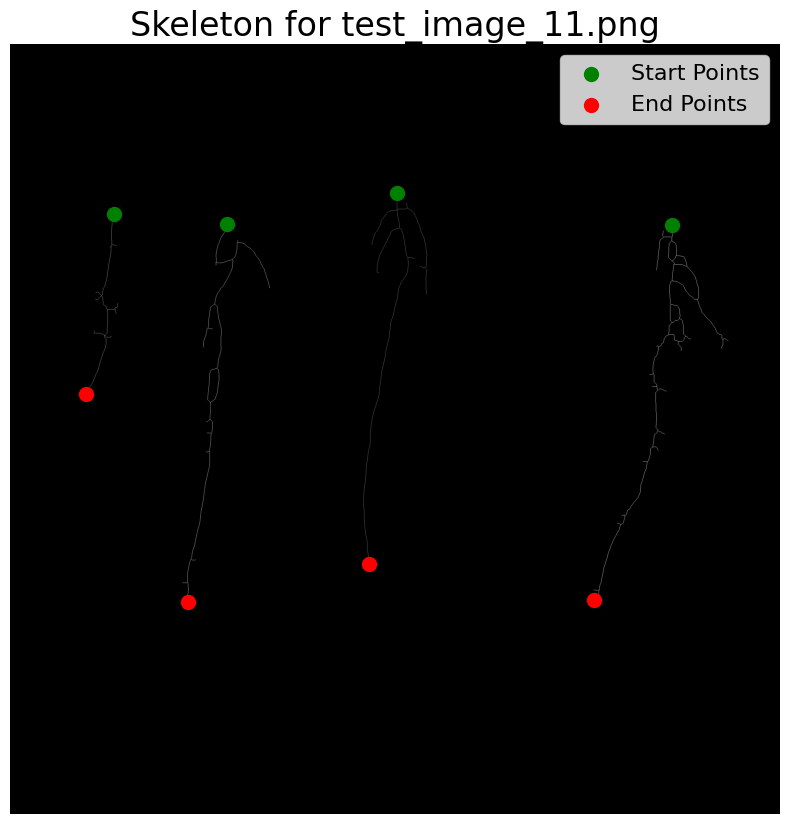

Processing test_image_12.png...


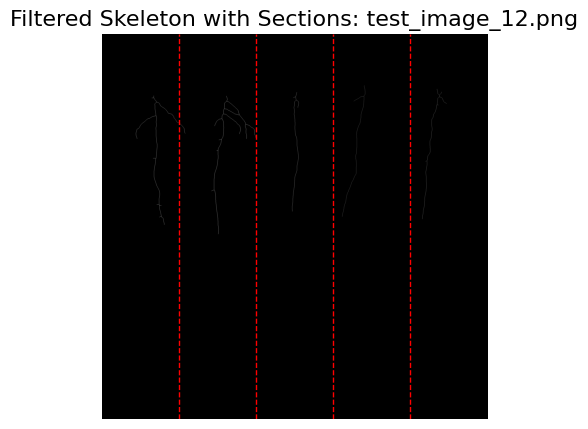

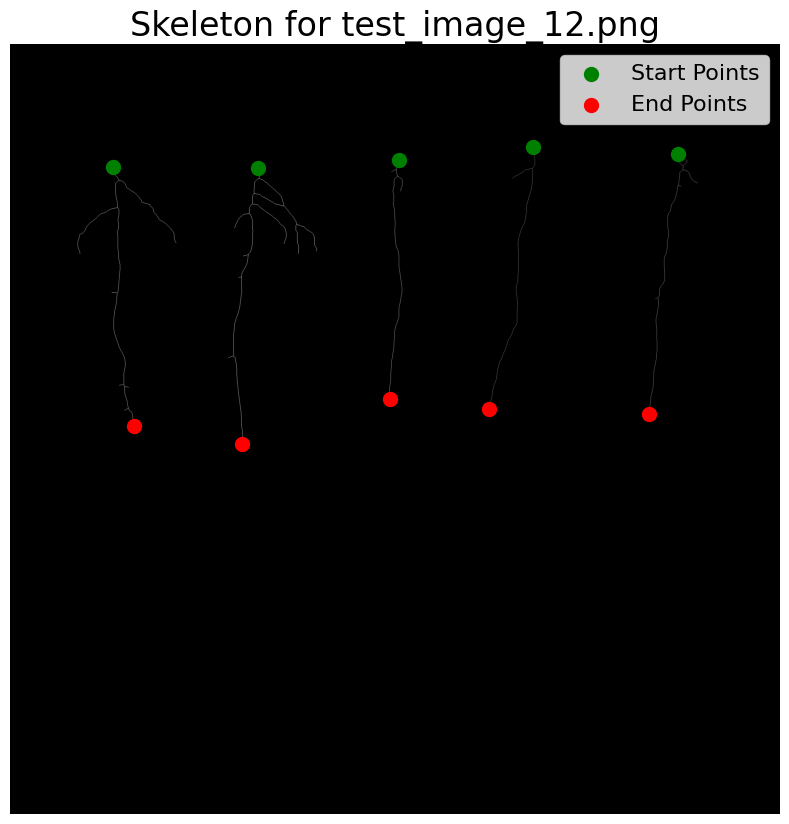

Processing test_image_13.png...


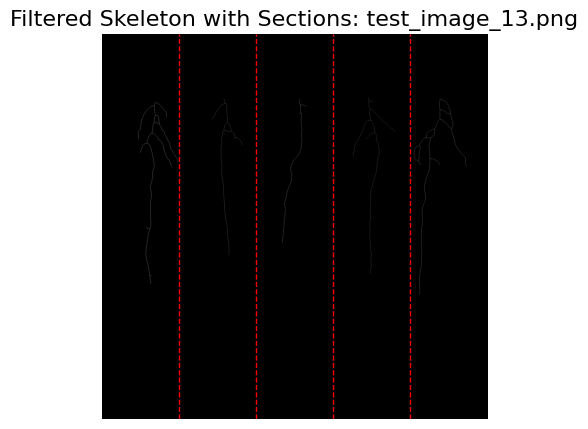

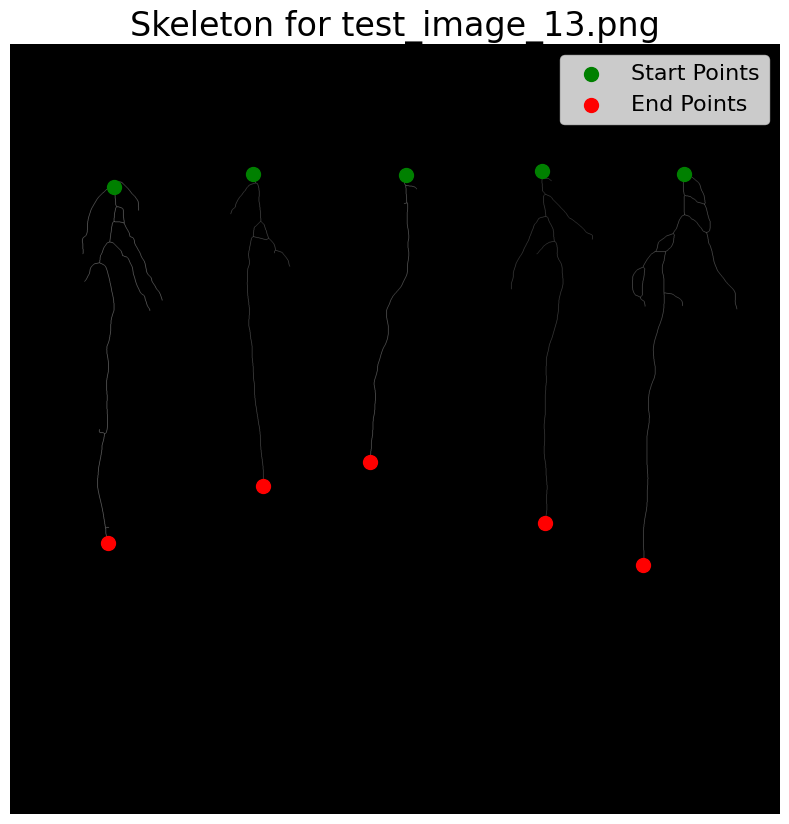

Processing test_image_14.png...


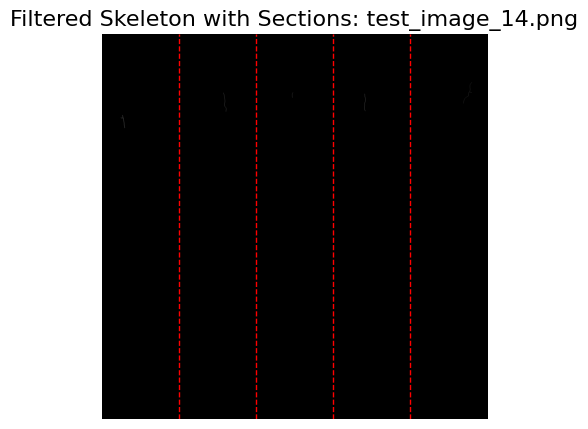

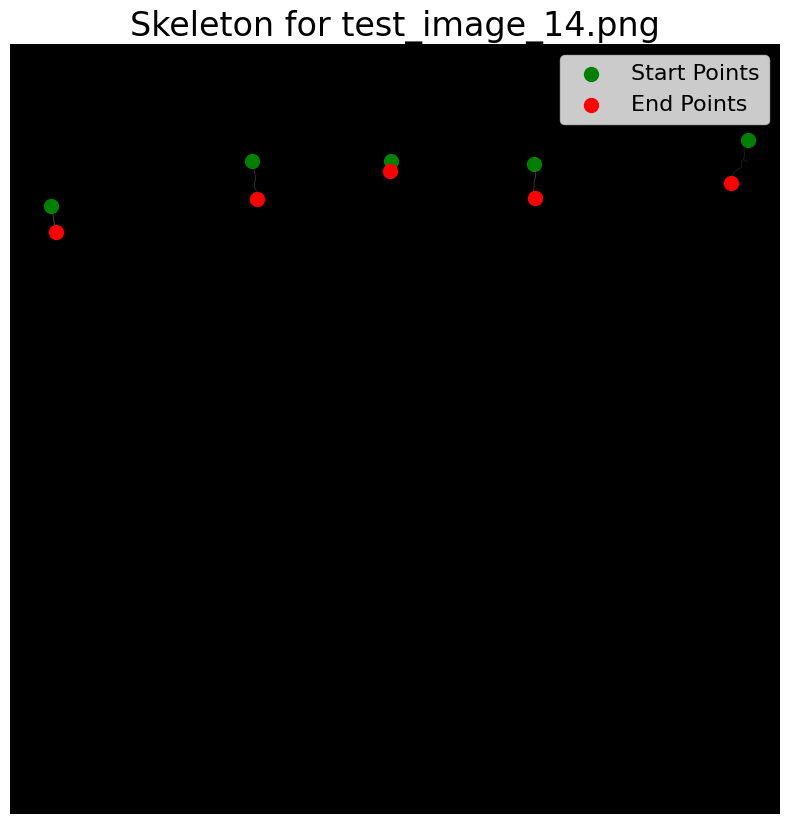

Processing test_image_15.png...


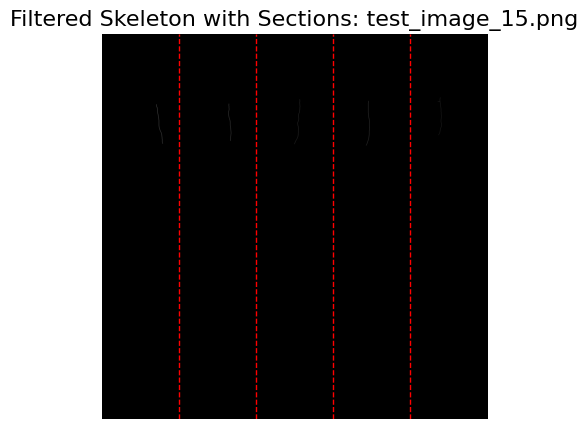

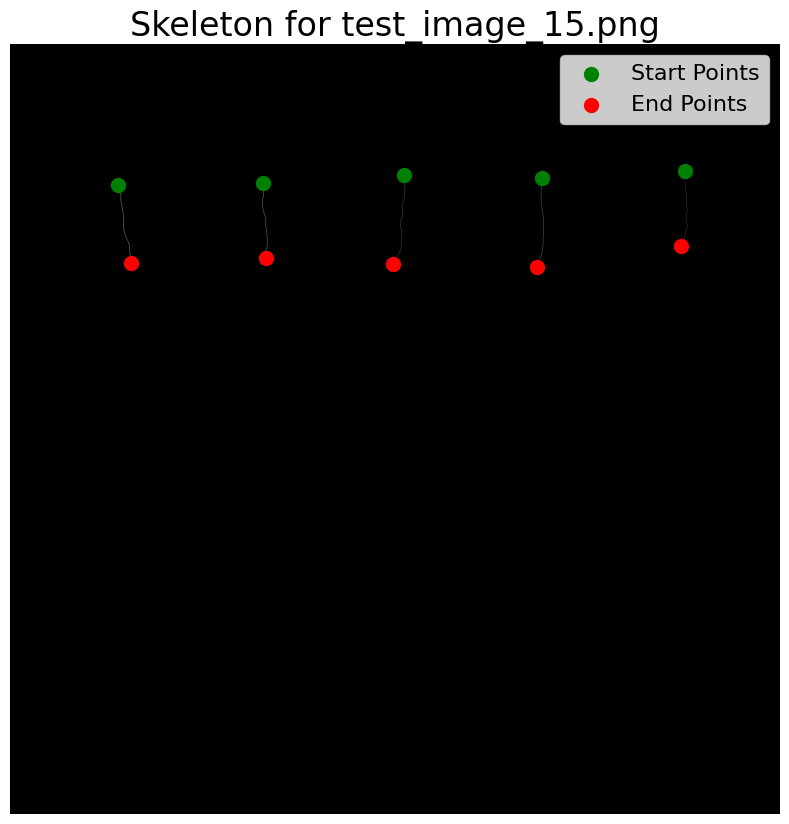

Processing test_image_16.png...


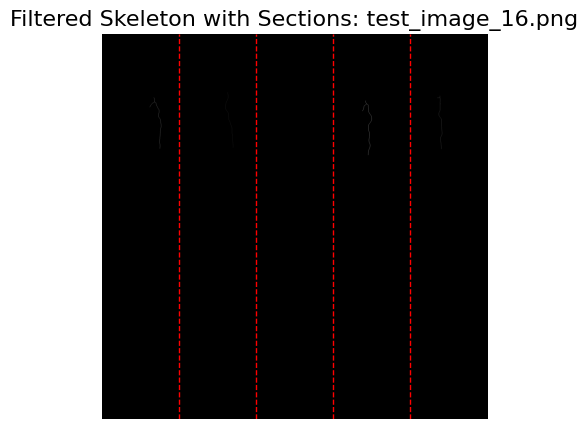

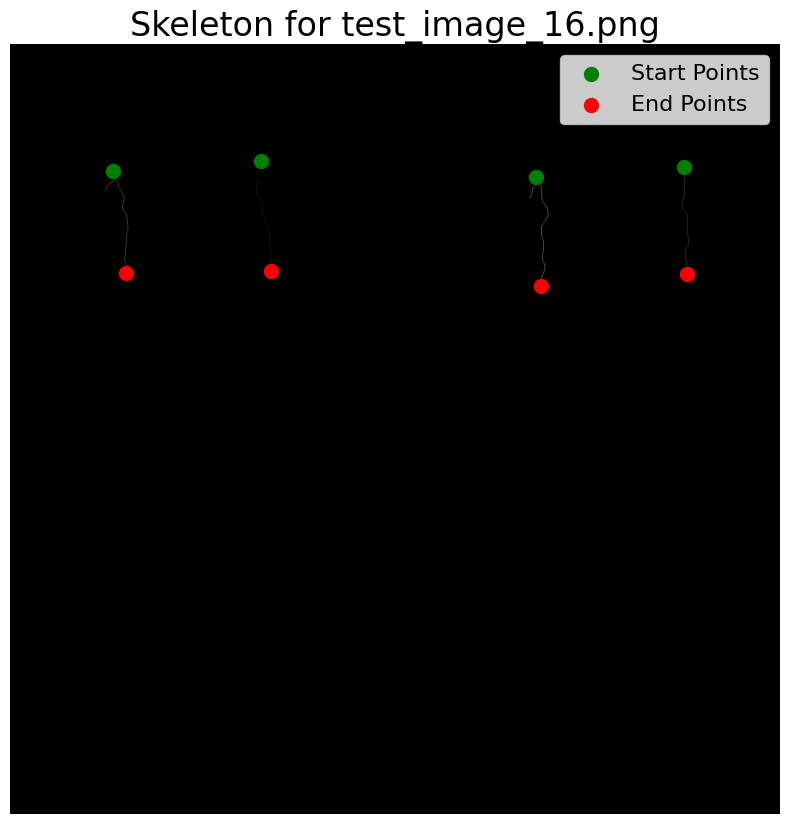

Processing test_image_17.png...


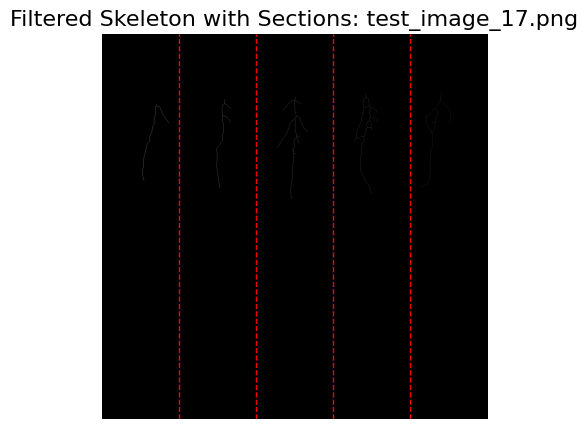

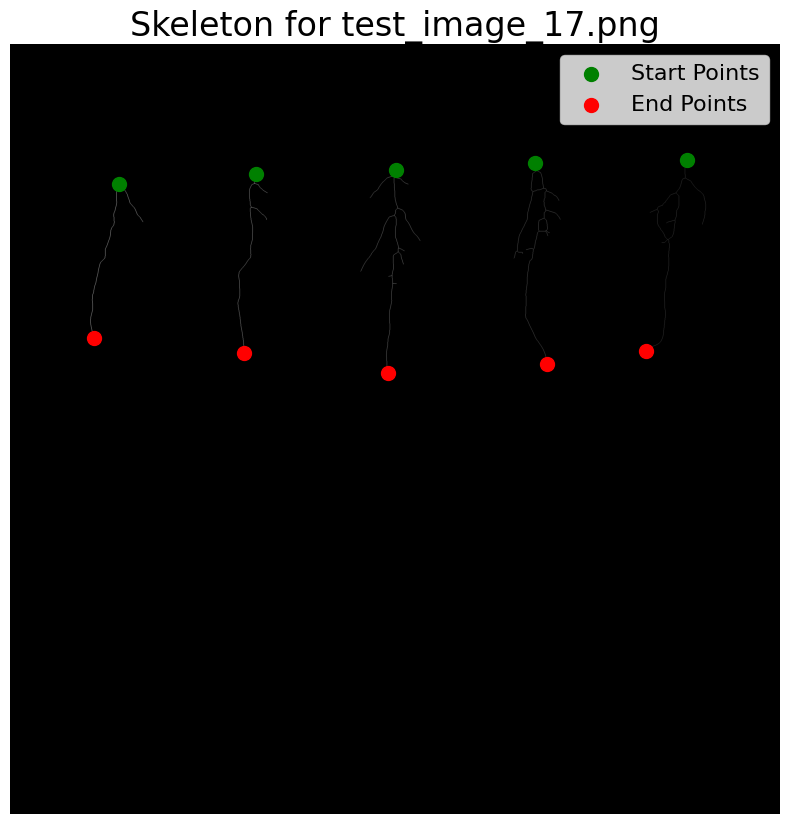

Processing test_image_18.png...


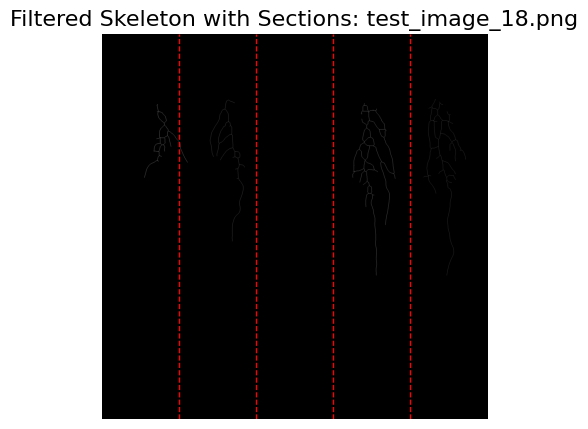

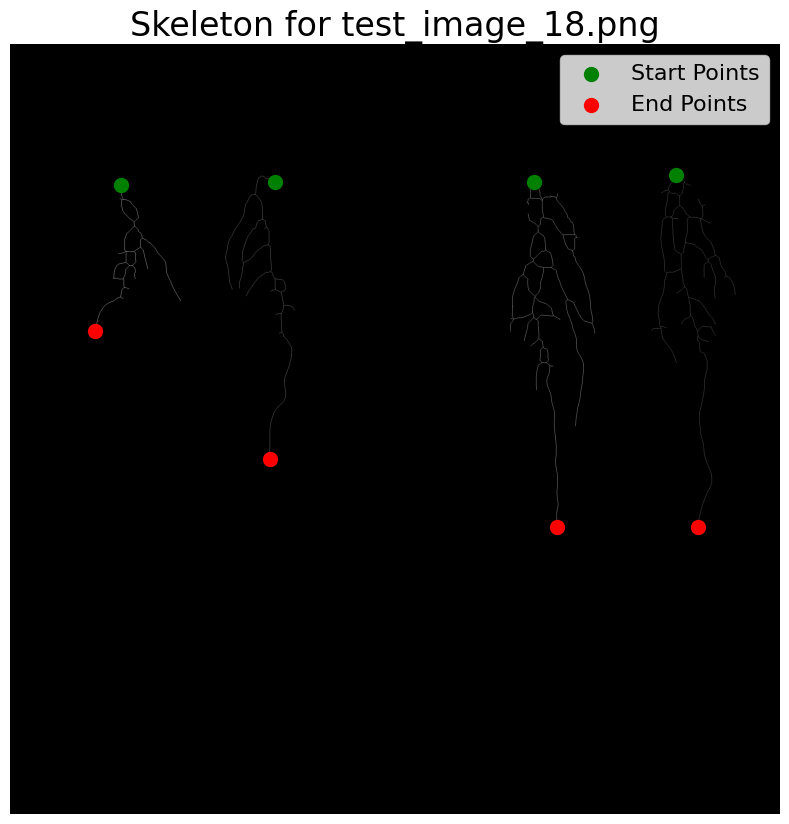

Processing test_image_2.png...


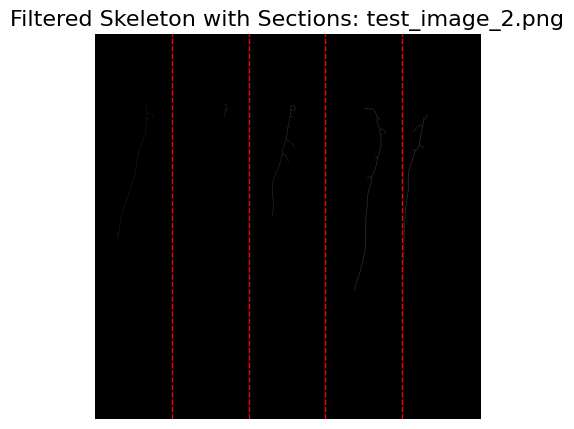

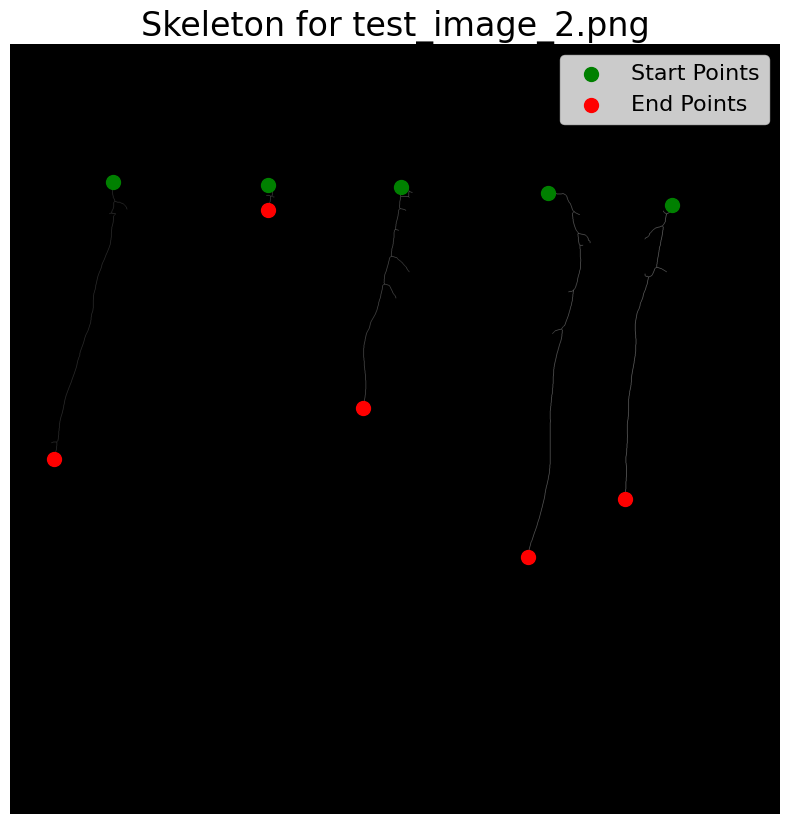

Processing test_image_3.png...


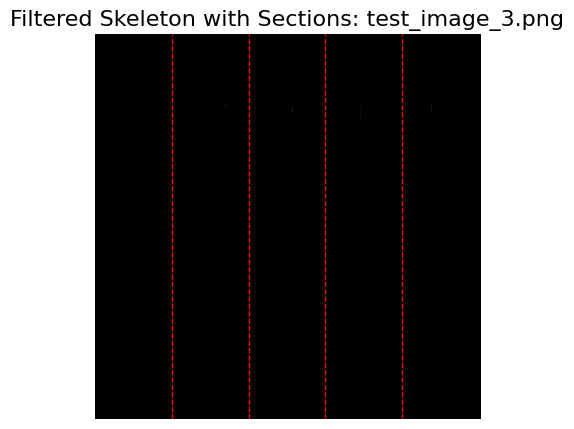

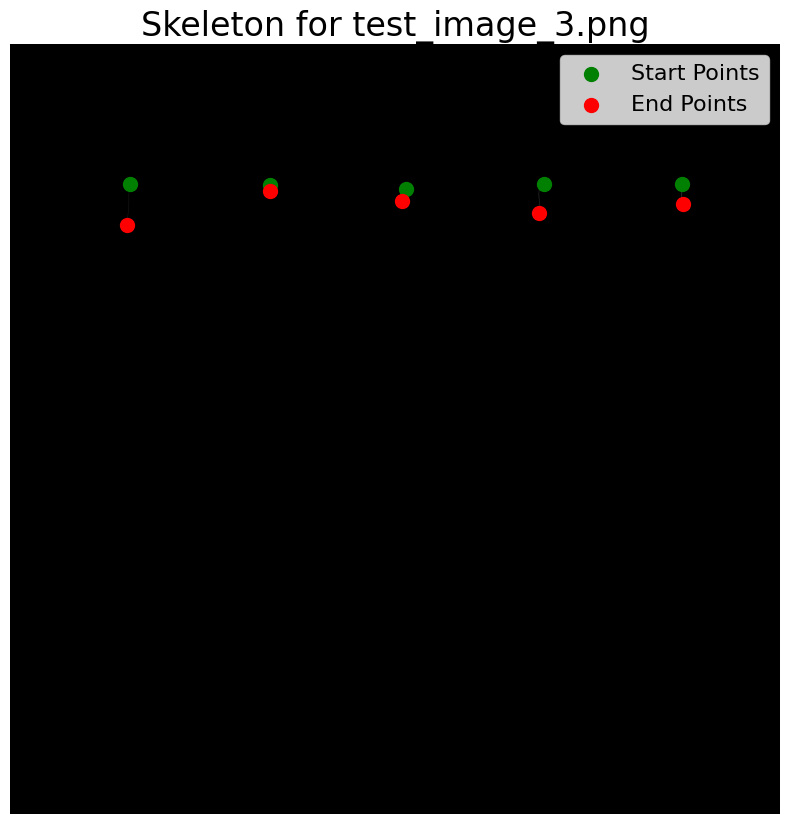

Processing test_image_4.png...


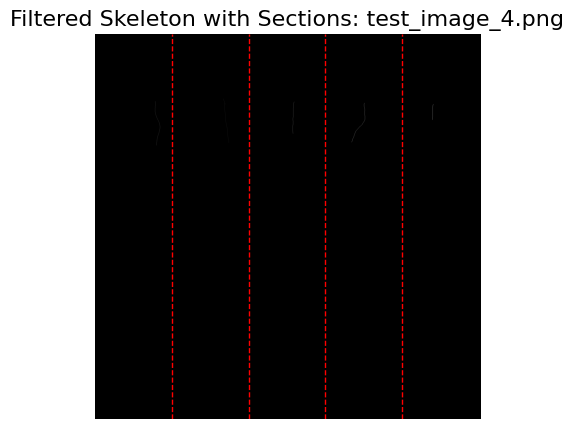

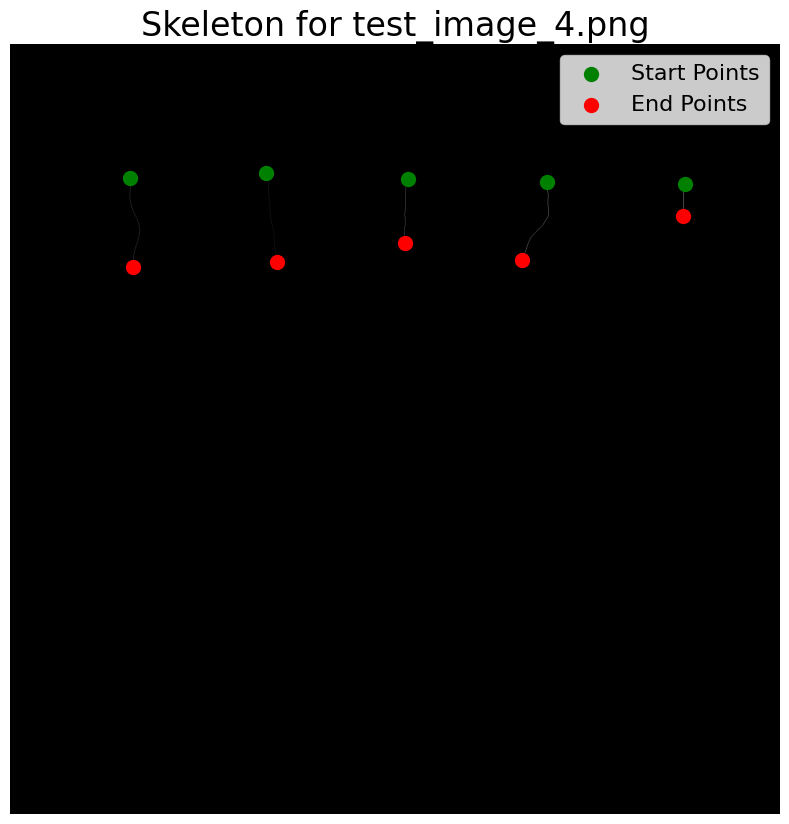

Processing test_image_5.png...


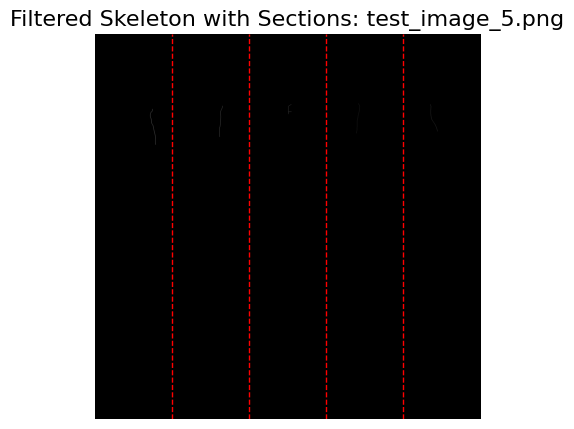

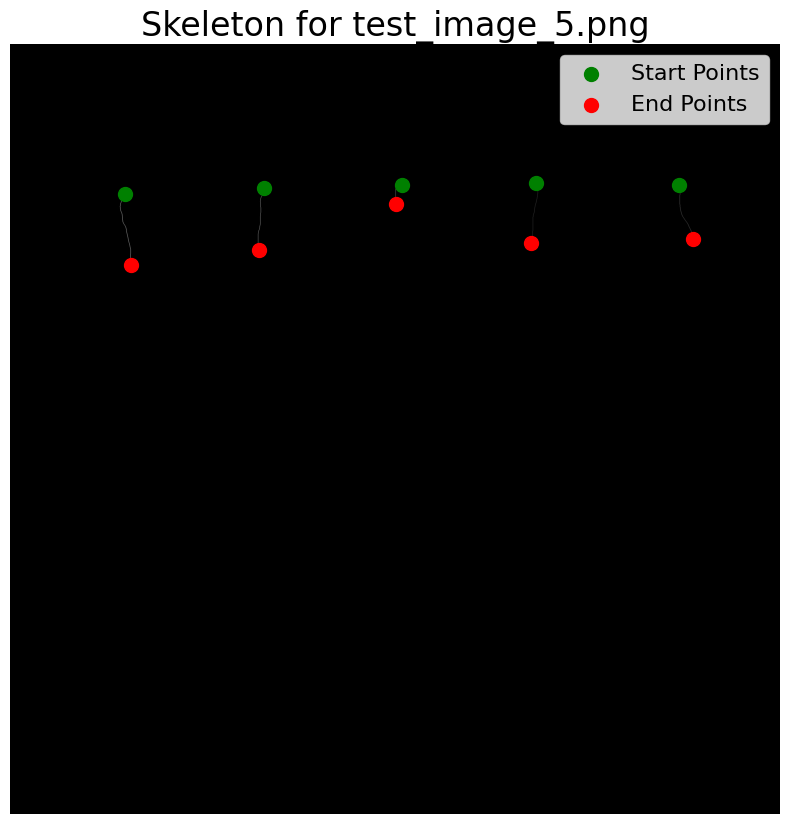

Processing test_image_6.png...


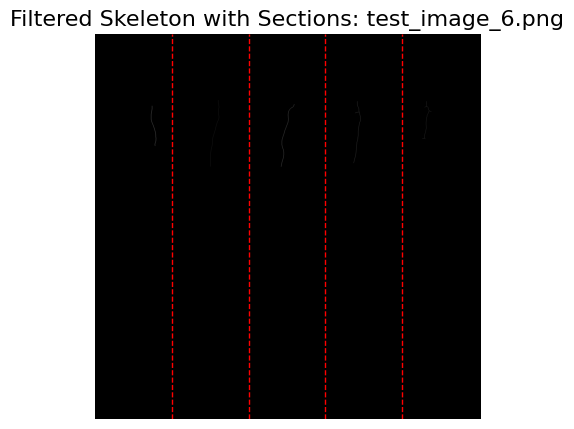

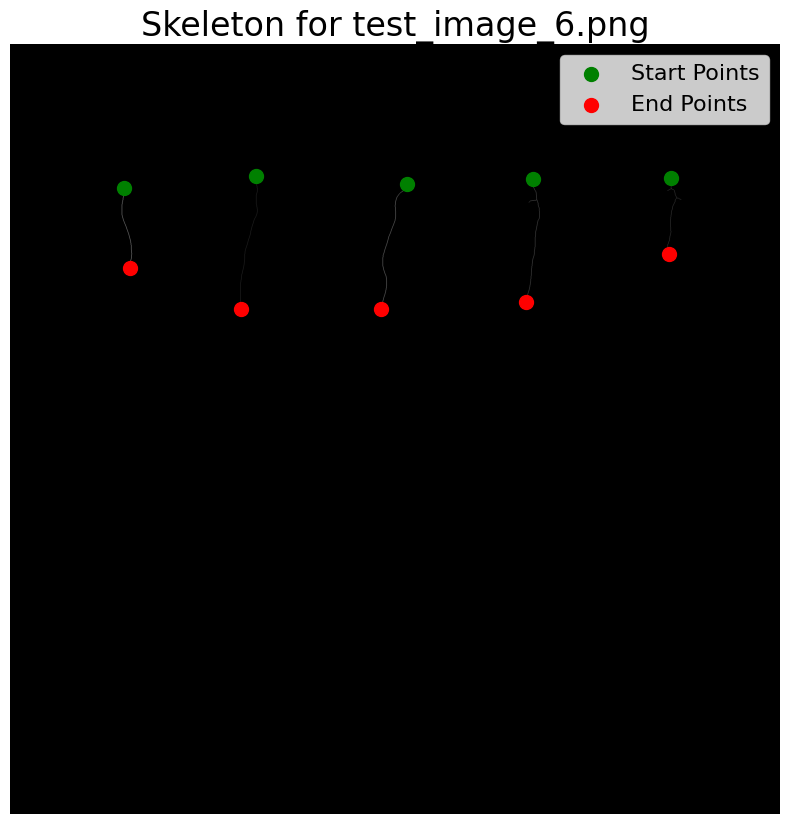

Processing test_image_7.png...


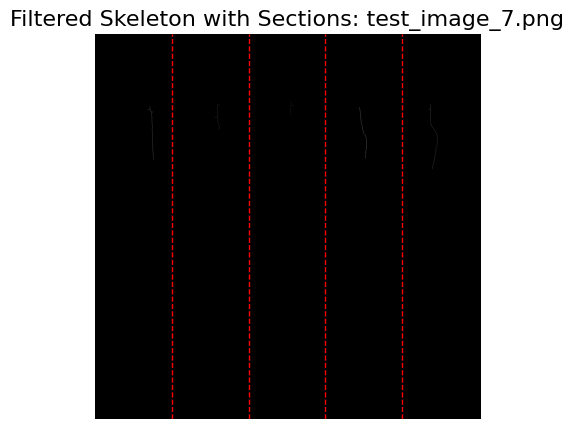

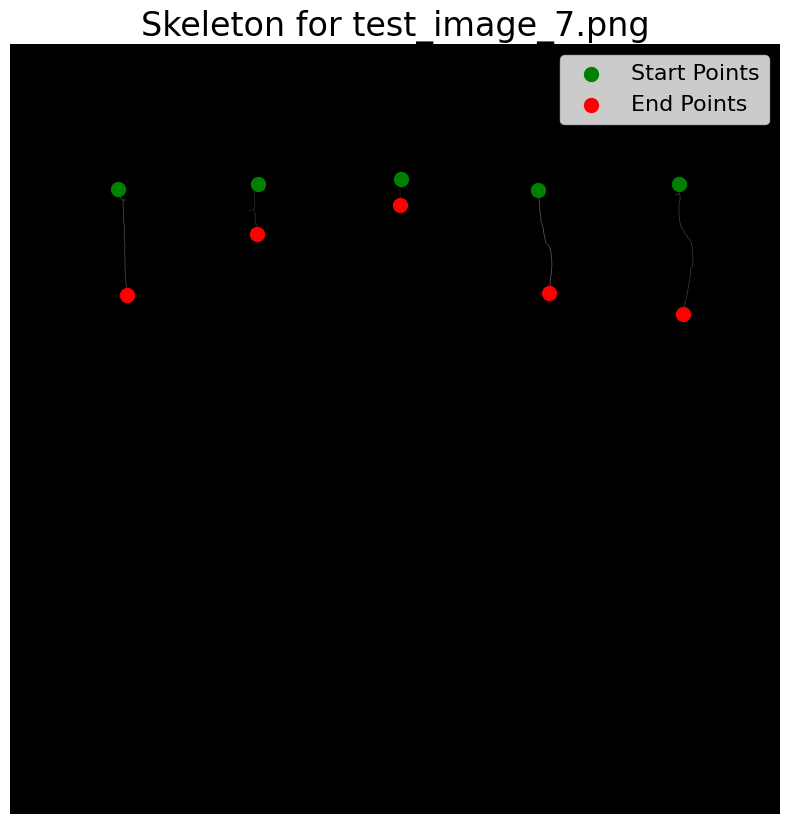

Processing test_image_8.png...


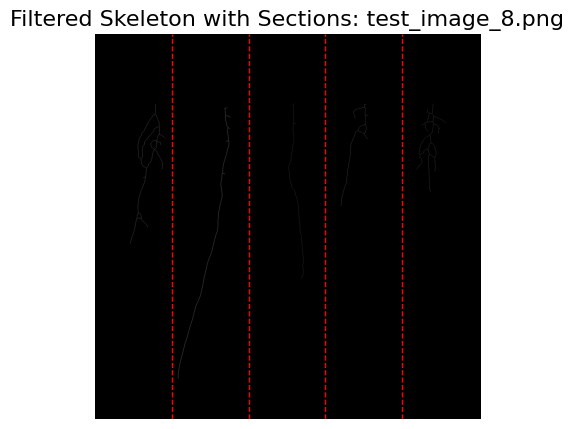

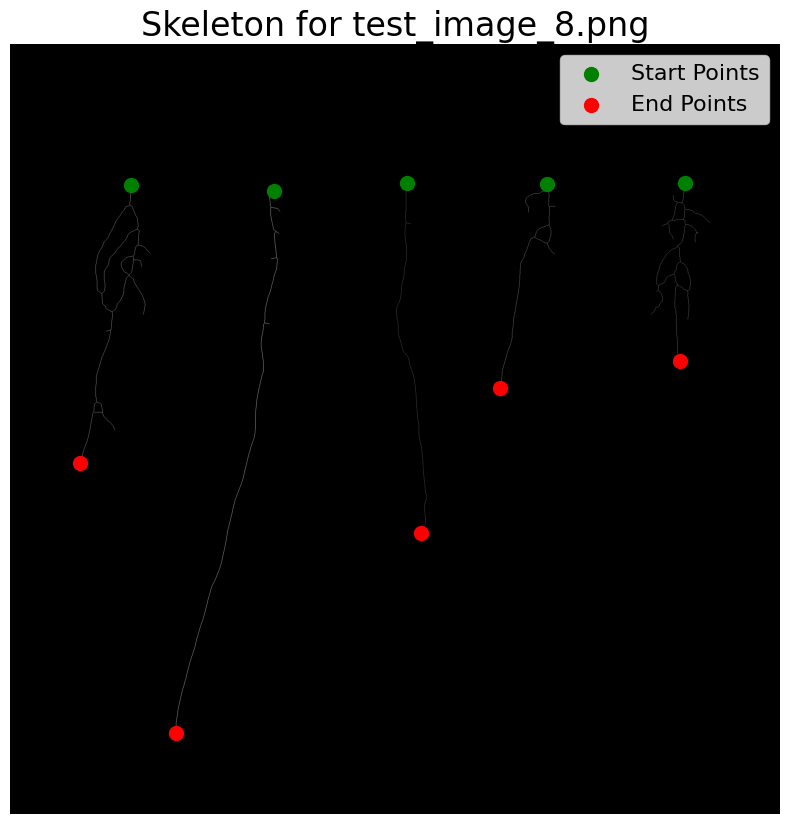

Processing test_image_9.png...


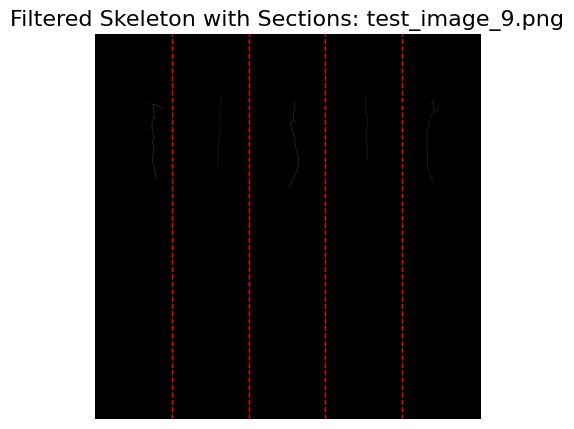

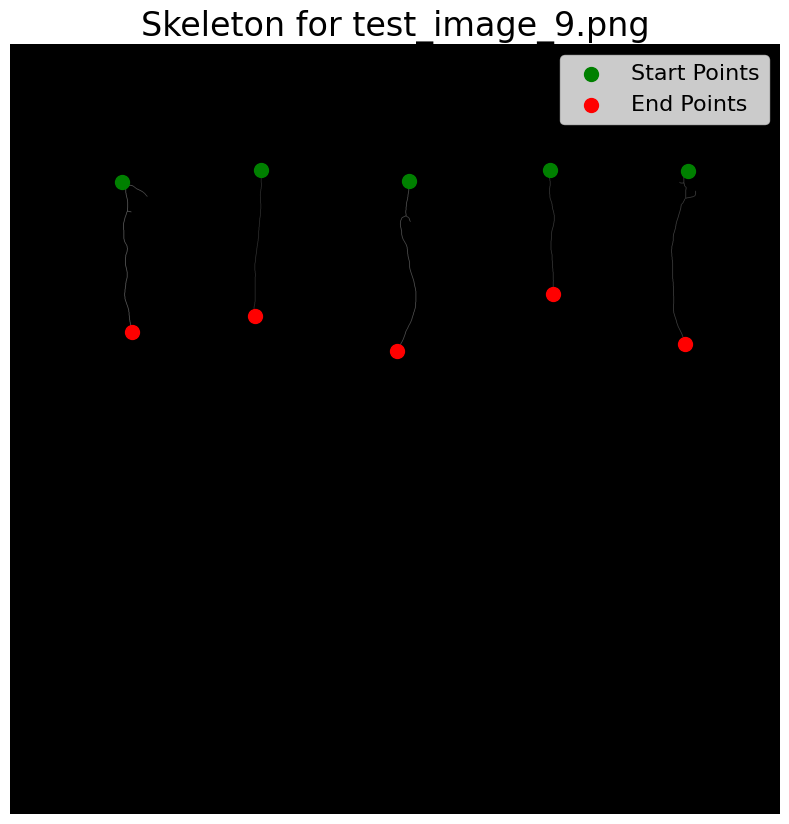

    skeleton-id           filename  start_y  start_x   end_y   end_x  \
0             0   test_image_1.png    477.0   1406.0   720.0  1436.0   
1             1   test_image_1.png    482.0    449.0  1000.0   471.0   
2             2   test_image_1.png    576.0    573.0   639.0   567.0   
3             0  test_image_10.png    534.0   1933.0  1767.0  2017.0   
4             1  test_image_10.png    569.0   2457.0  1617.0  2536.0   
..          ...                ...      ...      ...     ...     ...   
80            0   test_image_9.png    459.0    916.0   996.0   896.0   
81            1   test_image_9.png    461.0   1974.0   912.0  1987.0   
82            2   test_image_9.png    464.0   2478.0  1096.0  2468.0   
83            3   test_image_9.png    501.0   1458.0  1123.0  1415.0   
84            4   test_image_9.png    506.0    410.0  1051.0   444.0   

    path_length  
0    257.083261  
1    569.078210  
2     68.798990  
3   1314.872150  
4   1138.144228  
..          ...  
80   555.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize
from skan import Skeleton, summarize
import networkx as nx

# Process skeletonization and extract data for each binary connected component
all_start_end_data = []

for filename, binary_labels in processed_masks:
    print(f"Processing {filename}...")

    # Step 1: Skeletonize the binary mask
    skeleton_object = skeletonize(binary_labels > 0)

    # Step 2: Label connected components
    labeled_roots = label(skeleton_object)

    # Step 3: Remove components entirely above the horizontal midpoint
    midpoint_y = int(binary_labels.shape[0] * 0.35)
    for region in regionprops(labeled_roots):
        if region.bbox[0] >= midpoint_y:  # If the component's minimum Y is above the midpoint
            labeled_roots[labeled_roots == region.label] = 0

    # Step 4: Divide the image into 5 vertical sections and keep the largest component in each sector
    section_width = binary_labels.shape[1] // 5
    filtered_roots = np.zeros_like(labeled_roots)

    for sector_id in range(5):
        x_start = sector_id * section_width
        x_end = (sector_id + 1) * section_width if sector_id < 4 else binary_labels.shape[1]

        # Get the components in the current sector
        sector_mask = labeled_roots[:, x_start:x_end]
        sector_labels = np.unique(sector_mask[sector_mask > 0])  # Exclude background

        # Find the largest component, including those that cross sector boundaries
        max_area = 0
        largest_label = 0
        for label_id in sector_labels:
            area = np.sum(labeled_roots == label_id)  # Count all pixels for the label across the entire image
            if area > max_area:
                max_area = area
                largest_label = label_id

        # Keep the largest component in this sector
        if largest_label > 0:
            filtered_roots[labeled_roots == largest_label] = largest_label

    # Step 5: Plot filtered roots with sections
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(filtered_roots, cmap="gray")

    # Draw vertical lines to indicate sections
    for i in range(1, 5):  # 4 lines divide into 5 sections
        x = i * section_width
        ax.axvline(x=x, color="red", linestyle="--", linewidth=1)

    ax.set_title(f"Filtered Skeleton with Sections: {filename}", fontsize=16)
    ax.axis("off")
    plt.show()

    # Step 6: Summarize the skeleton
    skeleton_data = Skeleton(filtered_roots)
    branch_data = summarize(skeleton_data)

    # Step 7: Create a NetworkX graph from the skeleton branch data
    G = nx.from_pandas_edgelist(
        branch_data, 
        source='node-id-src', 
        target='node-id-dst', 
        edge_attr='branch-distance'
    )

    # Step 8: Extract start and end points of the skeleton
    results = []
    for skeleton_id, group in branch_data.groupby("skeleton-id"):
        # Start point (minimum y-coordinate)
        start_branch = group.loc[group[["image-coord-src-0", "image-coord-dst-0"]].min(axis=1).idxmin()]
        start_y = start_branch[["image-coord-src-0", "image-coord-dst-0"]].min()
        start_x = start_branch[["image-coord-src-1", "image-coord-dst-1"]].iloc[start_branch[["image-coord-src-0", "image-coord-dst-0"]].argmin()]

        # End point (maximum y-coordinate)
        end_branch = group.loc[group[["image-coord-src-0", "image-coord-dst-0"]].max(axis=1).idxmax()]
        end_y = end_branch[["image-coord-src-0", "image-coord-dst-0"]].max()
        end_x = end_branch[["image-coord-src-1", "image-coord-dst-1"]].iloc[end_branch[["image-coord-src-0", "image-coord-dst-0"]].argmax()]

        results.append({
            "skeleton-id": skeleton_id,
            "filename": filename,
            "start_y": start_y,
            "start_x": start_x,
            "end_y": end_y,
            "end_x": end_x
        })

    # Convert results to a DataFrame
    start_end_df = pd.DataFrame(results)

    # Step 9: Map coordinates to nodes and compute shortest paths
    coordinate_to_node = {}
    for _, row in branch_data.iterrows():
        coordinate_to_node[(row['image-coord-src-0'], row['image-coord-src-1'])] = row['node-id-src']
        coordinate_to_node[(row['image-coord-dst-0'], row['image-coord-dst-1'])] = row['node-id-dst']

    path_lengths = []
    for _, row in start_end_df.iterrows():
        src_node = coordinate_to_node.get((row['start_y'], row['start_x']), None)
        dst_node = coordinate_to_node.get((row['end_y'], row['end_x']), None)

        if src_node is not None and dst_node is not None and src_node in G.nodes and dst_node in G.nodes:
            try:
                path_len = nx.dijkstra_path_length(G, src_node, dst_node, weight='branch-distance')
                path_lengths.append(path_len)
            except nx.NetworkXNoPath:
                path_lengths.append(None)
        else:
            path_lengths.append(None)

    start_end_df['path_length'] = path_lengths
    all_start_end_data.append(start_end_df)

    # Visualize skeleton with start and end points
    plt.figure(figsize=(15, 10))
    plt.title(f"Skeleton for {filename}", fontsize=24)
    plt.imshow(filtered_roots, cmap='gray')  # Updated to display filtered_roots
    plt.scatter(start_end_df["start_x"], start_end_df["start_y"], color='green', label='Start Points', s=100)
    plt.scatter(start_end_df["end_x"], start_end_df["end_y"], color='red', label='End Points', s=100)
    plt.legend(fontsize=16)
    plt.axis("off")
    plt.show()

# Combine all results into a single DataFrame
final_data = pd.concat(all_start_end_data, ignore_index=True)

# Display the final results
print(final_data)


In [ ]:
final_data.head()

skeleton-id           filename  start_y  start_x   end_y   end_x  \
0            0   test_image_1.png    476.0   1405.0   719.0  1434.0   
1            1   test_image_1.png    481.0    448.0   999.0   470.0   
2            2   test_image_1.png    575.0    572.0   638.0   566.0   
3            0  test_image_10.png    533.0   1932.0  1766.0  2016.0   
4            1  test_image_10.png    568.0   2456.0  1616.0  2535.0   

   path_length  
0   256.669048  
1   569.078210  
2    68.798990  
3  1315.700577  
4  1140.730014

In [22]:
import numpy as np
import pandas as pd

# Initialize results
results = []

# Group by filename and process each group
for filename, group in final_data.groupby("filename"):
    # Sort the roots by start_x for left-to-right order
    sorted_group = group.sort_values(by="start_x")

    # Extract the first 5 roots or pad with zeros if fewer than 5
    for plant_id in range(1, 6):
        if plant_id <= len(sorted_group):
            # Get the root length for this plant and round to a whole number
            path_length = round(sorted_group.iloc[plant_id - 1]["path_length"])
        else:
            # No root detected, assign length 0
            path_length = 0

        # Add to results
        results.append([f"{filename[:-4]}_plant_{plant_id}", path_length])

# Convert results to DataFrame for submission
submission_df = pd.DataFrame(results, columns=["ID", "RootLength"])

# Save to CSV
submission_df.to_csv("submission_4.csv", index=False, header=False)

# Print a preview of the submission file
print(submission_df.head())


                     ID  RootLength
0  test_image_1_plant_1         569
1  test_image_1_plant_2          69
2  test_image_1_plant_3         257
3  test_image_1_plant_4           0
4  test_image_1_plant_5           0
